  # Run Quick and dirty Logistic Regression on Pharmcophore Classification

# Setup

In [1]:
%load_ext autoreload  
%autoreload 2
from IPython.display import display, HTML, Image
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:98% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

import os
import sys
import csv
import json
import time
import types
import copy
import pprint
import logging
from datetime import datetime
for p in ['..','../../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)

import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)


pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

insert ..
insert ../../..
['../../..', '..', '/home/kevin/WSL-shared/cellpainting/cj-datasets/Notebooks-Pharmacophore_Classification', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


In [2]:
# import snnl.utils as utils
# from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from KevinsRoutines.utils.utils_general import list_namespace, save_to_pickle, load_from_pickle

from src.utils.utils_cellpainting import (model_selection, balance_datasets, label_counts, compute_metrics,
                                          plots_from_estimator, plots_from_predictions)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [3]:
# Models
from xgboost import XGBClassifier, XGBRegressor

import sklearn.metrics as skm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.utils.random as skr


from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# utility class to help normalize labels such that they contain only values between 0 and n_classes-1.
from sklearn.preprocessing import LabelEncoder

# K-Folds cross-validator - Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
# Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.model_selection import ShuffleSplit, GroupShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit

# Evaluate metric(s) by cross-validation and also record fit/score times.
from sklearn.model_selection import cross_validate, cross_val_score

# Generate cross-validated estimates for each input data point.
# The data is split according to the cv parameter. Each sample belongs to exactly one test set,
# and its prediction is computed with an estimator fitted on the corresponding training set.
from sklearn.model_selection import cross_val_predict

# Exhaustive search over specified parameter values for an estimator.
# Randomized search on hyper parameters.
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Input checker utility for building a cross-validator.(?)
from sklearn.model_selection._split import check_cv

from sklearn.pipeline import Pipeline

# Make a scorer from a performance metric or loss function. This factory function wraps scoring
# functions for use in GridSearchCV and cross_val_score. It takes a score function, such as accuracy_score,
# mean_squared_error, adjusted_rand_score or average_precision_score and returns a callable that
# scores an estimator’s output. The signature of the call is (estimator, X, y) where estimator
# is the model to be evaluated, X is the data and y is the ground truth labeling (or None in the
# case of unsupervised models).
from sklearn.metrics import make_scorer

# regression matrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# classification metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# from sklearn.base import BaseEstimator
# from sklearn.base import ClassifierMixin
# from sklearn.base import TransformerMixin

# Construct a new unfitted estimator with the same parameters. Clone does a deep copy of the model
# in an estimator without actually copying attached data. It returns a new estimator with the same
# parameters that has not been fitted on any data.
# from sklearn.base import clone
from sklearn.preprocessing import StandardScaler


In [4]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" Pandas version: {pd.__version__}  ")


2024-12-22 00:47:02,939 - __main__ - INFO: -  Excution started : 2024_12_22_00:47:02 
2024-12-22 00:47:02,940 - __main__ - INFO: -  Pytorch version  : 2.2.0
2024-12-22 00:47:02,942 - __main__ - INFO: -  Scipy version    : 1.11.4  		 Numpy version : 1.26.2
2024-12-22 00:47:02,943 - __main__ - INFO: -  Pandas version: 2.2.2  


In [5]:
from src.utils.jcp_datasets import project_datasets, display_project_datasets
ds = project_datasets(output_path = '../output_11102023/')
display_project_datasets(ds)

 Path and Prefixes : 
 ------------------- 
 prefix                                      : 
 prefix_lc                                   : 
 metadata path                               : ./metadata/
 input path                                  : ./input/
 output path                                 : ../output_11102023/

 Input & Metadata Datasets : 
 --------------------------- 
 Compound Metadata Input File                : ./metadata/compound.csv
 Plate Metadata Input File                   : ./metadata/plate_new.csv
 Well Metadata Input File                    : ./metadata/well.csv

 Profiles Metadata File                      : ./metadata/profile_metadata.pkl
 Parquet  Metadata File                      : ./metadata/parquet_columns.pkl

 Compound Metadata : 
 ------------------- 
 Metadata + Smiles                           : ../output_11102023/compound_metadata_smiles.csv
          + TPSA                             : ../output_11102023/compound_metadata_tpsa.csv
          + TPSA

In [7]:
WANDB_ACTIVE  = False
DATE          = 'yyyymmdd-hhmm'
# CHECKPT       = "AE_snnl_dcpb200_150Ltnt_512_240709_2235_LAST_ep_705.pt"
# RUN_ID        = "jzt6ecjz"
PROFILES_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/"
FINGERPRINTS_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_pharmacophores/"
MODEL_SAVE_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/saved_fingerprint_models/profile_models"

LATENT_DIM = 1471
METADATA_COLS = ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well'  , 'Metadata_JCP2022', 
                 'Metadata_Hash'  , 'Metadata_Bin'  , 'Metadata_TPSA' , 'Metadata_lnTPSA', 'Metadata_log10TPSA', 
                 'Metadata_Permiation']

# METADATA_COLS += [f'Feature_{x:03d}' for x in range(LATENT_DIM)]
INPUT_COLS = LATENT_DIM + len(METADATA_COLS)
print(len(METADATA_COLS))
print(INPUT_COLS)

11
1482


In [16]:
# = utils.load_model_from_ckpt(model, ex_mode, ex_timestamp, ex_title, epochs, ex_cpb, ex_factor )
fingerprint_bins_1032    = [(0,3),(3,8)]
fingerprint_bins_13740_A = [(0,1),(1,2),(2,3),(3,4),(4,100)]
fingerprint_bins_13740_B = [(0,3),(3,6),(6,9),(9,12),(12,100)]
FINGERPRINT_BINS = fingerprint_bins_13740_A
FP_SUFFIX = "-A"
SEL_COLS = "selcols0570"
# FINGERPRINTS_TRAINING_FILE   = f"3sample_pharmacophores_1032_allcols_HashOrder_training.csv"
# FINGERPRINTS_VALIDATION_FILE = f"3sample_pharmacophores_1032_allcols_HashOrder_validation.csv"
# FINGERPRINTS_TEST_FILE       = f"3sample_pharmacophores_1032_allcols_HashOrder_test.csv"
FINGERPRINTS_TRAINING_FILE   = f"3sample_pharmacophores_13740{FP_SUFFIX}_{SEL_COLS}_HashOrder_training.csv"
FINGERPRINTS_VALIDATION_FILE = f"3sample_pharmacophores_13740{FP_SUFFIX}_{SEL_COLS}_HashOrder_validation.csv"
FINGERPRINTS_TEST_FILE       = f"3sample_pharmacophores_13740{FP_SUFFIX}_{SEL_COLS}_HashOrder_test.csv"

print(FINGERPRINTS_TRAINING_FILE)
print(FINGERPRINTS_VALIDATION_FILE)
print(FINGERPRINTS_TEST_FILE)

PROFILES_TRAINING_FILE   = f"3sample_profiles_{INPUT_COLS}_HashOrder_training_277200.csv"
PROFILES_VALIDATION_FILE = f"3sample_profiles_{INPUT_COLS}_HashOrder_validation_21600.csv"
PROFILES_TEST_FILE       = f"3sample_profiles_{INPUT_COLS}_HashOrder_test_12600.csv"
print()
print(PROFILES_TRAINING_FILE)
print(PROFILES_VALIDATION_FILE)
print(PROFILES_TEST_FILE)
print()
TRAIN_INPUT_X = os.path.join(PROFILES_INPUT_PATH, PROFILES_TRAINING_FILE)
TRAIN_INPUT_Y = os.path.join(FINGERPRINTS_INPUT_PATH, FINGERPRINTS_TRAINING_FILE)

TEST_INPUT_X  = os.path.join(PROFILES_INPUT_PATH, PROFILES_TEST_FILE)
TEST_INPUT_Y  = os.path.join(FINGERPRINTS_INPUT_PATH, FINGERPRINTS_TEST_FILE)
TRAIN_INPUT_X
TEST_INPUT_X
print()
TRAIN_INPUT_Y
TEST_INPUT_Y

3sample_pharmacophores_13740-A_selcols0570_HashOrder_training.csv
3sample_pharmacophores_13740-A_selcols0570_HashOrder_validation.csv
3sample_pharmacophores_13740-A_selcols0570_HashOrder_test.csv

3sample_profiles_1482_HashOrder_training_277200.csv
3sample_profiles_1482_HashOrder_validation_21600.csv
3sample_profiles_1482_HashOrder_test_12600.csv



'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_training_277200.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test_12600.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_pharmacophores/3sample_pharmacophores_13740-A_selcols0570_HashOrder_training.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_pharmacophores/3sample_pharmacophores_13740-A_selcols0570_HashOrder_test.csv'

## Helper routines

### Create Pharmacophores definitions 

In [17]:
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
print(fdefName)
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)
sigFactory = SigFactory(featFactory,minPointCount=2,maxPointCount=3)

sigFactory.SetBins(FINGERPRINT_BINS)
sigFactory.Init()
FINGERPRINT_LENGTH = sigFactory.GetSigSize()


print(f" Bins : {FINGERPRINT_BINS}   Size of fingerprint: {FINGERPRINT_LENGTH}")
# print(f" Bins : {bit_id:4d}   description:  {sigFactory.GetBitDescription(bit_id)}")

/home/kevin/miniforge3/envs/cp311/share/RDKit/Data/BaseFeatures.fdef
 Bins : [(0, 1), (1, 2), (2, 3), (3, 4), (4, 100)]   Size of fingerprint: 13740


## Selected Bit columns for 1032 FP - Between 10% and 90%

In [60]:
selected_label_indicies = np.array([  0,   1,   2,   4,   5,   6,   8,   9,  13,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  30,  31,  32,  33,  34,  35,  39,  42,  43,
        44,  45,  48,  49,  52,  53,  57,  78,  79,  80,  83,  84,  86,  87,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 107, 108, 110, 111,
       127, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 179, 183,
       197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 231, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255,
       267, 270, 271, 285, 287, 366, 370, 371, 372, 374, 375, 378, 379, 382, 383, 387, 390, 417, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431,
       433, 434, 435, 437, 438, 439, 464, 465, 468, 469, 470, 471, 473, 475, 477, 478, 479, 509, 595, 598, 599, 603, 606, 607, 633, 636, 637, 638,
       639, 641, 642, 643, 645, 646, 647, 677, 679, 752, 756, 758, 759, 763, 766, 767, 797])

str_selected_label_indicies  = [str(x) for x in selected_label_indicies ]

# selected_label_indices_3 = np.array([  3,   4,   5,   7,   8,   9,  11,  12,  16,  19,  20,  21,  22,  23,  24,  25,  26,  29,  30,  33,  34,  35,  36,  37,  38,  42,  45,  46,
#         47,  48,  51,  52,  55,  56,  60,  81,  82,  83,  86,  87,  89,  90,  94,  97,  98,  99, 101, 102, 103, 105, 106, 107, 110, 111, 113, 114,
#        130, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 165, 166, 167, 168, 169, 170, 182, 186,
#        200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 213, 214, 215, 216, 217, 218, 234, 247, 248, 249, 250, 253, 254, 255, 256, 257, 258,
#        270, 273, 274, 288, 290, 369, 373, 374, 375, 377, 378, 381, 382, 385, 386, 390, 393, 420, 424, 425, 426, 428, 429, 430, 431, 432, 433, 434,
#        436, 437, 438, 440, 441, 442, 467, 468, 471, 472, 473, 474, 476, 478, 480, 481, 482, 512, 598, 601, 602, 606, 609, 610, 636, 639, 640, 641,
#        642, 644, 645, 646, 648, 649, 650, 680, 682, 755, 759, 761, 762, 766, 769, 770, 800])

## Selected Bit columns for 13740 FP - Between 10% and 90%

In [14]:
 
selected_label_indicies = np.array([    2,     3,     4,     6,     7,     8,    12,    13,    14,    17,    18,    21,    22,    23,    24,    33,    34,    41,    42,    43,
                                      44,    46,    47,    48,    49,    51,    52,    53,    54,    56,    57,    58,    59,    67,    69,    77,    78,    79,    82,    83,
                                      84,    86,    87,    88,    89,    99,   106,   107,   108,   109,   111,   112,   113,   114,   122,   124,   133,   134,   144,   290,
                                     291,   292,   347,   359,   383,   392,   397,   398,   402,   403,   404,   405,   472,   496,   511,   516,   517,   518,   573,   579,
                                     585,   608,   609,   619,   624,   629,   630,   631,   686,   698,   722,   731,   736,   741,   742,   743,   744,   970,  1163,  1180,
                                    1181,  1183,  1186,  1191,  1193,  1195,  1196,  1236,  1237,  1238,  1251,  1263,  1274,  1287,  1299,  1304,  1306,  1307,  1308,  1309,
                                    1348,  1349,  1350,  1351,  1373,  1375,  1376,  1387,  1389,  1400,  1410,  1411,  1412,  1414,  1416,  1417,  1419,  1420,  1421,  1422,
                                    1464,  1483,  1489,  1502,  1513,  1520,  1525,  1530,  1532,  1534,  1535,  1761,  1977,  1982,  1985,  1986,  1987,  2042,  2048,  2052,
                                    2053,  2054,  2076,  2078,  2088,  2089,  2090,  2093,  2095,  2098,  2099,  2100,  2155,  2159,  2167,  2191,  2196,  2198,  2203,  2208,
                                    2210,  2211,  2212,  2213,  2439,  2630,  2653,  2654,  2655,  2657,  2658,  2660,  2662,  2663,  2664,  2665,  2726,  2732,  2756,  2763,
                                    2768,  2773,  2775,  2776,  2777,  2778,  2958,  3002,  3004,  3215,  3220,  3225,  3230,  3456,  4357,  4402,  4470,  4471,  4472,  4473,
                                    4515,  4583,  4584,  4585,  4586,  4628,  4696,  5136,  5141,  5146,  5149,  5151,  5193,  5216,  5218,  5225,  5242,  5249,  5252,  5254,
                                    5259,  5262,  5263,  5264,  5306,  5331,  5355,  5362,  5374,  5375,  5376,  5377,  5765,  5814,  5819,  5821,  5824,  5826,  5827,  5828,
                                    5829,  5871,  5896,  5920,  5927,  5939,  5940,  5941,  5942,  6379,  7591,  7615,  7635,  7636,  7637,  7748,  7749,  7750,  8167,  8190,
                                    8191,  8192,  8194,  8197,  8199,  8200,  8201,  8202,  8269,  8293,  8300,  8305,  8310,  8312,  8314,  8315,  8757,  8762,  8767,  9833,
                                    9862,  9894,  9895,  9896,  9897,  9939,  9964,  9988, 10007, 10008, 10009, 10010, 10447, 10457, 10462])


str_selected_label_indicies  = [str(x) for x in selected_label_indicies ]
# str_selected_label_indicies

## Selected Bit columns for 13740-A FP - Between 5% and 70%

In [18]:
selected_label_indicies = np.array([
           1,     2,     3,     6,     7,     8,    12,    13,    18,    21,    22,    23,    33,    34,    41,    42,    43,    44,    46,    47,
          48,    51,    52,    53,    56,    57,    58,    59,    67,    69,    76,    77,    78,    79,    82,    83,    86,    87,    88,    89,
          98,    99,   106,   107,   108,   109,   111,   112,   113,   114,   122,   123,   124,   131,   133,   134,   142,   144,   286,   289,
         290,   291,   292,   334,   347,   353,   359,   365,   380,   381,   382,   383,   387,   392,   393,   397,   398,   399,   402,   403,
         404,   405,   447,   460,   472,   489,   495,   496,   511,   516,   517,   518,   560,   573,   579,   583,   584,   585,   602,   607,
         608,   609,   619,   624,   625,   630,   673,   686,   692,   698,   704,   721,   722,   726,   731,   732,   736,   737,   741,   742,
         743,   744,   924,   969,   970,  1134,  1156,  1163,  1169,  1178,  1179,  1180,  1181,  1183,  1185,  1186,  1188,  1190,  1191,  1193,
        1194,  1195,  1196,  1234,  1235,  1236,  1237,  1238,  1251,  1260,  1261,  1262,  1263,  1274,  1276,  1282,  1284,  1285,  1287,  1297,
        1298,  1299,  1302,  1303,  1304,  1306,  1307,  1308,  1309,  1341,  1344,  1348,  1349,  1350,  1351,  1364,  1366,  1373,  1374,  1375,
        1376,  1387,  1389,  1395,  1397,  1398,  1399,  1400,  1410,  1411,  1412,  1414,  1415,  1416,  1417,  1419,  1420,  1421,  1422,  1461,
        1463,  1464,  1483,  1486,  1488,  1489,  1502,  1508,  1510,  1512,  1513,  1517,  1519,  1520,  1524,  1525,  1529,  1530,  1532,  1533,
        1534,  1535,  1690,  1715,  1739,  1756,  1759,  1761,  1976,  1977,  1982,  1984,  1985,  1986,  1987,  2042,  2048,  2052,  2053,  2054,
        2073,  2076,  2077,  2078,  2088,  2089,  2090,  2093,  2094,  2095,  2098,  2099,  2100,  2155,  2159,  2161,  2165,  2167,  2189,  2191,
        2196,  2197,  2198,  2200,  2203,  2206,  2208,  2210,  2211,  2212,  2213,  2393,  2438,  2439,  2607,  2609,  2630,  2632,  2633,  2653,
        2654,  2655,  2657,  2658,  2659,  2660,  2662,  2663,  2664,  2665,  2720,  2724,  2726,  2730,  2731,  2732,  2751,  2753,  2755,  2756,
        2760,  2761,  2762,  2763,  2767,  2768,  2772,  2773,  2775,  2776,  2777,  2778,  2956,  2958,  2982,  2999,  3002,  3003,  3004,  3197,
        3214,  3215,  3220,  3225,  3229,  3230,  3385,  3410,  3434,  3451,  3454,  3456,  4352,  4357,  4359,  4400,  4401,  4402,  4438,  4444,
        4451,  4461,  4466,  4470,  4471,  4472,  4473,  4512,  4513,  4514,  4515,  4540,  4561,  4564,  4579,  4583,  4584,  4585,  4586,  4628,
        4674,  4696,  4697,  4698,  4923,  5090,  5136,  5140,  5141,  5146,  5149,  5150,  5151,  5184,  5187,  5193,  5203,  5208,  5213,  5216,
        5217,  5218,  5225,  5227,  5235,  5240,  5241,  5242,  5248,  5249,  5252,  5254,  5257,  5259,  5262,  5263,  5264,  5306,  5316,  5323,
        5331,  5355,  5362,  5367,  5372,  5374,  5375,  5376,  5377,  5557,  5602,  5603,  5765,  5768,  5790,  5792,  5794,  5813,  5814,  5817,
        5819,  5821,  5822,  5823,  5824,  5826,  5827,  5828,  5829,  5871,  5881,  5896,  5920,  5927,  5932,  5937,  5939,  5940,  5941,  5942,
        6097,  6158,  6166,  6168,  6379,  6389,  6610,  7522,  7523,  7524,  7591,  7613,  7615,  7625,  7630,  7635,  7636,  7637,  7704,  7728,
        7747,  7748,  7749,  7750,  8146,  8167,  8170,  8190,  8191,  8192,  8194,  8195,  8196,  8197,  8199,  8200,  8201,  8202,  8253,  8259,
        8261,  8263,  8267,  8268,  8269,  8283,  8290,  8293,  8300,  8305,  8310,  8312,  8313,  8314,  8315,  8495,  8536,  8539,  8541,  8752,
        8757,  8762,  8767,  8993,  9833,  9862,  9885,  9889,  9890,  9894,  9895,  9896,  9897,  9927,  9938,  9939,  9963,  9964,  9988, 10007,
       10008, 10009, 10010, 10165, 10190, 10234, 10236, 10447, 10452, 10457, 10462, 10678, 10688])

len(selected_label_indicies)
str_selected_label_indicies  = [str(x) for x in selected_label_indicies ]
# str_selected_label_indicies

533

## Selected Bit columns for 13740-B FP - Between 5% and 70%

In [11]:
## 13740-B Fingerprint with bins:  [(0,3),(3,6),(6,9),(9,12),(12,100)]
# indicies_pct_bw_05_70 
selected_label_indicies = np.array([
           0,     2,     3,     4,     8,     9,    10,    12,    13,    14,    18,    19,    22,    23,    24,    31,    32,    33,    40,    41,
          42,    43,    45,    47,    48,    50,    52,    53,    54,    55,    56,    57,    58,    65,    66,    67,    75,    76,    77,    78,
          80,    82,    83,    84,    85,    86,    87,    88,    96,    97,   105,   106,   107,   108,   109,   110,   111,   112,   113,   114,
         120,   121,   122,   123,   130,   131,   132,   133,   140,   141,   142,   203,   204,   227,   228,   232,   233,   256,   257,   258,
         261,   262,   280,   284,   285,   288,   289,   293,   296,   297,   301,   302,   307,   312,   316,   317,   321,   322,   323,   328,
         329,   333,   335,   340,   341,   345,   346,   350,   351,   352,   357,   364,   365,   369,   370,   374,   375,   380,   391,   392,
         396,   401,   406,   410,   414,   415,   420,   429,   430,   435,   436,   441,   453,   454,   458,   459,   464,   465,   470,   478,
         482,   483,   484,   487,   488,   505,   506,   510,   511,   519,   522,   523,   527,   528,   532,   533,   538,   542,   543,   547,
         548,   549,   553,   554,   555,   559,   566,   567,   571,   572,   576,   577,   578,   583,   584,   591,   595,   596,   600,   601,
         606,   607,   618,   619,   622,   623,   627,   628,   632,   635,   636,   641,   646,   651,   655,   656,   660,   661,   662,   667,
         668,   672,   674,   679,   680,   684,   685,   689,   690,   691,   696,   703,   704,   708,   713,   714,   719,   730,   731,   735,
         740,   887,   906,   935,  1084,  1085,  1103,  1104,  1105,  1108,  1109,  1126,  1127,  1128,  1131,  1132,  1133,  1134,  1151,  1152,
        1153,  1156,  1160,  1176,  1197,  1200,  1201,  1202,  1204,  1205,  1206,  1209,  1210,  1211,  1214,  1216,  1217,  1220,  1221,  1222,
        1225,  1226,  1227,  1228,  1230,  1231,  1240,  1241,  1244,  1245,  1246,  1247,  1249,  1250,  1254,  1266,  1269,  1270,  1273,  1274,
        1278,  1279,  1297,  1301,  1310,  1311,  1313,  1314,  1315,  1317,  1318,  1319,  1320,  1322,  1323,  1324,  1326,  1327,  1329,  1330,
        1331,  1333,  1334,  1335,  1338,  1339,  1340,  1341,  1344,  1346,  1349,  1353,  1354,  1357,  1358,  1359,  1360,  1362,  1363,  1365,
        1367,  1373,  1378,  1379,  1382,  1383,  1384,  1386,  1387,  1391,  1396,  1406,  1423,  1424,  1426,  1427,  1428,  1431,  1432,  1435,
        1436,  1437,  1440,  1442,  1443,  1444,  1447,  1448,  1451,  1452,  1453,  1454,  1457,  1466,  1467,  1471,  1472,  1473,  1480,  1490,
        1491,  1492,  1495,  1653,  1657,  1673,  1696,  1697,  1895,  1898,  1899,  1900,  1918,  1919,  1923,  1924,  1927,  1928,  1948,  1952,
        1988,  1989,  1991,  1992,  1996,  1997,  2001,  2002,  2007,  2008,  2009,  2011,  2012,  2013,  2016,  2017,  2018,  2019,  2022,  2023,
        2028,  2031,  2032,  2035,  2036,  2037,  2038,  2040,  2041,  2043,  2045,  2046,  2047,  2052,  2056,  2057,  2060,  2061,  2062,  2064,
        2065,  2069,  2070,  2075,  2084,  2101,  2104,  2105,  2109,  2110,  2115,  2120,  2121,  2122,  2124,  2125,  2126,  2129,  2130,  2131,
        2132,  2135,  2136,  2143,  2144,  2145,  2148,  2149,  2150,  2151,  2153,  2154,  2158,  2159,  2165,  2168,  2169,  2170,  2182,  2183,
        2331,  2356,  2375,  2553,  2554,  2572,  2573,  2574,  2576,  2577,  2578,  2596,  2597,  2598,  2600,  2601,  2602,  2603,  2605,  2606,
        2608,  2621,  2622,  2625,  2626,  2627,  2628,  2629,  2630,  2634,  2645,  2648,  2649,  2652,  2653,  2656,  2657,  2661,  2666,  2667,
        2669,  2670,  2671,  2674,  2675,  2679,  2680,  2685,  2686,  2687,  2689,  2690,  2691,  2694,  2695,  2696,  2697,  2700,  2701,  2702,
        2706,  2708,  2709,  2710,  2713,  2714,  2715,  2716,  2718,  2721,  2723,  2724,  2733,  2734,  2735,  2738,  2740,  2747,  2758,  2895,
        2896,  2901,  2915,  2917,  2920,  2921,  2939,  2940,  2944,  3138,  3142,  3143,  3161,  3162,  3166,  3167,  3168,  3186,  3187,  3190,
        4267,  4295,  4324,  4364,  4369,  4380,  4384,  4385,  4389,  4395,  4408,  4409,  4413,  4414,  4438,  4477,  4482,  4487,  4493,  4497,
        4502,  4503,  4508,  4521,  4522,  4526,  4531,  4551,  4590,  4595,  4615,  4644,  5039,  5040,  5058,  5059,  5060,  5062,  5063,  5082,
        5083,  5087,  5088,  5091,  5112,  5116,  5153,  5154,  5155,  5156,  5157,  5160,  5161,  5162,  5165,  5171,  5172,  5173,  5175,  5176,
        5177,  5178,  5180,  5181,  5182,  5186,  5187,  5195,  5196,  5197,  5199,  5200,  5204,  5205,  5210,  5225,  5228,  5229,  5266,  5268,
        5269,  5270,  5273,  5274,  5286,  5288,  5289,  5293,  5294,  5295,  5300,  5312,  5317,  5318,  5323,  5717,  5718,  5736,  5737,  5738,
        5740,  5741,  5743,  5760,  5761,  5762,  5764,  5765,  5769,  5785,  5789,  5790,  5793,  5794,  5798,  5831,  5833,  5834,  5835,  5838,
        5839,  5840,  5851,  5853,  5856,  5858,  5859,  5865,  5875,  5882,  5888,  6303,  7435,  7525,  7528,  7529,  7534,  7544,  7548,  7549,
        7553,  7554,  7560,  7572,  7573,  7577,  7578,  7583,  7641,  7642,  7661,  7662,  7666,  7667,  7685,  7690,  7696,  8090,  8091,  8109,
        8110,  8111,  8113,  8114,  8115,  8133,  8134,  8135,  8137,  8138,  8139,  8140,  8142,  8158,  8159,  8162,  8163,  8166,  8167,  8171,
        8204,  8206,  8207,  8208,  8211,  8212,  8216,  8222,  8223,  8224,  8226,  8227,  8228,  8231,  8232,  8233,  8234,  8238,  8246,  8247,
        8252,  8253,  8255,  8261,  8433,  8452,  8454,  8656,  8675,  8676,  8679,  8680,  8698,  8699,  8704,  8705,  9785,  9804,  9808,  9832,
        9833,  9837,  9857,  9861,  9862,  9866,  9898,  9901,  9902,  9906,  9907,  9911,  9912,  9921,  9926,  9927,  9932,  9933,  9950,  9956,
       10127, 10370, 10375])

len(selected_label_indicies)
str_selected_label_indicies  = [str(x) for x in selected_label_indicies ]
# str_selected_label_indicies 

803

## Create Pharmacophores bit definitions  `selected_label_descriptions`

In [43]:
selected_label_descriptions = []
for bit_id in sorted(selected_label_indicies):
    selected_label_descriptions.append(sigFactory.GetBitDescription(bit_id))
    print(f" {bit_id:5d}      {selected_label_descriptions[-1]}")

     1      Acceptor Acceptor |0 1|1 0|
     2      Acceptor Acceptor |0 2|2 0|
     3      Acceptor Acceptor |0 3|3 0|
     6      Acceptor Aromatic |0 1|1 0|
     7      Acceptor Aromatic |0 2|2 0|
     8      Acceptor Aromatic |0 3|3 0|
    12      Acceptor Donor |0 2|2 0|
    13      Acceptor Donor |0 3|3 0|
    18      Acceptor Hydrophobe |0 3|3 0|
    21      Acceptor LumpedHydrophobe |0 1|1 0|
    22      Acceptor LumpedHydrophobe |0 2|2 0|
    23      Acceptor LumpedHydrophobe |0 3|3 0|
    33      Acceptor PosIonizable |0 3|3 0|
    34      Acceptor PosIonizable |0 4|4 0|
    41      Aromatic Aromatic |0 1|1 0|
    42      Aromatic Aromatic |0 2|2 0|
    43      Aromatic Aromatic |0 3|3 0|
    44      Aromatic Aromatic |0 4|4 0|
    46      Aromatic Donor |0 1|1 0|
    47      Aromatic Donor |0 2|2 0|
    48      Aromatic Donor |0 3|3 0|
    51      Aromatic Hydrophobe |0 1|1 0|
    52      Aromatic Hydrophobe |0 2|2 0|
    53      Aromatic Hydrophobe |0 3|3 0|
    56      Aro

### Create Pharmacophores definitions 

In [64]:
selected_label_descriptions = []
for bit_id in sorted(selected_label_indicies):
    selected_label_descriptions.append(sigFactory.GetBitDescription(bit_id))
    print(f" {bit_id:5d}           {selected_label_descriptions[-1]}")

     0           Acceptor Acceptor |0 0|0 0|
     1           Acceptor Acceptor |0 1|1 0|
     2           Acceptor Aromatic |0 0|0 0|
     4           Acceptor Donor |0 0|0 0|
     5           Acceptor Donor |0 1|1 0|
     6           Acceptor Hydrophobe |0 0|0 0|
     8           Acceptor LumpedHydrophobe |0 0|0 0|
     9           Acceptor LumpedHydrophobe |0 1|1 0|
    13           Acceptor PosIonizable |0 1|1 0|
    16           Aromatic Aromatic |0 0|0 0|
    17           Aromatic Aromatic |0 1|1 0|
    18           Aromatic Donor |0 0|0 0|
    19           Aromatic Donor |0 1|1 0|
    20           Aromatic Hydrophobe |0 0|0 0|
    21           Aromatic Hydrophobe |0 1|1 0|
    22           Aromatic LumpedHydrophobe |0 0|0 0|
    23           Aromatic LumpedHydrophobe |0 1|1 0|
    26           Aromatic PosIonizable |0 0|0 0|
    27           Aromatic PosIonizable |0 1|1 0|
    30           Donor Donor |0 0|0 0|
    31           Donor Donor |0 1|1 0|
    32           Donor Hydrop

# Load Datasets - Embedded Features CSV files

## Training Data

In [19]:
df_train_x = pd.read_csv(TRAIN_INPUT_X)
# df_train = pd.read_csv(TRAIN_INPUT, usecols = ['Metadata_Batch'])

In [20]:
df_train_x.shape
df_train_x.info()
df_train_x.head(5)
df_train_x.tail(5)
# df_train_x.iloc[:5,:17]

(277200, 1482)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277200 entries, 0 to 277199
Columns: 1482 entries, Metadata_Source to Nuclei_Texture_SumVariance_RNA_10_01_256
dtypes: float64(1474), int64(3), object(5)
memory usage: 3.1+ GB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
0,source_1,Batch5_20221030,UL001793,M26,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,...,0.443768,0.062235,-0.648585,0.308744,0.073046,-0.245728,0.099481,-0.107570,-0.558575,0.174041
1,source_10,2021_06_22_U2OS_48_hr_run8,Dest210622-143628,M04,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,...,1.705322,3.242936,-1.327198,1.111929,2.102121,1.878933,3.540586,2.529848,-1.022145,0.753343
2,source_3,CP_31_all_Phenix1,B040603b,G13,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,...,-0.408875,-0.214203,-0.092149,-0.658746,-0.453523,5.058665,-0.418815,-0.455386,0.699883,-0.680918
3,source_6,p211004CPU2OS48hw384exp031JUMP,110000295562,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,...,-0.438654,-0.627846,-0.707734,-0.504685,-0.398547,-0.303720,-0.389571,0.922415,-0.724165,-0.202291
4,source_3,CP_32_all_Phenix1,B40003aW,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,...,0.683232,-0.350120,0.300466,-0.384838,0.766679,-0.162195,-0.055417,-0.199495,4.481964,-0.165720


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
277195,source_8,J3,A1170503,G21,JCP2022_040737,5548902807653184645,5,55.55,4.017284,1.744684,...,0.370676,-0.556230,-0.191734,-0.675387,0.408261,-0.356981,-0.077135,-0.290681,-0.331243,-0.663728
277196,source_10,2021_08_17_U2OS_48_hr_run16,Dest210809-140929,N19,JCP2022_040737,5548902807653184645,5,55.55,4.017284,1.744684,...,0.279704,-0.477297,0.766346,-0.538395,0.534544,-0.168472,0.167678,5.556482,0.234914,0.033930
277197,source_5,JUMPCPE-20211001-Run34_20211003_121618,APTJUM513,I14,JCP2022_100922,5548998150937919747,3,79.96,4.381527,1.902873,...,1.355798,0.717887,0.582572,0.980785,1.483980,0.776554,1.503725,0.131455,0.991715,0.536435
277198,source_11,Batch1,EC000029,J07,JCP2022_100922,5548998150937919747,3,79.96,4.381527,1.902873,...,1.222598,2.746357,-0.969408,1.989859,2.133944,0.750914,0.038839,0.516236,-0.378281,0.546976
277199,source_5,JUMPCPE-20210706-Run06_20210706_235916,APTJUM213,I14,JCP2022_100922,5548998150937919747,3,79.96,4.381527,1.902873,...,0.575722,-0.627173,-1.028061,-2.295289,0.119773,0.577766,0.641044,0.361389,-0.855551,-1.424477


In [21]:
df_train_y = pd.read_csv(TRAIN_INPUT_Y)

In [24]:
df_train_y.shape
df_train_y.info()
df_train_y.iloc[ :10,34]
# df_train_y.iloc[-10:,:14]
# df_train_y.columns.to_list()
df_train_y.loc[ :10, '2']
# df_train_y.loc[ :10,  str_selected_label_indicies[0]]
# df_train_y.iloc[ :10]['2']
# df_train_y.iloc[ :10, 3:4]

(277200, 536)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277200 entries, 0 to 277199
Columns: 536 entries, Metadata_JCP2022 to 10688
dtypes: int64(535), object(1)
memory usage: 1.1+ GB


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: 77, dtype: int64

0     1
1     1
2     1
3     1
4     1
5     1
6     0
7     0
8     0
9     0
10    0
Name: 2, dtype: int64

## Determine Frquency of positive labels for each FP bit

In [25]:
# df_train_y_deduped = df_train_y.drop_duplicates('Metadata_JCP2022' )
# df_train_y_deduped

In [26]:
bit_counter = np.asarray(df_train_y.iloc[:, 3:].sum(axis=0)).squeeze()
# bit_counter
# bit_counter // 3

bit_counter_pct = (bit_counter // 3) / 92400
bit_counter_pct

array([0.09689394, 0.45611472, 0.30867965, 0.5984632 , 0.66185065, 0.57580087, 0.51557359, 0.32611472, 0.57057359, 0.46718615, 0.50362554,
       0.45951299, 0.10806277, 0.24264069, 0.2902381 , 0.15652597, 0.26061688, 0.62286797, 0.29690476, 0.49771645, 0.38479437, 0.47918831,
       0.37472944, 0.41936147, 0.30619048, 0.1517316 , 0.25636364, 0.64477273, 0.10858225, 0.20494589, 0.05722944, 0.1394697 , 0.14502165,
       0.36010823, 0.63441558, 0.3712013 , 0.19401515, 0.3303355 , 0.28027056, 0.65650433, 0.09288961, 0.15646104, 0.45209957, 0.37987013,
       0.26931818, 0.63440476, 0.24902597, 0.19098485, 0.28790043, 0.66895022, 0.14715368, 0.0733658 , 0.20201299, 0.06395022, 0.10687229,
       0.39940476, 0.06752165, 0.1727381 , 0.05391775, 0.08761905, 0.41520563, 0.27189394, 0.54397186, 0.07777056, 0.21547619, 0.07979437,
       0.365     , 0.0822619 , 0.0587013 , 0.05546537, 0.07724026, 0.22411255, 0.09874459, 0.22347403, 0.08241342, 0.20369048, 0.14703463,
       0.05818182, 0.489274

In [27]:
print(f" num of bits with < %  5 frequency : {(bit_counter_pct < 0.05).sum()}  ")
print(f" num of bits with < % 10 frequency : {(bit_counter_pct < 0.10).sum()}  ")
print(f" num of bits with < % 15 frequency : {(bit_counter_pct < 0.15).sum()}  ")
print()
print(f" num of bits with > %  5 frequency : {(bit_counter_pct > 0.05).sum()}  ")
print(f" num of bits with > % 10 frequency : {(bit_counter_pct > 0.10).sum()}  ")
print(f" num of bits with > % 15 frequency : {(bit_counter_pct > 0.15).sum()}  ")
print()
print(f" num of bits with > % 85 frequency : {(bit_counter_pct > 0.85).sum()}  ")
print(f" num of bits with > % 90 frequency : {(bit_counter_pct > 0.90).sum()}  ")
print(f" num of bits with > % 95 frequency : {(bit_counter_pct > 0.95).sum()}  ")
bit_counter_select = (bit_counter_pct > 0.10) & (bit_counter_pct < 0.90)
# bit_counter_select[:20]
bit_counter_select.shape
bit_counter_select.sum()
# select_indices = np.arange(0,1032)
print(f" Indicies corresponding to bits with a frequency between 10 and 90 percent:")
# selected_label_indices = select_indices[bit_counter_select]
# selected_label_pct  = bit_counter_pct[bit_counter_select]
# selected_label_indices
# selected_label_pct

print("  BIT       PERCENT")
for idx, (bit, pct) in enumerate(zip(selected_label_indicies, bit_counter_pct)):
    print(f" {idx:4d}  {bit:5d}         {pct*100:.2f}")

 num of bits with < %  5 frequency : 0  
 num of bits with < % 10 frequency : 228  
 num of bits with < % 15 frequency : 311  

 num of bits with > %  5 frequency : 533  
 num of bits with > % 10 frequency : 305  
 num of bits with > % 15 frequency : 222  

 num of bits with > % 85 frequency : 0  
 num of bits with > % 90 frequency : 0  
 num of bits with > % 95 frequency : 0  


(533,)

305

 Indicies corresponding to bits with a frequency between 10 and 90 percent:
  BIT       PERCENT
    0      1         9.69
    1      2         45.61
    2      3         30.87
    3      6         59.85
    4      7         66.19
    5      8         57.58
    6     12         51.56
    7     13         32.61
    8     18         57.06
    9     21         46.72
   10     22         50.36
   11     23         45.95
   12     33         10.81
   13     34         24.26
   14     41         29.02
   15     42         15.65
   16     43         26.06
   17     44         62.29
   18     46         29.69
   19     47         49.77
   20     48         38.48
   21     51         47.92
   22     52         37.47
   23     53         41.94
   24     56         30.62
   25     57         15.17
   26     58         25.64
   27     59         64.48
   28     67         10.86
   29     69         20.49
   30     76         5.72
   31     77         13.95
   32     78         14.50
   33     79   

In [29]:
print(f" num of bits with < %  5 frequency : {(bit_counter_pct < 0.05).sum()}  ")
print(f" num of bits with < % 10 frequency : {(bit_counter_pct < 0.10).sum()}  ")
print(f" num of bits with < % 15 frequency : {(bit_counter_pct < 0.15).sum()}  ")
print()
print(f" num of bits with > %  5 frequency : {(bit_counter_pct > 0.05).sum()}  ")
print(f" num of bits with > % 10 frequency : {(bit_counter_pct > 0.10).sum()}  ")
print(f" num of bits with > % 15 frequency : {(bit_counter_pct > 0.15).sum()}  ")
print()
print(f" num of bits with > % 65 frequency : {(bit_counter_pct > 0.65).sum()}  ")
print(f" num of bits with > % 75 frequency : {(bit_counter_pct > 0.70).sum()}  ")
print(f" num of bits with > % 75 frequency : {(bit_counter_pct > 0.75).sum()}  ")
print(f" num of bits with > % 80 frequency : {(bit_counter_pct > 0.80).sum()}  ")
print(f" num of bits with > % 85 frequency : {(bit_counter_pct > 0.85).sum()}  ")
print(f" num of bits with > % 90 frequency : {(bit_counter_pct > 0.90).sum()}  ")
print(f" num of bits with > % 95 frequency : {(bit_counter_pct > 0.95).sum()}  ")
bit_counter_select = (bit_counter_pct > 0.10) & (bit_counter_pct < 0.90)
# bit_counter_select[:20]
bit_counter_select.shape
bit_counter_select.sum()
# select_indices = np.arange(0,1032)
print(f" Indicies corresponding to bits with a frequency between 10 and 90 percent:")
# selected_label_indices = select_indices[bit_counter_select]
# selected_label_pct  = bit_counter_pct[bit_counter_select]
# selected_label_indices
# selected_label_pct

print("  BIT       PERCENT")
for idx, (bit, pct) in enumerate(zip(selected_label_indicies, bit_counter_pct)):
    print(f" {bit:5d}         {pct*100:.2f}")

 num of bits with < %  5 frequency : 0  
 num of bits with < % 10 frequency : 228  
 num of bits with < % 15 frequency : 311  

 num of bits with > %  5 frequency : 533  
 num of bits with > % 10 frequency : 305  
 num of bits with > % 15 frequency : 222  

 num of bits with > % 65 frequency : 4  
 num of bits with > % 75 frequency : 0  
 num of bits with > % 75 frequency : 0  
 num of bits with > % 80 frequency : 0  
 num of bits with > % 85 frequency : 0  
 num of bits with > % 90 frequency : 0  
 num of bits with > % 95 frequency : 0  


(533,)

305

 Indicies corresponding to bits with a frequency between 10 and 90 percent:
  BIT       PERCENT
     1         9.69
     2         45.61
     3         30.87
     6         59.85
     7         66.19
     8         57.58
    12         51.56
    13         32.61
    18         57.06
    21         46.72
    22         50.36
    23         45.95
    33         10.81
    34         24.26
    41         29.02
    42         15.65
    43         26.06
    44         62.29
    46         29.69
    47         49.77
    48         38.48
    51         47.92
    52         37.47
    53         41.94
    56         30.62
    57         15.17
    58         25.64
    59         64.48
    67         10.86
    69         20.49
    76         5.72
    77         13.95
    78         14.50
    79         36.01
    82         63.44
    83         37.12
    86         19.40
    87         33.03
    88         28.03
    89         65.65
    98         9.29
    99         15.65
   106         45.21
   1

In [304]:
# selected_label_indices = np.array([  0,   1,   2,   4,   5,   6,   8,   9,  13,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  30,  31,  32,  33,  34,  35,  39,  42,  43,
#         44,  45,  48,  49,  52,  53,  57,  78,  79,  80,  83,  84,  86,  87,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 107, 108, 110, 111,
#        127, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 179, 183,
#        197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 231, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255,
#        267, 270, 271, 285, 287, 366, 370, 371, 372, 374, 375, 378, 379, 382, 383, 387, 390, 417, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431,
#        433, 434, 435, 437, 438, 439, 464, 465, 468, 469, 470, 471, 473, 475, 477, 478, 479, 509, 595, 598, 599, 603, 606, 607, 633, 636, 637, 638,
#        639, 641, 642, 643, 645, 646, 647, 677, 679, 752, 756, 758, 759, 763, 766, 767, 797])

# selected_label_indices_3 = np.array([  3,   4,   5,   7,   8,   9,  11,  12,  16,  19,  20,  21,  22,  23,  24,  25,  26,  29,  30,  33,  34,  35,  36,  37,  38,  42,  45,  46,
#         47,  48,  51,  52,  55,  56,  60,  81,  82,  83,  86,  87,  89,  90,  94,  97,  98,  99, 101, 102, 103, 105, 106, 107, 110, 111, 113, 114,
#        130, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 165, 166, 167, 168, 169, 170, 182, 186,
#        200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 213, 214, 215, 216, 217, 218, 234, 247, 248, 249, 250, 253, 254, 255, 256, 257, 258,
#        270, 273, 274, 288, 290, 369, 373, 374, 375, 377, 378, 381, 382, 385, 386, 390, 393, 420, 424, 425, 426, 428, 429, 430, 431, 432, 433, 434,
#        436, 437, 438, 440, 441, 442, 467, 468, 471, 472, 473, 474, 476, 478, 480, 481, 482, 512, 598, 601, 602, 606, 609, 610, 636, 639, 640, 641,
#        642, 644, 645, 646, 648, 649, 650, 680, 682, 755, 759, 761, 762, 766, 769, 770, 800])

In [305]:
# try:
#     del train_x
# except Exception as e :
#     pass
# train_x = pd.concat((df_train_x.iloc[:,4], df_train_x.iloc[:,11:]), axis=1)
# train_x

In [306]:
# try:
#     del train_y
# except Exception as e :
#     pass
# # train_y = df_train_y.iloc[:, selected_label_indices_3]
# train_y = df_train_y
# train_y

In [30]:
# selected_label_indicies
df_train_x.shape, type(df_train_x)
df_train_y.shape, type(df_train_y)

((277200, 1482), pandas.core.frame.DataFrame)

((277200, 536), pandas.core.frame.DataFrame)

## Test Data 

In [31]:
TEST_INPUT_X
TEST_INPUT_Y

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test_12600.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_pharmacophores/3sample_pharmacophores_13740-A_selcols0570_HashOrder_test.csv'

In [32]:
df_test_x = pd.read_csv(TEST_INPUT_X )

In [33]:
df_test_x.info()
df_test_x.shape
df_test_x.columns
df_test_x.iloc[:5,:13]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Columns: 1482 entries, Metadata_Source to Nuclei_Texture_SumVariance_RNA_10_01_256
dtypes: float64(1474), int64(3), object(5)
memory usage: 142.5+ MB


(12600, 1482)

Index(['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin',
       'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA',
       ...
       'Nuclei_Texture_SumAverage_DNA_10_01_256', 'Nuclei_Texture_SumAverage_ER_10_01_256',
       'Nuclei_Texture_SumAverage_Mito_10_01_256', 'Nuclei_Texture_SumAverage_RNA_10_01_256',
       'Nuclei_Texture_SumEntropy_DNA_10_03_256', 'Nuclei_Texture_SumVariance_AGP_10_03_256',
       'Nuclei_Texture_SumVariance_DNA_10_03_256', 'Nuclei_Texture_SumVariance_ER_10_01_256',
       'Nuclei_Texture_SumVariance_Mito_10_03_256', 'Nuclei_Texture_SumVariance_RNA_10_01_256'],
      dtype='object', length=1482)

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_Center_X
0,source_9,20210914-Run9,GR00003302,H45,JCP2022_004021,6703456398488902534,6,58.04,4.061132,1.763727,0,0.265359,-1.023236
1,source_9,20210914-Run9,GR00003301,H21,JCP2022_004021,6703456398488902534,6,58.04,4.061132,1.763727,0,1.264069,-0.121984
2,source_9,20210914-Run9,GR00003303,X45,JCP2022_004021,6703456398488902534,6,58.04,4.061132,1.763727,0,2.304297,1.081565
3,source_3,CP_32_all_Phenix1,B40803aW,P21,JCP2022_102146,6704177726803547665,1,86.51,4.460260,1.937066,0,-1.042122,-0.901804
4,source_6,p210928CPU2OS48hw384exp030JUMP,110000296383,P21,JCP2022_102146,6704177726803547665,1,86.51,4.460260,1.937066,0,0.282867,0.404944


In [34]:
df_test_y = pd.read_csv(TEST_INPUT_Y )
df_train_y.shape
df_train_y.info()
# df_train_y.iloc[:3,:14]
df_train_y.iloc[:5, 3:]

(277200, 536)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277200 entries, 0 to 277199
Columns: 536 entries, Metadata_JCP2022 to 10688
dtypes: int64(535), object(1)
memory usage: 1.1+ GB


,1,2,3,6,7,8,12,13,18,21,...,10165,10190,10234,10236,10447,10452,10457,10462,10678,10688
0,0,1,1,1,1,0,0,1,1,1,...,0,0,1,0,0,0,0,0,1,0
1,0,1,1,1,1,0,0,1,1,1,...,0,0,1,0,0,0,0,0,1,0
2,0,1,1,1,1,0,0,1,1,1,...,0,0,1,0,0,0,0,0,1,0
3,0,1,1,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [35]:
df_test_x.shape, type(df_test_x) 
df_test_y.shape, type(df_test_y)


((12600, 1482), pandas.core.frame.DataFrame)

((12600, 536), pandas.core.frame.DataFrame)

## Other input preprocessing

### Standardize inputs

In [619]:
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

Train_X :  Min: -72.2029    Max: 103.8641   Mean: 0.0527  Std: 2.5164
Test_X  :  Min: -53.3835    Max: 71.4748    Mean: 0.0529  Std: 2.4997


In [620]:
# print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
# print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

In [621]:
scaler = StandardScaler(copy = True)
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [622]:
print("After Standard Scaler Transformation")
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")


After Standard Scaler Transformation
Train_X :  Min: -33.4514    Max: 27.3319   Mean: -0.0000  Std: 1.0000
Test_X  :  Min: -24.2626    Max: 28.1195    Mean: 0.0003  Std: 0.9889


In [623]:
label_counts([("Training", train_y), ("Test", test_y)])
# for grp_name, labels in [("Training", train_y), ("Test", test_y)]:
#     bcnt = np.bincount(labels.astype(np.int64))
#     print(f" {grp_name}")
#     print(f" Total samples: {bcnt.sum()}")
#     print(f" Label 0: {bcnt[0]:>7d}      % {bcnt[0]*100/bcnt.sum():2.2f} ")
#     print(f" Label 0: {bcnt[1]:>7d}      % {bcnt[1]*100/bcnt.sum():2.2f} ")
#     print("")

 Training
 Total samples: 312000
 Label 0: 274,836      % 88.09 
 Label 1:  37,164      % 11.91 

 Test
 Total samples: 34542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 



### Stratified CV data splits

In [260]:
def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )

In [261]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


In [ ]:
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

# Generate the class/group data
# n_points = 100
# X = rng.randn(100, 10)

# percentiles_classes = [0.1, 0.3, 0.6]
# y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

In [ ]:
# Generate uneven groups

# group_prior = rng.dirichlet([2] * 10)
# group_prior.sum()
# group_prior

# groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))
# groups.shape
# groups

In [ ]:
groups = np.repeat(0, train_X.shape[0])
groups.shape

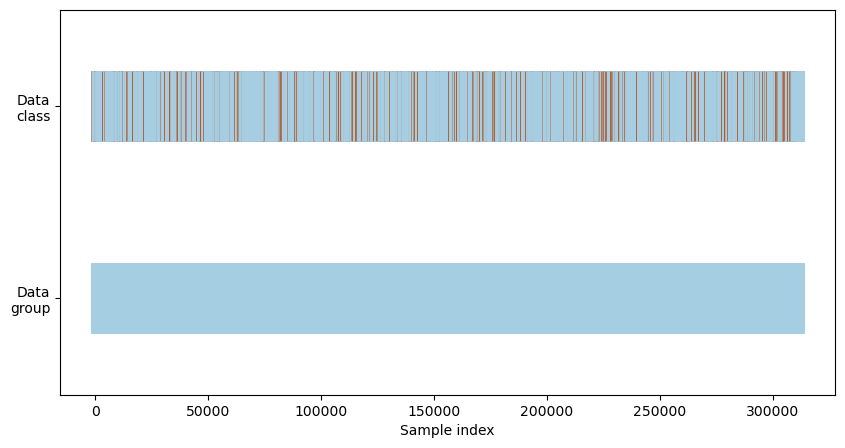

In [84]:
visualize_groups(train_y, groups, "no groups")

In [88]:
n_splits = 5
groups = None

/tmp/ipykernel_4107164/1298143750.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


<Axes: title={'center': 'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

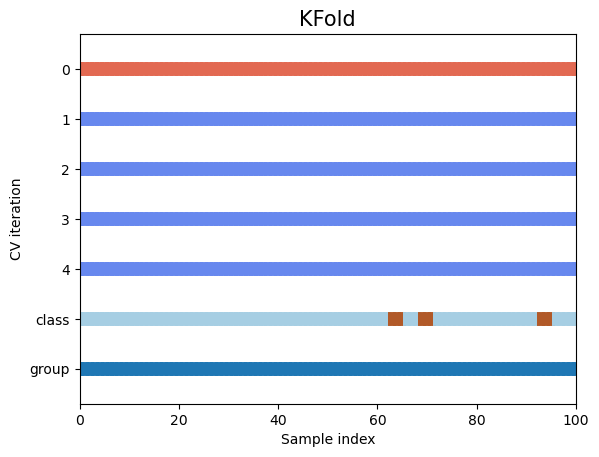

In [89]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, train_X, train_y, groups, ax, n_splits)

### Create balanced datasets

In [635]:
bal_train_X, bal_train_y = balance_datasets(train_X, train_y, ratio = 1)
bal_train_X_2, bal_train_y_2 = balance_datasets(train_X, train_y, ratio = 2)


 Take 12388 samples from total of 12388 negative training samples
 Take 12388 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 37164  Total len: 74328

 X :  Min: -27.6719    Max: 23.7271   Mean: 0.0016  Std: 1.0157
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000

 Take 12388 samples from total of 12388 negative training samples
 Take 24776 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 74328  Total len: 111492

 X :  Min: -27.3326    Max: 26.3826   Mean: 0.0014  Std: 1.0076
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714


In [636]:
bal_test_X, bal_test_y = balance_datasets(test_X, test_y, ratio = 1)
bal_test_X_2, bal_test_y_2 = balance_datasets(test_X, test_y, ratio = 2)


 Take 1388 samples from total of 1388 negative training samples
 Take 1388 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 4164  Total len: 8328

 X :  Min: -16.9431    Max: 19.0416   Mean: 0.0030  Std: 1.0028
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000

 Take 1388 samples from total of 1388 negative training samples
 Take 2776 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 8328  Total len: 12492

 X :  Min: -18.7677    Max: 20.9524   Mean: 0.0015  Std: 0.9780
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714


# **[Logistic Regression Model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)**

Intuitively, the `gamma` parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The `gamma`parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

The `C`parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of `C`, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words`C` behaves as a regularization parameter in the SVM.

## Setup

In [36]:
try:
    del X_DATA, X_TEST, Y_DATA, Y_TEST
except:
    pass
# train_y.head()

In [37]:
X_DATA = df_train_x.iloc[:, 11:]    ## bal_train_X
X_TEST = df_test_x.iloc[:, 11:] 
X_DATA.head()
X_TEST.head()

,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MedianRadius,Cells_AreaShape_MinorAxisLength,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
0,-0.422301,-0.414977,0.296784,0.352499,-0.098035,0.684400,0.087884,0.314826,0.368505,0.557306,...,0.443768,0.062235,-0.648585,0.308744,0.073046,-0.245728,0.099481,-0.107570,-0.558575,0.174041
1,-0.634604,-0.623231,-1.604601,1.556609,1.229354,0.991301,-2.159390,-0.222254,-1.807152,-1.510269,...,1.705322,3.242936,-1.327198,1.111929,2.102121,1.878933,3.540586,2.529848,-1.022145,0.753343
2,0.510761,0.556297,-0.224569,0.064905,-0.326477,-0.091838,-0.289178,-0.276995,-0.439694,-0.303454,...,-0.408875,-0.214203,-0.092149,-0.658746,-0.453523,5.058665,-0.418815,-0.455386,0.699883,-0.680918
3,-1.832139,-1.829487,1.057670,-0.193737,-0.485366,-1.987315,0.516659,-0.306041,-0.054500,-0.082623,...,-0.438654,-0.627846,-0.707734,-0.504685,-0.398547,-0.303720,-0.389571,0.922415,-0.724165,-0.202291
4,-1.167907,-1.244004,0.685477,0.346317,1.788158,-0.596517,-0.806163,0.875543,-0.278969,-0.196213,...,0.683232,-0.350120,0.300466,-0.384838,0.766679,-0.162195,-0.055417,-0.199495,4.481964,-0.165720


,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MedianRadius,Cells_AreaShape_MinorAxisLength,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
0,0.265359,-1.023236,-1.667018,9.516489,3.396944,-4.288098,-4.214914,7.506416,6.678442,6.825577,...,-0.896670,1.450820,1.152851,-1.278530,1.418223,0.021354,-0.141206,0.868969,0.193294,0.005227
1,1.264069,-0.121984,-1.052618,6.685748,3.826743,-8.017166,-3.069860,9.142784,8.169262,8.976429,...,-2.831087,0.228118,-0.683563,-1.849235,-0.919059,0.182213,-0.887957,0.667862,-0.120462,-0.251829
2,2.304297,1.081565,0.205133,7.197979,5.303427,-0.763364,-4.214097,6.840013,6.558799,5.675367,...,-1.743976,1.145396,0.208649,-1.137074,0.149952,0.528899,-0.171473,1.336097,0.096783,0.456798
3,-1.042122,-0.901804,-2.492861,-0.252232,0.901445,-0.774559,-0.725909,-1.602487,-2.909940,-2.597397,...,0.343824,-0.960700,0.310768,-0.827690,0.089760,-0.492758,-0.630063,-0.921455,-0.279790,-0.952676
4,0.282867,0.404944,-1.720918,-0.519097,0.003475,0.583267,1.262719,-1.004806,-1.232853,-1.427747,...,0.164401,-0.457574,0.001981,0.241172,0.594398,0.351269,0.024534,-0.786780,-0.169006,0.893691


In [38]:
Best_Estimators = []
df_metrics = pd.DataFrame()

In [39]:
RANDOM_STATE = 6666
NUM_JOBS = 1
Y_OFFSET = 3
parm_C = 0.025
parm_solver = 'lbfgs'

In [44]:
len(selected_label_indicies), len(bit_counter_pct), len(str_selected_label_indicies), len(selected_label_descriptions)
# Y_column_names = df_train_y.columns.to_list()
# Y_column_names[0]
# Y_column_names[1]
# Y_column_names[2]
# Y_column_names[3]
# selected_label_indicies

(533, 533, 533, 533)

In [45]:
i = 532
FP_BIT = selected_label_indicies[i]
df_col_number = i + Y_OFFSET
print(f" i: {i}  FP Bit: {FP_BIT}, col nbr(w/ offset): {df_col_number}  str_selected_label_indices: {str_selected_label_indicies[i]}")
selected_label_indicies[i], bit_counter_pct[i] , str_selected_label_indicies[i], selected_label_descriptions[i]
df_train_y.iloc[1:10, df_col_number]
df_train_y.loc[:5, str_selected_label_indicies[i]]

 i: 532  FP Bit: 10688, col nbr(w/ offset): 535  str_selected_label_indices: 10688


(10688,
 0.06442640692640693,
 '10688',
 'Hydrophobe LumpedHydrophobe PosIonizable |0 4 4|4 0 4|4 4 0|')

1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: 10688, dtype: int64

0    0
1    0
2    0
3    0
4    0
5    0
Name: 10688, dtype: int64

## Training

In [ ]:
for i in range(len(selected_label_indicies)):
    df_col_number = i + Y_OFFSET
    FP_BIT = selected_label_indicies[i]
    FP_NAME = str_selected_label_indicies[i]
    print(f" Index: {i}  -- FP Bit: {FP_BIT} - Column name: {FP_NAME}")

    Y_DATA = df_train_y.iloc[:, df_col_number]
    Y_TEST = df_test_y.iloc[:, df_col_number]
    logreg = LogisticRegression(penalty = 'l2',
                                C=parm_C,
                                random_state = RANDOM_STATE,
                                max_iter = 5000,
                                tol = 1e-5,
                                n_jobs = 1,
                                class_weight=None,
                                solver = parm_solver,
                                verbose = 0)

    clf = logreg.fit(X_DATA, Y_DATA)
    Y_PRED = clf.predict(X_TEST)
    Y_SCORE = clf.predict_proba(X_TEST)

    compute_metrics(Y_TEST, Y_PRED)
    roc_auc = skm.roc_auc_score(Y_TEST, Y_SCORE[:,1])
    precisions, recalls, f1s, supports = skm.precision_recall_fscore_support(Y_TEST, Y_PRED)
    print(f" roc_auc: {roc_auc:.5f}")

    # reordered_col_names = ['Y_bit','param_C', 'param_solver',  'Y_bit_pct', 'mean_test_score',
    #                        'precision', 'accuracy', 'recall',  'f1', 'std_test_score',
    #                        'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score',
    #                        'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
    #                        'params', 'random_seed']
    _tmp_dict = {'Y_bit'             : FP_BIT,
                 'Y_bit_pct'         : bit_counter_pct[i],
                 'param_C'           : parm_C,
                 'param_solver'      : parm_solver,
                 'mean_test_score'   : roc_auc,
                 'precision'         : precisions[1],
                 'accuracy'          : skm.accuracy_score(Y_TEST, Y_PRED,),
                 'recall'            : recalls[1],
                 'f1'                : f1s[1],
                 'Y_bit_description' : selected_label_descriptions[i],
                 'params'            : "none",
                 'random_seed'       : RANDOM_STATE}
    _tmp_df = pd.DataFrame(_tmp_dict, index = [FP_BIT])
    # _tmp_df

    df_metrics = pd.concat((df_metrics, _tmp_df))
    df_metrics.shape
    df_metrics
    # df_metrics.sort_values('mean_test_score')

    # if i == 5:
    #     print(f" index: {i} FP_BIT: {FP_BIT} -- break")
    #     break

 Index: 0  -- FP Bit: 1 - Column name: 1
Classification Metrics
-----------------------
 Accuracy: 0.90714     Precision: 0.20000     Recall: 0.00086     F1: 0.00171 


 True + labels:          1167     ratio to total:  0.09262
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11430     ratio to total:  0.90714
 roc_auc: 0.55903


(1, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.2,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666


 Index: 1  -- FP Bit: 2 - Column name: 2
Classification Metrics
-----------------------
 Accuracy: 0.55548     Precision: 0.49689     Recall: 0.21482     F1: 0.29996 


 True + labels:          5586     ratio to total:  0.44333
 Predicted + labels:     2415     ratio to total:  0.19167
 True/Predicted Match:   6999     ratio to total:  0.55548
 roc_auc: 0.54812


(2, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666


 Index: 2  -- FP Bit: 3 - Column name: 3
Classification Metrics
-----------------------
 Accuracy: 0.69865     Precision: 0.53226     Recall: 0.00868     F1: 0.01709 


 True + labels:          3801     ratio to total:  0.30167
 Predicted + labels:       62     ratio to total:  0.00492
 True/Predicted Match:   8803     ratio to total:  0.69865
 roc_auc: 0.52159


(3, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666


 Index: 3  -- FP Bit: 6 - Column name: 6
Classification Metrics
-----------------------
 Accuracy: 0.59595     Precision: 0.60082     Recall: 0.96993     F1: 0.74201 


 True + labels:          7548     ratio to total:  0.59905
 Predicted + labels:    12185     ratio to total:  0.96706
 True/Predicted Match:   7509     ratio to total:  0.59595
 roc_auc: 0.55468


(4, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666


 Index: 4  -- FP Bit: 7 - Column name: 7
Classification Metrics
-----------------------
 Accuracy: 0.66532     Precision: 0.66595     Recall: 0.99702     F1: 0.79853 


 True + labels:          8382     ratio to total:  0.66524
 Predicted + labels:    12549     ratio to total:  0.99595
 True/Predicted Match:   8383     ratio to total:  0.66532
 roc_auc: 0.55571


(5, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666


 Index: 5  -- FP Bit: 8 - Column name: 8
Classification Metrics
-----------------------
 Accuracy: 0.57516     Precision: 0.58578     Recall: 0.91338     F1: 0.71379 


 True + labels:          7308     ratio to total:  0.58000
 Predicted + labels:    11395     ratio to total:  0.90437
 True/Predicted Match:   7247     ratio to total:  0.57516
 roc_auc: 0.56098


(6, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666


 Index: 6  -- FP Bit: 12 - Column name: 12
Classification Metrics
-----------------------
 Accuracy: 0.53421     Precision: 0.53124     Recall: 0.68953     F1: 0.60012 


 True + labels:          6387     ratio to total:  0.50690
 Predicted + labels:     8290     ratio to total:  0.65794
 True/Predicted Match:   6731     ratio to total:  0.53421
 roc_auc: 0.54604


(7, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666


 Index: 7  -- FP Bit: 13 - Column name: 13
Classification Metrics
-----------------------
 Accuracy: 0.68317     Precision: 0.50704     Recall: 0.00902     F1: 0.01772 


 True + labels:          3993     ratio to total:  0.31690
 Predicted + labels:       71     ratio to total:  0.00563
 True/Predicted Match:   8608     ratio to total:  0.68317
 roc_auc: 0.54888


(8, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666


 Index: 8  -- FP Bit: 18 - Column name: 18
Classification Metrics
-----------------------
 Accuracy: 0.56865     Precision: 0.57585     Recall: 0.94599     F1: 0.71591 


 True + labels:          7239     ratio to total:  0.57452
 Predicted + labels:    11892     ratio to total:  0.94381
 True/Predicted Match:   7165     ratio to total:  0.56865
 roc_auc: 0.53037


(9, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666


 Index: 9  -- FP Bit: 21 - Column name: 21
Classification Metrics
-----------------------
 Accuracy: 0.55373     Precision: 0.54814     Recall: 0.31468     F1: 0.39983 


 True + labels:          5952     ratio to total:  0.47238
 Predicted + labels:     3417     ratio to total:  0.27119
 True/Predicted Match:   6977     ratio to total:  0.55373
 roc_auc: 0.56831


(10, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 10  -- FP Bit: 22 - Column name: 22
Classification Metrics
-----------------------
 Accuracy: 0.54500     Precision: 0.54522     Recall: 0.53734     F1: 0.54125 


 True + labels:          6294     ratio to total:  0.49952
 Predicted + labels:     6203     ratio to total:  0.49230
 True/Predicted Match:   6867     ratio to total:  0.54500
 roc_auc: 0.56437


(11, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 11  -- FP Bit: 23 - Column name: 23
Classification Metrics
-----------------------
 Accuracy: 0.55984     Precision: 0.54179     Recall: 0.26030     F1: 0.35165 


 True + labels:          5778     ratio to total:  0.45857
 Predicted + labels:     2776     ratio to total:  0.22032
 True/Predicted Match:   7054     ratio to total:  0.55984
 roc_auc: 0.55545


(12, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 12  -- FP Bit: 33 - Column name: 33
Classification Metrics
-----------------------
 Accuracy: 0.90183     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1230     ratio to total:  0.09762
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11363     ratio to total:  0.90183
 roc_auc: 0.57313


(13, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 13  -- FP Bit: 34 - Column name: 34
Classification Metrics
-----------------------
 Accuracy: 0.76762     Precision: 0.67935     Recall: 0.04175     F1: 0.07867 


 True + labels:          2994     ratio to total:  0.23762
 Predicted + labels:      184     ratio to total:  0.01460
 True/Predicted Match:   9672     ratio to total:  0.76762
 roc_auc: 0.61565


(14, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 14  -- FP Bit: 41 - Column name: 41
Classification Metrics
-----------------------
 Accuracy: 0.71135     Precision: 0.51307     Recall: 0.04307     F1: 0.07947 


 True + labels:          3645     ratio to total:  0.28929
 Predicted + labels:      306     ratio to total:  0.02429
 True/Predicted Match:   8963     ratio to total:  0.71135
 roc_auc: 0.59667


(15, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 15  -- FP Bit: 42 - Column name: 42
Classification Metrics
-----------------------
 Accuracy: 0.84254     Precision: 0.30357     Recall: 0.00866     F1: 0.01685 


 True + labels:          1962     ratio to total:  0.15571
 Predicted + labels:       56     ratio to total:  0.00444
 True/Predicted Match:  10616     ratio to total:  0.84254
 roc_auc: 0.57823


(16, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 16  -- FP Bit: 43 - Column name: 43
Classification Metrics
-----------------------
 Accuracy: 0.72667     Precision: 0.54255     Recall: 0.04412     F1: 0.08160 


 True + labels:          3468     ratio to total:  0.27524
 Predicted + labels:      282     ratio to total:  0.02238
 True/Predicted Match:   9156     ratio to total:  0.72667
 roc_auc: 0.61882


(17, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 17  -- FP Bit: 44 - Column name: 44
Classification Metrics
-----------------------
 Accuracy: 0.61603     Precision: 0.62611     Recall: 0.92409     F1: 0.74646 


 True + labels:          7707     ratio to total:  0.61167
 Predicted + labels:    11375     ratio to total:  0.90278
 True/Predicted Match:   7762     ratio to total:  0.61603
 roc_auc: 0.62548


(18, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 18  -- FP Bit: 46 - Column name: 46
Classification Metrics
-----------------------
 Accuracy: 0.70063     Precision: 0.50352     Recall: 0.03789     F1: 0.07048 


 True + labels:          3774     ratio to total:  0.29952
 Predicted + labels:      284     ratio to total:  0.02254
 True/Predicted Match:   8828     ratio to total:  0.70063
 roc_auc: 0.56061


(19, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 19  -- FP Bit: 47 - Column name: 47
Classification Metrics
-----------------------
 Accuracy: 0.52929     Precision: 0.52796     Recall: 0.48480     F1: 0.50546 


 True + labels:          6252     ratio to total:  0.49619
 Predicted + labels:     5741     ratio to total:  0.45563
 True/Predicted Match:   6669     ratio to total:  0.52929
 roc_auc: 0.53433


(20, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 20  -- FP Bit: 48 - Column name: 48
Classification Metrics
-----------------------
 Accuracy: 0.62198     Precision: 0.49784     Recall: 0.04831     F1: 0.08807 


 True + labels:          4761     ratio to total:  0.37786
 Predicted + labels:      462     ratio to total:  0.03667
 True/Predicted Match:   7837     ratio to total:  0.62198
 roc_auc: 0.54599


(21, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 21  -- FP Bit: 51 - Column name: 51
Classification Metrics
-----------------------
 Accuracy: 0.56317     Precision: 0.57218     Recall: 0.39017     F1: 0.46397 


 True + labels:          6105     ratio to total:  0.48452
 Predicted + labels:     4163     ratio to total:  0.33040
 True/Predicted Match:   7096     ratio to total:  0.56317
 roc_auc: 0.57514


(22, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 22  -- FP Bit: 52 - Column name: 52
Classification Metrics
-----------------------
 Accuracy: 0.62238     Precision: 0.53073     Recall: 0.05949     F1: 0.10698 


 True + labels:          4791     ratio to total:  0.38024
 Predicted + labels:      537     ratio to total:  0.04262
 True/Predicted Match:   7842     ratio to total:  0.62238
 roc_auc: 0.54987


(23, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 23  -- FP Bit: 53 - Column name: 53
Classification Metrics
-----------------------
 Accuracy: 0.59825     Precision: 0.60259     Recall: 0.20507     F1: 0.30600 


 True + labels:          5442     ratio to total:  0.43190
 Predicted + labels:     1852     ratio to total:  0.14698
 True/Predicted Match:   7538     ratio to total:  0.59825
 roc_auc: 0.58803


(24, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 24  -- FP Bit: 56 - Column name: 56
Classification Metrics
-----------------------
 Accuracy: 0.70000     Precision: 0.56857     Recall: 0.05199     F1: 0.09526 


 True + labels:          3828     ratio to total:  0.30381
 Predicted + labels:      350     ratio to total:  0.02778
 True/Predicted Match:   8820     ratio to total:  0.70000
 roc_auc: 0.59210


(25, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 25  -- FP Bit: 57 - Column name: 57
Classification Metrics
-----------------------
 Accuracy: 0.84675     Precision: 0.34783     Recall: 0.00835     F1: 0.01630 


 True + labels:          1917     ratio to total:  0.15214
 Predicted + labels:       46     ratio to total:  0.00365
 True/Predicted Match:  10669     ratio to total:  0.84675
 roc_auc: 0.58549


(26, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 26  -- FP Bit: 58 - Column name: 58
Classification Metrics
-----------------------
 Accuracy: 0.73635     Precision: 0.59851     Recall: 0.04770     F1: 0.08836 


 True + labels:          3375     ratio to total:  0.26786
 Predicted + labels:      269     ratio to total:  0.02135
 True/Predicted Match:   9278     ratio to total:  0.73635
 roc_auc: 0.61343


(27, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 27  -- FP Bit: 59 - Column name: 59
Classification Metrics
-----------------------
 Accuracy: 0.63952     Precision: 0.65109     Recall: 0.93744     F1: 0.76845 


 True + labels:          8040     ratio to total:  0.63810
 Predicted + labels:    11576     ratio to total:  0.91873
 True/Predicted Match:   8058     ratio to total:  0.63952
 roc_auc: 0.63360


(28, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 28  -- FP Bit: 67 - Column name: 67
Classification Metrics
-----------------------
 Accuracy: 0.89849     Precision: 0.40000     Recall: 0.00627     F1: 0.01236 


 True + labels:          1275     ratio to total:  0.10119
 Predicted + labels:       20     ratio to total:  0.00159
 True/Predicted Match:  11321     ratio to total:  0.89849
 roc_auc: 0.60313


(29, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 29  -- FP Bit: 69 - Column name: 69
Classification Metrics
-----------------------
 Accuracy: 0.80056     Precision: 0.72892     Recall: 0.04674     F1: 0.08784 


 True + labels:          2589     ratio to total:  0.20548
 Predicted + labels:      166     ratio to total:  0.01317
 True/Predicted Match:  10087     ratio to total:  0.80056
 roc_auc: 0.62060


(30, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 30  -- FP Bit: 76 - Column name: 76
Classification Metrics
-----------------------
 Accuracy: 0.94381     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           705     ratio to total:  0.05595
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11892     ratio to total:  0.94381
 roc_auc: 0.53606


(31, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 31  -- FP Bit: 77 - Column name: 77
Classification Metrics
-----------------------
 Accuracy: 0.86421     Precision: 0.40000     Recall: 0.00117     F1: 0.00233 


 True + labels:          1710     ratio to total:  0.13571
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  10889     ratio to total:  0.86421
 roc_auc: 0.55703


(32, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 32  -- FP Bit: 78 - Column name: 78
Classification Metrics
-----------------------
 Accuracy: 0.85429     Precision: 0.20000     Recall: 0.00055     F1: 0.00109 


 True + labels:          1833     ratio to total:  0.14548
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  10764     ratio to total:  0.85429
 roc_auc: 0.58153


(33, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 33  -- FP Bit: 79 - Column name: 79
Classification Metrics
-----------------------
 Accuracy: 0.65063     Precision: 0.54980     Recall: 0.06199     F1: 0.11143 


 True + labels:          4452     ratio to total:  0.35333
 Predicted + labels:      502     ratio to total:  0.03984
 True/Predicted Match:   8198     ratio to total:  0.65063
 roc_auc: 0.58347


(34, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 34  -- FP Bit: 82 - Column name: 82
Classification Metrics
-----------------------
 Accuracy: 0.63556     Precision: 0.63762     Recall: 0.99153     F1: 0.77613 


 True + labels:          8028     ratio to total:  0.63714
 Predicted + labels:    12484     ratio to total:  0.99079
 True/Predicted Match:   8008     ratio to total:  0.63556
 roc_auc: 0.53915


(35, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 35  -- FP Bit: 83 - Column name: 83
Classification Metrics
-----------------------
 Accuracy: 0.62579     Precision: 0.54494     Recall: 0.02050     F1: 0.03952 


 True + labels:          4731     ratio to total:  0.37548
 Predicted + labels:      178     ratio to total:  0.01413
 True/Predicted Match:   7885     ratio to total:  0.62579
 roc_auc: 0.53266


(36, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 36  -- FP Bit: 86 - Column name: 86
Classification Metrics
-----------------------
 Accuracy: 0.79738     Precision: 0.42574     Recall: 0.01694     F1: 0.03259 


 True + labels:          2538     ratio to total:  0.20143
 Predicted + labels:      101     ratio to total:  0.00802
 True/Predicted Match:  10047     ratio to total:  0.79738
 roc_auc: 0.57018


(37, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 37  -- FP Bit: 87 - Column name: 87
Classification Metrics
-----------------------
 Accuracy: 0.68000     Precision: 0.46809     Recall: 0.01093     F1: 0.02136 


 True + labels:          4026     ratio to total:  0.31952
 Predicted + labels:       94     ratio to total:  0.00746
 True/Predicted Match:   8568     ratio to total:  0.68000
 roc_auc: 0.54729


(38, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 38  -- FP Bit: 88 - Column name: 88
Classification Metrics
-----------------------
 Accuracy: 0.72095     Precision: 0.48485     Recall: 0.01366     F1: 0.02658 


 True + labels:          3513     ratio to total:  0.27881
 Predicted + labels:       99     ratio to total:  0.00786
 True/Predicted Match:   9084     ratio to total:  0.72095
 roc_auc: 0.55328


(39, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 39  -- FP Bit: 89 - Column name: 89
Classification Metrics
-----------------------
 Accuracy: 0.64548     Precision: 0.64764     Recall: 0.98956     F1: 0.78289 


 True + labels:          8139     ratio to total:  0.64595
 Predicted + labels:    12436     ratio to total:  0.98698
 True/Predicted Match:   8133     ratio to total:  0.64548
 roc_auc: 0.56292


(40, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 40  -- FP Bit: 98 - Column name: 98
Classification Metrics
-----------------------
 Accuracy: 0.91190     Precision: 0.12500     Recall: 0.00091     F1: 0.00180 


 True + labels:          1104     ratio to total:  0.08762
 Predicted + labels:        8     ratio to total:  0.00063
 True/Predicted Match:  11490     ratio to total:  0.91190
 roc_auc: 0.60694


(41, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 41  -- FP Bit: 99 - Column name: 99
Classification Metrics
-----------------------
 Accuracy: 0.84079     Precision: 0.54430     Recall: 0.02136     F1: 0.04111 


 True + labels:          2013     ratio to total:  0.15976
 Predicted + labels:       79     ratio to total:  0.00627
 True/Predicted Match:  10594     ratio to total:  0.84079
 roc_auc: 0.61979


(42, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 42  -- FP Bit: 106 - Column name: 106
Classification Metrics
-----------------------
 Accuracy: 0.55786     Precision: 0.54217     Recall: 0.20118     F1: 0.29347 


 True + labels:          5751     ratio to total:  0.45643
 Predicted + labels:     2134     ratio to total:  0.16937
 True/Predicted Match:   7029     ratio to total:  0.55786
 roc_auc: 0.55059


(43, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 43  -- FP Bit: 107 - Column name: 107
Classification Metrics
-----------------------
 Accuracy: 0.61230     Precision: 0.55572     Recall: 0.07739     F1: 0.13586 


 True + labels:          4962     ratio to total:  0.39381
 Predicted + labels:      691     ratio to total:  0.05484
 True/Predicted Match:   7715     ratio to total:  0.61230
 roc_auc: 0.56914


(44, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 44  -- FP Bit: 108 - Column name: 108
Classification Metrics
-----------------------
 Accuracy: 0.73214     Precision: 0.53600     Recall: 0.01980     F1: 0.03819 


 True + labels:          3384     ratio to total:  0.26857
 Predicted + labels:      125     ratio to total:  0.00992
 True/Predicted Match:   9225     ratio to total:  0.73214
 roc_auc: 0.56445


(45, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 45  -- FP Bit: 109 - Column name: 109
Classification Metrics
-----------------------
 Accuracy: 0.63944     Precision: 0.64835     Recall: 0.95643     F1: 0.77282 


 True + labels:          8079     ratio to total:  0.64119
 Predicted + labels:    11918     ratio to total:  0.94587
 True/Predicted Match:   8057     ratio to total:  0.63944
 roc_auc: 0.60603


(46, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 46  -- FP Bit: 111 - Column name: 111
Classification Metrics
-----------------------
 Accuracy: 0.74794     Precision: 0.56098     Recall: 0.01444     F1: 0.02815 


 True + labels:          3186     ratio to total:  0.25286
 Predicted + labels:       82     ratio to total:  0.00651
 True/Predicted Match:   9424     ratio to total:  0.74794
 roc_auc: 0.56991


(47, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 47  -- FP Bit: 112 - Column name: 112
Classification Metrics
-----------------------
 Accuracy: 0.79849     Precision: 0.44118     Recall: 0.00592     F1: 0.01168 


 True + labels:          2535     ratio to total:  0.20119
 Predicted + labels:       34     ratio to total:  0.00270
 True/Predicted Match:  10061     ratio to total:  0.79849
 roc_auc: 0.55952


(48, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 48  -- FP Bit: 113 - Column name: 113
Classification Metrics
-----------------------
 Accuracy: 0.71087     Precision: 0.62460     Recall: 0.05188     F1: 0.09581 


 True + labels:          3720     ratio to total:  0.29524
 Predicted + labels:      309     ratio to total:  0.02452
 True/Predicted Match:   8957     ratio to total:  0.71087
 roc_auc: 0.58390


(49, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 49  -- FP Bit: 114 - Column name: 114
Classification Metrics
-----------------------
 Accuracy: 0.66563     Precision: 0.67673     Recall: 0.95503     F1: 0.79215 


 True + labels:          8406     ratio to total:  0.66714
 Predicted + labels:    11863     ratio to total:  0.94151
 True/Predicted Match:   8387     ratio to total:  0.66563
 roc_auc: 0.63677


(50, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 50  -- FP Bit: 122 - Column name: 122
Classification Metrics
-----------------------
 Accuracy: 0.85841     Precision: 0.58065     Recall: 0.02007     F1: 0.03879 


 True + labels:          1794     ratio to total:  0.14238
 Predicted + labels:       62     ratio to total:  0.00492
 True/Predicted Match:  10816     ratio to total:  0.85841
 roc_auc: 0.60078


(51, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 51  -- FP Bit: 123 - Column name: 123
Classification Metrics
-----------------------
 Accuracy: 0.92802     Precision: 0.66667     Recall: 0.01096     F1: 0.02157 


 True + labels:           912     ratio to total:  0.07238
 Predicted + labels:       15     ratio to total:  0.00119
 True/Predicted Match:  11693     ratio to total:  0.92802
 roc_auc: 0.60161


(52, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 52  -- FP Bit: 124 - Column name: 124
Classification Metrics
-----------------------
 Accuracy: 0.80730     Precision: 0.72561     Recall: 0.04756     F1: 0.08927 


 True + labels:          2502     ratio to total:  0.19857
 Predicted + labels:      164     ratio to total:  0.01302
 True/Predicted Match:  10172     ratio to total:  0.80730
 roc_auc: 0.61037


(53, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 53  -- FP Bit: 131 - Column name: 131
Classification Metrics
-----------------------
 Accuracy: 0.94230     Precision: 0.66667     Recall: 0.00549     F1: 0.01088 


 True + labels:           729     ratio to total:  0.05786
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11873     ratio to total:  0.94230
 roc_auc: 0.59775


(54, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 54  -- FP Bit: 133 - Column name: 133
Classification Metrics
-----------------------
 Accuracy: 0.88286     Precision: 0.17857     Recall: 0.00343     F1: 0.00673 


 True + labels:          1458     ratio to total:  0.11571
 Predicted + labels:       28     ratio to total:  0.00222
 True/Predicted Match:  11124     ratio to total:  0.88286
 roc_auc: 0.60588


(55, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 55  -- FP Bit: 134 - Column name: 134
Classification Metrics
-----------------------
 Accuracy: 0.64556     Precision: 0.60307     Recall: 0.28606     F1: 0.38805 


 True + labels:          4950     ratio to total:  0.39286
 Predicted + labels:     2348     ratio to total:  0.18635
 True/Predicted Match:   8134     ratio to total:  0.64556
 roc_auc: 0.64345


(56, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 56  -- FP Bit: 142 - Column name: 142
Classification Metrics
-----------------------
 Accuracy: 0.93984     Precision: 0.40000     Recall: 0.00529     F1: 0.01044 


 True + labels:           756     ratio to total:  0.06000
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  11842     ratio to total:  0.93984
 roc_auc: 0.61005


(57, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 57  -- FP Bit: 144 - Column name: 144
Classification Metrics
-----------------------
 Accuracy: 0.82968     Precision: 0.68531     Recall: 0.04457     F1: 0.08369 


 True + labels:          2199     ratio to total:  0.17452
 Predicted + labels:      143     ratio to total:  0.01135
 True/Predicted Match:  10454     ratio to total:  0.82968
 roc_auc: 0.62198


(58, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 58  -- FP Bit: 286 - Column name: 286
Classification Metrics
-----------------------
 Accuracy: 0.95222     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           600     ratio to total:  0.04762
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11998     ratio to total:  0.95222
 roc_auc: 0.53585


(59, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 59  -- FP Bit: 289 - Column name: 289
Classification Metrics
-----------------------
 Accuracy: 0.91516     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1065     ratio to total:  0.08452
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11531     ratio to total:  0.91516
 roc_auc: 0.55413


(60, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
8,8,0.575801,0.025,lbfgs,0.560982,0.585783,0.575159,0.913383,0.713789,Acceptor Aromatic |0 3|3 0|,none,6666
12,12,0.515574,0.025,lbfgs,0.546042,0.531242,0.534206,0.689526,0.600123,Acceptor Donor |0 2|2 0|,none,6666
13,13,0.326115,0.025,lbfgs,0.548877,0.507042,0.683175,0.009016,0.017717,Acceptor Donor |0 3|3 0|,none,6666
18,18,0.570574,0.025,lbfgs,0.530373,0.575849,0.568651,0.945987,0.715906,Acceptor Hydrophobe |0 3|3 0|,none,6666
21,21,0.467186,0.025,lbfgs,0.568314,0.548142,0.553730,0.314684,0.399829,Acceptor LumpedHydrophobe |0 1|1 0|,none,6666


 Index: 60  -- FP Bit: 290 - Column name: 290
Classification Metrics
-----------------------
 Accuracy: 0.59206     Precision: 0.43106     Recall: 0.04880     F1: 0.08768 


 True + labels:          5061     ratio to total:  0.40167
 Predicted + labels:      573     ratio to total:  0.04548
 True/Predicted Match:   7460     ratio to total:  0.59206
 roc_auc: 0.53932


(61, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
142,142,0.067522,0.025,lbfgs,0.610048,0.400000,0.939841,0.005291,0.010444,LumpedHydrophobe PosIonizable |0 2|2 0|,none,6666
144,144,0.172738,0.025,lbfgs,0.621980,0.685315,0.829683,0.044566,0.083689,LumpedHydrophobe PosIonizable |0 4|4 0|,none,6666
286,286,0.053918,0.025,lbfgs,0.535849,0.000000,0.952222,0.000000,0.000000,Acceptor Acceptor Acceptor |0 4 3|4 0 3|3 3 0|,none,6666
289,289,0.087619,0.025,lbfgs,0.554134,0.000000,0.915159,0.000000,0.000000,Acceptor Acceptor Acceptor |0 4 4|4 0 1|4 1 0|,none,6666


 Index: 61  -- FP Bit: 291 - Column name: 291
Classification Metrics
-----------------------
 Accuracy: 0.73841     Precision: 0.51064     Recall: 0.00728     F1: 0.01435 


 True + labels:          3297     ratio to total:  0.26167
 Predicted + labels:       47     ratio to total:  0.00373
 True/Predicted Match:   9304     ratio to total:  0.73841
 roc_auc: 0.52842


(62, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
144,144,0.172738,0.025,lbfgs,0.621980,0.685315,0.829683,0.044566,0.083689,LumpedHydrophobe PosIonizable |0 4|4 0|,none,6666
286,286,0.053918,0.025,lbfgs,0.535849,0.000000,0.952222,0.000000,0.000000,Acceptor Acceptor Acceptor |0 4 3|4 0 3|3 3 0|,none,6666
289,289,0.087619,0.025,lbfgs,0.554134,0.000000,0.915159,0.000000,0.000000,Acceptor Acceptor Acceptor |0 4 4|4 0 1|4 1 0|,none,6666
290,290,0.415206,0.025,lbfgs,0.539323,0.431065,0.592063,0.048805,0.087682,Acceptor Acceptor Acceptor |0 4 4|4 0 2|4 2 0|,none,6666


 Index: 62  -- FP Bit: 292 - Column name: 292
Classification Metrics
-----------------------
 Accuracy: 0.55317     Precision: 0.55631     Recall: 0.82141     F1: 0.66336 


 True + labels:          6753     ratio to total:  0.53595
 Predicted + labels:     9971     ratio to total:  0.79135
 True/Predicted Match:   6970     ratio to total:  0.55317
 roc_auc: 0.55641


(63, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
286,286,0.053918,0.025,lbfgs,0.535849,0.000000,0.952222,0.000000,0.000000,Acceptor Acceptor Acceptor |0 4 3|4 0 3|3 3 0|,none,6666
289,289,0.087619,0.025,lbfgs,0.554134,0.000000,0.915159,0.000000,0.000000,Acceptor Acceptor Acceptor |0 4 4|4 0 1|4 1 0|,none,6666
290,290,0.415206,0.025,lbfgs,0.539323,0.431065,0.592063,0.048805,0.087682,Acceptor Acceptor Acceptor |0 4 4|4 0 2|4 2 0|,none,6666
291,291,0.271894,0.025,lbfgs,0.528416,0.510638,0.738413,0.007279,0.014354,Acceptor Acceptor Acceptor |0 4 4|4 0 3|4 3 0|,none,6666


 Index: 63  -- FP Bit: 334 - Column name: 334
Classification Metrics
-----------------------
 Accuracy: 0.92675     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           918     ratio to total:  0.07286
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11677     ratio to total:  0.92675
 roc_auc: 0.53551


(64, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
289,289,0.087619,0.025,lbfgs,0.554134,0.000000,0.915159,0.000000,0.000000,Acceptor Acceptor Acceptor |0 4 4|4 0 1|4 1 0|,none,6666
290,290,0.415206,0.025,lbfgs,0.539323,0.431065,0.592063,0.048805,0.087682,Acceptor Acceptor Acceptor |0 4 4|4 0 2|4 2 0|,none,6666
291,291,0.271894,0.025,lbfgs,0.528416,0.510638,0.738413,0.007279,0.014354,Acceptor Acceptor Acceptor |0 4 4|4 0 3|4 3 0|,none,6666
292,292,0.543972,0.025,lbfgs,0.556415,0.556313,0.553175,0.821413,0.663358,Acceptor Acceptor Acceptor |0 4 4|4 0 4|4 4 0|,none,6666


 Index: 64  -- FP Bit: 347 - Column name: 347
Classification Metrics
-----------------------
 Accuracy: 0.78778     Precision: 0.29412     Recall: 0.00187     F1: 0.00373 


 True + labels:          2667     ratio to total:  0.21167
 Predicted + labels:       17     ratio to total:  0.00135
 True/Predicted Match:   9926     ratio to total:  0.78778
 roc_auc: 0.55140


(65, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
290,290,0.415206,0.025,lbfgs,0.539323,0.431065,0.592063,0.048805,0.087682,Acceptor Acceptor Acceptor |0 4 4|4 0 2|4 2 0|,none,6666
291,291,0.271894,0.025,lbfgs,0.528416,0.510638,0.738413,0.007279,0.014354,Acceptor Acceptor Acceptor |0 4 4|4 0 3|4 3 0|,none,6666
292,292,0.543972,0.025,lbfgs,0.556415,0.556313,0.553175,0.821413,0.663358,Acceptor Acceptor Acceptor |0 4 4|4 0 4|4 4 0|,none,6666
334,334,0.077771,0.025,lbfgs,0.535507,0.000000,0.926746,0.000000,0.000000,Acceptor Acceptor Aromatic |0 1 4|1 0 4|4 4 0|,none,6666


 Index: 65  -- FP Bit: 353 - Column name: 353
Classification Metrics
-----------------------
 Accuracy: 0.91762     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1035     ratio to total:  0.08214
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11562     ratio to total:  0.91762
 roc_auc: 0.54018


(66, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
291,291,0.271894,0.025,lbfgs,0.528416,0.510638,0.738413,0.007279,0.014354,Acceptor Acceptor Acceptor |0 4 4|4 0 3|4 3 0|,none,6666
292,292,0.543972,0.025,lbfgs,0.556415,0.556313,0.553175,0.821413,0.663358,Acceptor Acceptor Acceptor |0 4 4|4 0 4|4 4 0|,none,6666
334,334,0.077771,0.025,lbfgs,0.535507,0.000000,0.926746,0.000000,0.000000,Acceptor Acceptor Aromatic |0 1 4|1 0 4|4 4 0|,none,6666
347,347,0.215476,0.025,lbfgs,0.551400,0.294118,0.787778,0.001875,0.003726,Acceptor Acceptor Aromatic |0 2 2|2 0 2|2 2 0|,none,6666


 Index: 66  -- FP Bit: 359 - Column name: 359
Classification Metrics
-----------------------
 Accuracy: 0.64079     Precision: 0.42391     Recall: 0.00864     F1: 0.01694 


 True + labels:          4512     ratio to total:  0.35810
 Predicted + labels:       92     ratio to total:  0.00730
 True/Predicted Match:   8074     ratio to total:  0.64079
 roc_auc: 0.53307


(67, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
292,292,0.543972,0.025,lbfgs,0.556415,0.556313,0.553175,0.821413,0.663358,Acceptor Acceptor Acceptor |0 4 4|4 0 4|4 4 0|,none,6666
334,334,0.077771,0.025,lbfgs,0.535507,0.000000,0.926746,0.000000,0.000000,Acceptor Acceptor Aromatic |0 1 4|1 0 4|4 4 0|,none,6666
347,347,0.215476,0.025,lbfgs,0.551400,0.294118,0.787778,0.001875,0.003726,Acceptor Acceptor Aromatic |0 2 2|2 0 2|2 2 0|,none,6666
353,353,0.079794,0.025,lbfgs,0.540181,0.000000,0.917619,0.000000,0.000000,Acceptor Acceptor Aromatic |0 2 3|2 0 3|3 3 0|,none,6666


 Index: 67  -- FP Bit: 365 - Column name: 365
Classification Metrics
-----------------------
 Accuracy: 0.91135     Precision: 0.75000     Recall: 0.00268     F1: 0.00534 


 True + labels:          1119     ratio to total:  0.08881
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11483     ratio to total:  0.91135
 roc_auc: 0.53346


(68, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
334,334,0.077771,0.025,lbfgs,0.535507,0.000000,0.926746,0.000000,0.000000,Acceptor Acceptor Aromatic |0 1 4|1 0 4|4 4 0|,none,6666
347,347,0.215476,0.025,lbfgs,0.551400,0.294118,0.787778,0.001875,0.003726,Acceptor Acceptor Aromatic |0 2 2|2 0 2|2 2 0|,none,6666
353,353,0.079794,0.025,lbfgs,0.540181,0.000000,0.917619,0.000000,0.000000,Acceptor Acceptor Aromatic |0 2 3|2 0 3|3 3 0|,none,6666
359,359,0.365000,0.025,lbfgs,0.533066,0.423913,0.640794,0.008644,0.016942,Acceptor Acceptor Aromatic |0 2 4|2 0 4|4 4 0|,none,6666


 Index: 68  -- FP Bit: 380 - Column name: 380
Classification Metrics
-----------------------
 Accuracy: 0.94246     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           723     ratio to total:  0.05738
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11875     ratio to total:  0.94246
 roc_auc: 0.50969


(69, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
347,347,0.215476,0.025,lbfgs,0.551400,0.294118,0.787778,0.001875,0.003726,Acceptor Acceptor Aromatic |0 2 2|2 0 2|2 2 0|,none,6666
353,353,0.079794,0.025,lbfgs,0.540181,0.000000,0.917619,0.000000,0.000000,Acceptor Acceptor Aromatic |0 2 3|2 0 3|3 3 0|,none,6666
359,359,0.365000,0.025,lbfgs,0.533066,0.423913,0.640794,0.008644,0.016942,Acceptor Acceptor Aromatic |0 2 4|2 0 4|4 4 0|,none,6666
365,365,0.082262,0.025,lbfgs,0.533460,0.750000,0.911349,0.002681,0.005343,Acceptor Acceptor Aromatic |0 3 1|3 0 1|1 1 0|,none,6666


 Index: 69  -- FP Bit: 381 - Column name: 381
Classification Metrics
-----------------------
 Accuracy: 0.94262     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           717     ratio to total:  0.05690
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11877     ratio to total:  0.94262
 roc_auc: 0.54253


(70, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
353,353,0.079794,0.025,lbfgs,0.540181,0.000000,0.917619,0.000000,0.000000,Acceptor Acceptor Aromatic |0 2 3|2 0 3|3 3 0|,none,6666
359,359,0.365000,0.025,lbfgs,0.533066,0.423913,0.640794,0.008644,0.016942,Acceptor Acceptor Aromatic |0 2 4|2 0 4|4 4 0|,none,6666
365,365,0.082262,0.025,lbfgs,0.533460,0.750000,0.911349,0.002681,0.005343,Acceptor Acceptor Aromatic |0 3 1|3 0 1|1 1 0|,none,6666
380,380,0.058701,0.025,lbfgs,0.509695,0.000000,0.942460,0.000000,0.000000,Acceptor Acceptor Aromatic |0 3 4|3 0 1|4 1 0|,none,6666


 Index: 70  -- FP Bit: 382 - Column name: 382
Classification Metrics
-----------------------
 Accuracy: 0.92722     Precision: 0.25000     Recall: 0.00109     F1: 0.00218 


 True + labels:           915     ratio to total:  0.07262
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11683     ratio to total:  0.92722
 roc_auc: 0.52317


(71, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
359,359,0.365000,0.025,lbfgs,0.533066,0.423913,0.640794,0.008644,0.016942,Acceptor Acceptor Aromatic |0 2 4|2 0 4|4 4 0|,none,6666
365,365,0.082262,0.025,lbfgs,0.533460,0.750000,0.911349,0.002681,0.005343,Acceptor Acceptor Aromatic |0 3 1|3 0 1|1 1 0|,none,6666
380,380,0.058701,0.025,lbfgs,0.509695,0.000000,0.942460,0.000000,0.000000,Acceptor Acceptor Aromatic |0 3 4|3 0 1|4 1 0|,none,6666
381,381,0.055465,0.025,lbfgs,0.542530,0.000000,0.942619,0.000000,0.000000,Acceptor Acceptor Aromatic |0 3 4|3 0 2|4 2 0|,none,6666


 Index: 71  -- FP Bit: 383 - Column name: 383
Classification Metrics
-----------------------
 Accuracy: 0.77833     Precision: 0.50000     Recall: 0.00537     F1: 0.01063 


 True + labels:          2793     ratio to total:  0.22167
 Predicted + labels:       30     ratio to total:  0.00238
 True/Predicted Match:   9807     ratio to total:  0.77833
 roc_auc: 0.52662


(72, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
365,365,0.082262,0.025,lbfgs,0.533460,0.750000,0.911349,0.002681,0.005343,Acceptor Acceptor Aromatic |0 3 1|3 0 1|1 1 0|,none,6666
380,380,0.058701,0.025,lbfgs,0.509695,0.000000,0.942460,0.000000,0.000000,Acceptor Acceptor Aromatic |0 3 4|3 0 1|4 1 0|,none,6666
381,381,0.055465,0.025,lbfgs,0.542530,0.000000,0.942619,0.000000,0.000000,Acceptor Acceptor Aromatic |0 3 4|3 0 2|4 2 0|,none,6666
382,382,0.077240,0.025,lbfgs,0.523167,0.250000,0.927222,0.001093,0.002176,Acceptor Acceptor Aromatic |0 3 4|3 0 3|4 3 0|,none,6666


 Index: 72  -- FP Bit: 387 - Column name: 387
Classification Metrics
-----------------------
 Accuracy: 0.90175     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1236     ratio to total:  0.09810
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11362     ratio to total:  0.90175
 roc_auc: 0.52497


(73, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
380,380,0.058701,0.025,lbfgs,0.509695,0.000000,0.942460,0.000000,0.000000,Acceptor Acceptor Aromatic |0 3 4|3 0 1|4 1 0|,none,6666
381,381,0.055465,0.025,lbfgs,0.542530,0.000000,0.942619,0.000000,0.000000,Acceptor Acceptor Aromatic |0 3 4|3 0 2|4 2 0|,none,6666
382,382,0.077240,0.025,lbfgs,0.523167,0.250000,0.927222,0.001093,0.002176,Acceptor Acceptor Aromatic |0 3 4|3 0 3|4 3 0|,none,6666
383,383,0.224113,0.025,lbfgs,0.526617,0.500000,0.778333,0.005371,0.010627,Acceptor Acceptor Aromatic |0 3 4|3 0 4|4 4 0|,none,6666


 Index: 73  -- FP Bit: 392 - Column name: 392
Classification Metrics
-----------------------
 Accuracy: 0.77516     Precision: 0.37037     Recall: 0.00354     F1: 0.00701 


 True + labels:          2826     ratio to total:  0.22429
 Predicted + labels:       27     ratio to total:  0.00214
 True/Predicted Match:   9767     ratio to total:  0.77516
 roc_auc: 0.54151


(74, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
381,381,0.055465,0.025,lbfgs,0.542530,0.000000,0.942619,0.000000,0.000000,Acceptor Acceptor Aromatic |0 3 4|3 0 2|4 2 0|,none,6666
382,382,0.077240,0.025,lbfgs,0.523167,0.250000,0.927222,0.001093,0.002176,Acceptor Acceptor Aromatic |0 3 4|3 0 3|4 3 0|,none,6666
383,383,0.224113,0.025,lbfgs,0.526617,0.500000,0.778333,0.005371,0.010627,Acceptor Acceptor Aromatic |0 3 4|3 0 4|4 4 0|,none,6666
387,387,0.098745,0.025,lbfgs,0.524971,0.000000,0.901746,0.000000,0.000000,Acceptor Acceptor Aromatic |0 4 1|4 0 1|1 1 0|,none,6666


 Index: 74  -- FP Bit: 393 - Column name: 393
Classification Metrics
-----------------------
 Accuracy: 0.92254     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           969     ratio to total:  0.07690
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11624     ratio to total:  0.92254
 roc_auc: 0.51292


(75, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
382,382,0.077240,0.025,lbfgs,0.523167,0.250000,0.927222,0.001093,0.002176,Acceptor Acceptor Aromatic |0 3 4|3 0 3|4 3 0|,none,6666
383,383,0.224113,0.025,lbfgs,0.526617,0.500000,0.778333,0.005371,0.010627,Acceptor Acceptor Aromatic |0 3 4|3 0 4|4 4 0|,none,6666
387,387,0.098745,0.025,lbfgs,0.524971,0.000000,0.901746,0.000000,0.000000,Acceptor Acceptor Aromatic |0 4 1|4 0 1|1 1 0|,none,6666
392,392,0.223474,0.025,lbfgs,0.541506,0.370370,0.775159,0.003539,0.007010,Acceptor Acceptor Aromatic |0 4 2|4 0 1|2 1 0|,none,6666


 Index: 75  -- FP Bit: 397 - Column name: 397
Classification Metrics
-----------------------
 Accuracy: 0.79500     Precision: 0.32000     Recall: 0.00311     F1: 0.00616 


 True + labels:          2574     ratio to total:  0.20429
 Predicted + labels:       25     ratio to total:  0.00198
 True/Predicted Match:  10017     ratio to total:  0.79500
 roc_auc: 0.54392


(76, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
383,383,0.224113,0.025,lbfgs,0.526617,0.500000,0.778333,0.005371,0.010627,Acceptor Acceptor Aromatic |0 3 4|3 0 4|4 4 0|,none,6666
387,387,0.098745,0.025,lbfgs,0.524971,0.000000,0.901746,0.000000,0.000000,Acceptor Acceptor Aromatic |0 4 1|4 0 1|1 1 0|,none,6666
392,392,0.223474,0.025,lbfgs,0.541506,0.370370,0.775159,0.003539,0.007010,Acceptor Acceptor Aromatic |0 4 2|4 0 1|2 1 0|,none,6666
393,393,0.082413,0.025,lbfgs,0.512922,0.000000,0.922540,0.000000,0.000000,Acceptor Acceptor Aromatic |0 4 2|4 0 2|2 2 0|,none,6666


 Index: 76  -- FP Bit: 398 - Column name: 398
Classification Metrics
-----------------------
 Accuracy: 0.85175     Precision: 0.36842     Recall: 0.00376     F1: 0.00744 


 True + labels:          1863     ratio to total:  0.14786
 Predicted + labels:       19     ratio to total:  0.00151
 True/Predicted Match:  10732     ratio to total:  0.85175
 roc_auc: 0.53249


(77, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
387,387,0.098745,0.025,lbfgs,0.524971,0.000000,0.901746,0.000000,0.000000,Acceptor Acceptor Aromatic |0 4 1|4 0 1|1 1 0|,none,6666
392,392,0.223474,0.025,lbfgs,0.541506,0.370370,0.775159,0.003539,0.007010,Acceptor Acceptor Aromatic |0 4 2|4 0 1|2 1 0|,none,6666
393,393,0.082413,0.025,lbfgs,0.512922,0.000000,0.922540,0.000000,0.000000,Acceptor Acceptor Aromatic |0 4 2|4 0 2|2 2 0|,none,6666
397,397,0.203690,0.025,lbfgs,0.543919,0.320000,0.795000,0.003108,0.006156,Acceptor Acceptor Aromatic |0 4 3|4 0 1|3 1 0|,none,6666


 Index: 77  -- FP Bit: 399 - Column name: 399
Classification Metrics
-----------------------
 Accuracy: 0.94206     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           729     ratio to total:  0.05786
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11870     ratio to total:  0.94206
 roc_auc: 0.52238


(78, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
392,392,0.223474,0.025,lbfgs,0.541506,0.370370,0.775159,0.003539,0.007010,Acceptor Acceptor Aromatic |0 4 2|4 0 1|2 1 0|,none,6666
393,393,0.082413,0.025,lbfgs,0.512922,0.000000,0.922540,0.000000,0.000000,Acceptor Acceptor Aromatic |0 4 2|4 0 2|2 2 0|,none,6666
397,397,0.203690,0.025,lbfgs,0.543919,0.320000,0.795000,0.003108,0.006156,Acceptor Acceptor Aromatic |0 4 3|4 0 1|3 1 0|,none,6666
398,398,0.147035,0.025,lbfgs,0.532487,0.368421,0.851746,0.003757,0.007439,Acceptor Acceptor Aromatic |0 4 3|4 0 2|3 2 0|,none,6666


 Index: 78  -- FP Bit: 402 - Column name: 402
Classification Metrics
-----------------------
 Accuracy: 0.54476     Precision: 0.53133     Recall: 0.43750     F1: 0.47987 


 True + labels:          6048     ratio to total:  0.48000
 Predicted + labels:     4980     ratio to total:  0.39524
 True/Predicted Match:   6864     ratio to total:  0.54476
 roc_auc: 0.55677


(79, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
393,393,0.082413,0.025,lbfgs,0.512922,0.000000,0.922540,0.000000,0.000000,Acceptor Acceptor Aromatic |0 4 2|4 0 2|2 2 0|,none,6666
397,397,0.203690,0.025,lbfgs,0.543919,0.320000,0.795000,0.003108,0.006156,Acceptor Acceptor Aromatic |0 4 3|4 0 1|3 1 0|,none,6666
398,398,0.147035,0.025,lbfgs,0.532487,0.368421,0.851746,0.003757,0.007439,Acceptor Acceptor Aromatic |0 4 3|4 0 2|3 2 0|,none,6666
399,399,0.058182,0.025,lbfgs,0.522383,0.000000,0.942063,0.000000,0.000000,Acceptor Acceptor Aromatic |0 4 3|4 0 3|3 3 0|,none,6666


 Index: 79  -- FP Bit: 403 - Column name: 403
Classification Metrics
-----------------------
 Accuracy: 0.54429     Precision: 0.55201     Recall: 0.72946     F1: 0.62845 


 True + labels:          6657     ratio to total:  0.52833
 Predicted + labels:     8797     ratio to total:  0.69817
 True/Predicted Match:   6858     ratio to total:  0.54429
 roc_auc: 0.55962


(80, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
397,397,0.203690,0.025,lbfgs,0.543919,0.320000,0.795000,0.003108,0.006156,Acceptor Acceptor Aromatic |0 4 3|4 0 1|3 1 0|,none,6666
398,398,0.147035,0.025,lbfgs,0.532487,0.368421,0.851746,0.003757,0.007439,Acceptor Acceptor Aromatic |0 4 3|4 0 2|3 2 0|,none,6666
399,399,0.058182,0.025,lbfgs,0.522383,0.000000,0.942063,0.000000,0.000000,Acceptor Acceptor Aromatic |0 4 3|4 0 3|3 3 0|,none,6666
402,402,0.489275,0.025,lbfgs,0.556771,0.531325,0.544762,0.437500,0.479869,Acceptor Acceptor Aromatic |0 4 4|4 0 1|4 1 0|,none,6666


 Index: 80  -- FP Bit: 404 - Column name: 404
Classification Metrics
-----------------------
 Accuracy: 0.56873     Precision: 0.53286     Recall: 0.21637     F1: 0.30777 


 True + labels:          5583     ratio to total:  0.44310
 Predicted + labels:     2267     ratio to total:  0.17992
 True/Predicted Match:   7166     ratio to total:  0.56873
 roc_auc: 0.55543


(81, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
398,398,0.147035,0.025,lbfgs,0.532487,0.368421,0.851746,0.003757,0.007439,Acceptor Acceptor Aromatic |0 4 3|4 0 2|3 2 0|,none,6666
399,399,0.058182,0.025,lbfgs,0.522383,0.000000,0.942063,0.000000,0.000000,Acceptor Acceptor Aromatic |0 4 3|4 0 3|3 3 0|,none,6666
402,402,0.489275,0.025,lbfgs,0.556771,0.531325,0.544762,0.437500,0.479869,Acceptor Acceptor Aromatic |0 4 4|4 0 1|4 1 0|,none,6666
403,403,0.529870,0.025,lbfgs,0.559617,0.552006,0.544286,0.729458,0.628446,Acceptor Acceptor Aromatic |0 4 4|4 0 2|4 2 0|,none,6666


 Index: 81  -- FP Bit: 405 - Column name: 405
Classification Metrics
-----------------------
 Accuracy: 0.60214     Precision: 0.60809     Recall: 0.96166     F1: 0.74505 


 True + labels:          7617     ratio to total:  0.60452
 Predicted + labels:    12046     ratio to total:  0.95603
 True/Predicted Match:   7587     ratio to total:  0.60214
 roc_auc: 0.56935


(82, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
399,399,0.058182,0.025,lbfgs,0.522383,0.000000,0.942063,0.000000,0.000000,Acceptor Acceptor Aromatic |0 4 3|4 0 3|3 3 0|,none,6666
402,402,0.489275,0.025,lbfgs,0.556771,0.531325,0.544762,0.437500,0.479869,Acceptor Acceptor Aromatic |0 4 4|4 0 1|4 1 0|,none,6666
403,403,0.529870,0.025,lbfgs,0.559617,0.552006,0.544286,0.729458,0.628446,Acceptor Acceptor Aromatic |0 4 4|4 0 2|4 2 0|,none,6666
404,404,0.448344,0.025,lbfgs,0.555432,0.532863,0.568730,0.216371,0.307771,Acceptor Acceptor Aromatic |0 4 4|4 0 3|4 3 0|,none,6666


 Index: 82  -- FP Bit: 447 - Column name: 447
Classification Metrics
-----------------------
 Accuracy: 0.94437     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           699     ratio to total:  0.05548
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11899     ratio to total:  0.94437
 roc_auc: 0.55335


(83, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
402,402,0.489275,0.025,lbfgs,0.556771,0.531325,0.544762,0.437500,0.479869,Acceptor Acceptor Aromatic |0 4 4|4 0 1|4 1 0|,none,6666
403,403,0.529870,0.025,lbfgs,0.559617,0.552006,0.544286,0.729458,0.628446,Acceptor Acceptor Aromatic |0 4 4|4 0 2|4 2 0|,none,6666
404,404,0.448344,0.025,lbfgs,0.555432,0.532863,0.568730,0.216371,0.307771,Acceptor Acceptor Aromatic |0 4 4|4 0 3|4 3 0|,none,6666
405,405,0.612251,0.025,lbfgs,0.569354,0.608086,0.602143,0.961665,0.745054,Acceptor Acceptor Aromatic |0 4 4|4 0 4|4 4 0|,none,6666


 Index: 83  -- FP Bit: 460 - Column name: 460
Classification Metrics
-----------------------
 Accuracy: 0.91897     Precision: 0.16667     Recall: 0.00098     F1: 0.00196 


 True + labels:          1017     ratio to total:  0.08071
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11579     ratio to total:  0.91897
 roc_auc: 0.54889


(84, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
403,403,0.529870,0.025,lbfgs,0.559617,0.552006,0.544286,0.729458,0.628446,Acceptor Acceptor Aromatic |0 4 4|4 0 2|4 2 0|,none,6666
404,404,0.448344,0.025,lbfgs,0.555432,0.532863,0.568730,0.216371,0.307771,Acceptor Acceptor Aromatic |0 4 4|4 0 3|4 3 0|,none,6666
405,405,0.612251,0.025,lbfgs,0.569354,0.608086,0.602143,0.961665,0.745054,Acceptor Acceptor Aromatic |0 4 4|4 0 4|4 4 0|,none,6666
447,447,0.061613,0.025,lbfgs,0.553352,0.000000,0.944365,0.000000,0.000000,Acceptor Acceptor Donor |0 1 4|1 0 4|4 4 0|,none,6666


 Index: 84  -- FP Bit: 472 - Column name: 472
Classification Metrics
-----------------------
 Accuracy: 0.69246     Precision: 0.25000     Recall: 0.00259     F1: 0.00513 


 True + labels:          3855     ratio to total:  0.30595
 Predicted + labels:       40     ratio to total:  0.00317
 True/Predicted Match:   8725     ratio to total:  0.69246
 roc_auc: 0.54297


(85, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
404,404,0.448344,0.025,lbfgs,0.555432,0.532863,0.568730,0.216371,0.307771,Acceptor Acceptor Aromatic |0 4 4|4 0 3|4 3 0|,none,6666
405,405,0.612251,0.025,lbfgs,0.569354,0.608086,0.602143,0.961665,0.745054,Acceptor Acceptor Aromatic |0 4 4|4 0 4|4 4 0|,none,6666
447,447,0.061613,0.025,lbfgs,0.553352,0.000000,0.944365,0.000000,0.000000,Acceptor Acceptor Donor |0 1 4|1 0 4|4 4 0|,none,6666
460,460,0.082500,0.025,lbfgs,0.548893,0.166667,0.918968,0.000983,0.001955,Acceptor Acceptor Donor |0 2 2|2 0 2|2 2 0|,none,6666


 Index: 85  -- FP Bit: 489 - Column name: 489
Classification Metrics
-----------------------
 Accuracy: 0.92714     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           918     ratio to total:  0.07286
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11682     ratio to total:  0.92714
 roc_auc: 0.53040


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(86, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
405,405,0.612251,0.025,lbfgs,0.569354,0.608086,0.602143,0.961665,0.745054,Acceptor Acceptor Aromatic |0 4 4|4 0 4|4 4 0|,none,6666
447,447,0.061613,0.025,lbfgs,0.553352,0.000000,0.944365,0.000000,0.000000,Acceptor Acceptor Donor |0 1 4|1 0 4|4 4 0|,none,6666
460,460,0.082500,0.025,lbfgs,0.548893,0.166667,0.918968,0.000983,0.001955,Acceptor Acceptor Donor |0 2 2|2 0 2|2 2 0|,none,6666
472,472,0.313842,0.025,lbfgs,0.542966,0.250000,0.692460,0.002594,0.005135,Acceptor Acceptor Donor |0 2 4|2 0 4|4 4 0|,none,6666


 Index: 86  -- FP Bit: 495 - Column name: 495
Classification Metrics
-----------------------
 Accuracy: 0.94833     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           651     ratio to total:  0.05167
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11949     ratio to total:  0.94833
 roc_auc: 0.51895


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(87, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
447,447,0.061613,0.025,lbfgs,0.553352,0.000000,0.944365,0.000000,0.000000,Acceptor Acceptor Donor |0 1 4|1 0 4|4 4 0|,none,6666
460,460,0.082500,0.025,lbfgs,0.548893,0.166667,0.918968,0.000983,0.001955,Acceptor Acceptor Donor |0 2 2|2 0 2|2 2 0|,none,6666
472,472,0.313842,0.025,lbfgs,0.542966,0.250000,0.692460,0.002594,0.005135,Acceptor Acceptor Donor |0 2 4|2 0 4|4 4 0|,none,6666
489,489,0.071472,0.025,lbfgs,0.530401,0.000000,0.927143,0.000000,0.000000,Acceptor Acceptor Donor |0 3 3|3 0 2|3 2 0|,none,6666


 Index: 87  -- FP Bit: 496 - Column name: 496
Classification Metrics
-----------------------
 Accuracy: 0.82024     Precision: 0.68750     Recall: 0.00484     F1: 0.00962 


 True + labels:          2271     ratio to total:  0.18024
 Predicted + labels:       16     ratio to total:  0.00127
 True/Predicted Match:  10335     ratio to total:  0.82024
 roc_auc: 0.53085


(88, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
460,460,0.082500,0.025,lbfgs,0.548893,0.166667,0.918968,0.000983,0.001955,Acceptor Acceptor Donor |0 2 2|2 0 2|2 2 0|,none,6666
472,472,0.313842,0.025,lbfgs,0.542966,0.250000,0.692460,0.002594,0.005135,Acceptor Acceptor Donor |0 2 4|2 0 4|4 4 0|,none,6666
489,489,0.071472,0.025,lbfgs,0.530401,0.000000,0.927143,0.000000,0.000000,Acceptor Acceptor Donor |0 3 3|3 0 2|3 2 0|,none,6666
495,495,0.056223,0.025,lbfgs,0.518946,0.000000,0.948333,0.000000,0.000000,Acceptor Acceptor Donor |0 3 4|3 0 3|4 3 0|,none,6666


 Index: 88  -- FP Bit: 511 - Column name: 511
Classification Metrics
-----------------------
 Accuracy: 0.90476     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1197     ratio to total:  0.09500
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11400     ratio to total:  0.90476
 roc_auc: 0.55984


(89, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
472,472,0.313842,0.025,lbfgs,0.542966,0.250000,0.692460,0.002594,0.005135,Acceptor Acceptor Donor |0 2 4|2 0 4|4 4 0|,none,6666
489,489,0.071472,0.025,lbfgs,0.530401,0.000000,0.927143,0.000000,0.000000,Acceptor Acceptor Donor |0 3 3|3 0 2|3 2 0|,none,6666
495,495,0.056223,0.025,lbfgs,0.518946,0.000000,0.948333,0.000000,0.000000,Acceptor Acceptor Donor |0 3 4|3 0 3|4 3 0|,none,6666
496,496,0.190162,0.025,lbfgs,0.530854,0.687500,0.820238,0.004844,0.009620,Acceptor Acceptor Donor |0 3 4|3 0 4|4 4 0|,none,6666


 Index: 89  -- FP Bit: 516 - Column name: 516
Classification Metrics
-----------------------
 Accuracy: 0.54881     Precision: 0.49460     Recall: 0.24279     F1: 0.32570 


 True + labels:          5655     ratio to total:  0.44881
 Predicted + labels:     2776     ratio to total:  0.22032
 True/Predicted Match:   6915     ratio to total:  0.54881
 roc_auc: 0.54770


(90, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
489,489,0.071472,0.025,lbfgs,0.530401,0.000000,0.927143,0.000000,0.000000,Acceptor Acceptor Donor |0 3 3|3 0 2|3 2 0|,none,6666
495,495,0.056223,0.025,lbfgs,0.518946,0.000000,0.948333,0.000000,0.000000,Acceptor Acceptor Donor |0 3 4|3 0 3|4 3 0|,none,6666
496,496,0.190162,0.025,lbfgs,0.530854,0.687500,0.820238,0.004844,0.009620,Acceptor Acceptor Donor |0 3 4|3 0 4|4 4 0|,none,6666
511,511,0.100314,0.025,lbfgs,0.559845,0.000000,0.904762,0.000000,0.000000,Acceptor Acceptor Donor |0 4 3|4 0 2|3 2 0|,none,6666


 Index: 90  -- FP Bit: 517 - Column name: 517
Classification Metrics
-----------------------
 Accuracy: 0.74063     Precision: 0.44737     Recall: 0.00521     F1: 0.01030 


 True + labels:          3264     ratio to total:  0.25905
 Predicted + labels:       38     ratio to total:  0.00302
 True/Predicted Match:   9332     ratio to total:  0.74063
 roc_auc: 0.54667


(91, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,0.056223,0.025,lbfgs,0.518946,0.000000,0.948333,0.000000,0.000000,Acceptor Acceptor Donor |0 3 4|3 0 3|4 3 0|,none,6666
496,496,0.190162,0.025,lbfgs,0.530854,0.687500,0.820238,0.004844,0.009620,Acceptor Acceptor Donor |0 3 4|3 0 4|4 4 0|,none,6666
511,511,0.100314,0.025,lbfgs,0.559845,0.000000,0.904762,0.000000,0.000000,Acceptor Acceptor Donor |0 4 3|4 0 2|3 2 0|,none,6666
516,516,0.462814,0.025,lbfgs,0.547703,0.494597,0.548810,0.242794,0.325703,Acceptor Acceptor Donor |0 4 4|4 0 2|4 2 0|,none,6666


 Index: 91  -- FP Bit: 518 - Column name: 518
Classification Metrics
-----------------------
 Accuracy: 0.57405     Precision: 0.57999     Recall: 0.87712     F1: 0.69826 


 True + labels:          7080     ratio to total:  0.56190
 Predicted + labels:    10707     ratio to total:  0.84976
 True/Predicted Match:   7233     ratio to total:  0.57405
 roc_auc: 0.56429


(92, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
496,496,0.190162,0.025,lbfgs,0.530854,0.687500,0.820238,0.004844,0.009620,Acceptor Acceptor Donor |0 3 4|3 0 4|4 4 0|,none,6666
511,511,0.100314,0.025,lbfgs,0.559845,0.000000,0.904762,0.000000,0.000000,Acceptor Acceptor Donor |0 4 3|4 0 2|3 2 0|,none,6666
516,516,0.462814,0.025,lbfgs,0.547703,0.494597,0.548810,0.242794,0.325703,Acceptor Acceptor Donor |0 4 4|4 0 2|4 2 0|,none,6666
517,517,0.273074,0.025,lbfgs,0.546671,0.447368,0.740635,0.005208,0.010297,Acceptor Acceptor Donor |0 4 4|4 0 3|4 3 0|,none,6666


 Index: 92  -- FP Bit: 560 - Column name: 560
Classification Metrics
-----------------------
 Accuracy: 0.92357     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           957     ratio to total:  0.07595
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11637     ratio to total:  0.92357
 roc_auc: 0.54328


(93, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
511,511,0.100314,0.025,lbfgs,0.559845,0.000000,0.904762,0.000000,0.000000,Acceptor Acceptor Donor |0 4 3|4 0 2|3 2 0|,none,6666
516,516,0.462814,0.025,lbfgs,0.547703,0.494597,0.548810,0.242794,0.325703,Acceptor Acceptor Donor |0 4 4|4 0 2|4 2 0|,none,6666
517,517,0.273074,0.025,lbfgs,0.546671,0.447368,0.740635,0.005208,0.010297,Acceptor Acceptor Donor |0 4 4|4 0 3|4 3 0|,none,6666
518,518,0.565833,0.025,lbfgs,0.564294,0.579994,0.574048,0.877119,0.698263,Acceptor Acceptor Donor |0 4 4|4 0 4|4 4 0|,none,6666


 Index: 93  -- FP Bit: 573 - Column name: 573
Classification Metrics
-----------------------
 Accuracy: 0.71500     Precision: 0.23529     Recall: 0.00224     F1: 0.00444 


 True + labels:          3573     ratio to total:  0.28357
 Predicted + labels:       34     ratio to total:  0.00270
 True/Predicted Match:   9009     ratio to total:  0.71500
 roc_auc: 0.54008


(94, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
516,516,0.462814,0.025,lbfgs,0.547703,0.494597,0.548810,0.242794,0.325703,Acceptor Acceptor Donor |0 4 4|4 0 2|4 2 0|,none,6666
517,517,0.273074,0.025,lbfgs,0.546671,0.447368,0.740635,0.005208,0.010297,Acceptor Acceptor Donor |0 4 4|4 0 3|4 3 0|,none,6666
518,518,0.565833,0.025,lbfgs,0.564294,0.579994,0.574048,0.877119,0.698263,Acceptor Acceptor Donor |0 4 4|4 0 4|4 4 0|,none,6666
560,560,0.080758,0.025,lbfgs,0.543282,0.000000,0.923571,0.000000,0.000000,Acceptor Acceptor Hydrophobe |0 1 4|1 0 4|4 4 0|,none,6666


 Index: 94  -- FP Bit: 579 - Column name: 579
Classification Metrics
-----------------------
 Accuracy: 0.89762     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1284     ratio to total:  0.10190
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11310     ratio to total:  0.89762
 roc_auc: 0.54301


(95, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
517,517,0.273074,0.025,lbfgs,0.546671,0.447368,0.740635,0.005208,0.010297,Acceptor Acceptor Donor |0 4 4|4 0 3|4 3 0|,none,6666
518,518,0.565833,0.025,lbfgs,0.564294,0.579994,0.574048,0.877119,0.698263,Acceptor Acceptor Donor |0 4 4|4 0 4|4 4 0|,none,6666
560,560,0.080758,0.025,lbfgs,0.543282,0.000000,0.923571,0.000000,0.000000,Acceptor Acceptor Hydrophobe |0 1 4|1 0 4|4 4 0|,none,6666
573,573,0.288041,0.025,lbfgs,0.540081,0.235294,0.715000,0.002239,0.004436,Acceptor Acceptor Hydrophobe |0 2 2|2 0 2|2 2 0|,none,6666


 Index: 95  -- FP Bit: 583 - Column name: 583
Classification Metrics
-----------------------
 Accuracy: 0.94563     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           684     ratio to total:  0.05429
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11915     ratio to total:  0.94563
 roc_auc: 0.52065


(96, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
518,518,0.565833,0.025,lbfgs,0.564294,0.579994,0.574048,0.877119,0.698263,Acceptor Acceptor Donor |0 4 4|4 0 4|4 4 0|,none,6666
560,560,0.080758,0.025,lbfgs,0.543282,0.000000,0.923571,0.000000,0.000000,Acceptor Acceptor Hydrophobe |0 1 4|1 0 4|4 4 0|,none,6666
573,573,0.288041,0.025,lbfgs,0.540081,0.235294,0.715000,0.002239,0.004436,Acceptor Acceptor Hydrophobe |0 2 2|2 0 2|2 2 0|,none,6666
579,579,0.103885,0.025,lbfgs,0.543010,0.000000,0.897619,0.000000,0.000000,Acceptor Acceptor Hydrophobe |0 2 3|2 0 3|3 3 0|,none,6666


 Index: 96  -- FP Bit: 584 - Column name: 584
Classification Metrics
-----------------------
 Accuracy: 0.93817     Precision: 0.25000     Recall: 0.00129     F1: 0.00256 


 True + labels:           777     ratio to total:  0.06167
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11821     ratio to total:  0.93817
 roc_auc: 0.51907


(97, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
560,560,0.080758,0.025,lbfgs,0.543282,0.000000,0.923571,0.000000,0.000000,Acceptor Acceptor Hydrophobe |0 1 4|1 0 4|4 4 0|,none,6666
573,573,0.288041,0.025,lbfgs,0.540081,0.235294,0.715000,0.002239,0.004436,Acceptor Acceptor Hydrophobe |0 2 2|2 0 2|2 2 0|,none,6666
579,579,0.103885,0.025,lbfgs,0.543010,0.000000,0.897619,0.000000,0.000000,Acceptor Acceptor Hydrophobe |0 2 3|2 0 3|3 3 0|,none,6666
583,583,0.052403,0.025,lbfgs,0.520646,0.000000,0.945635,0.000000,0.000000,Acceptor Acceptor Hydrophobe |0 2 4|2 0 2|4 2 0|,none,6666


 Index: 97  -- FP Bit: 585 - Column name: 585
Classification Metrics
-----------------------
 Accuracy: 0.61651     Precision: 0.30464     Recall: 0.00964     F1: 0.01868 


 True + labels:          4773     ratio to total:  0.37881
 Predicted + labels:      151     ratio to total:  0.01198
 True/Predicted Match:   7768     ratio to total:  0.61651
 roc_auc: 0.53834


(98, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
573,573,0.288041,0.025,lbfgs,0.540081,0.235294,0.715000,0.002239,0.004436,Acceptor Acceptor Hydrophobe |0 2 2|2 0 2|2 2 0|,none,6666
579,579,0.103885,0.025,lbfgs,0.543010,0.000000,0.897619,0.000000,0.000000,Acceptor Acceptor Hydrophobe |0 2 3|2 0 3|3 3 0|,none,6666
583,583,0.052403,0.025,lbfgs,0.520646,0.000000,0.945635,0.000000,0.000000,Acceptor Acceptor Hydrophobe |0 2 4|2 0 2|4 2 0|,none,6666
584,584,0.062165,0.025,lbfgs,0.519068,0.250000,0.938175,0.001287,0.002561,Acceptor Acceptor Hydrophobe |0 2 4|2 0 3|4 3 0|,none,6666


 Index: 98  -- FP Bit: 602 - Column name: 602
Classification Metrics
-----------------------
 Accuracy: 0.92921     Precision: 0.44444     Recall: 0.00449     F1: 0.00889 


 True + labels:           891     ratio to total:  0.07071
 Predicted + labels:        9     ratio to total:  0.00071
 True/Predicted Match:  11708     ratio to total:  0.92921
 roc_auc: 0.54229


(99, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
579,579,0.103885,0.025,lbfgs,0.543010,0.000000,0.897619,0.000000,0.000000,Acceptor Acceptor Hydrophobe |0 2 3|2 0 3|3 3 0|,none,6666
583,583,0.052403,0.025,lbfgs,0.520646,0.000000,0.945635,0.000000,0.000000,Acceptor Acceptor Hydrophobe |0 2 4|2 0 2|4 2 0|,none,6666
584,584,0.062165,0.025,lbfgs,0.519068,0.250000,0.938175,0.001287,0.002561,Acceptor Acceptor Hydrophobe |0 2 4|2 0 3|4 3 0|,none,6666
585,585,0.383810,0.025,lbfgs,0.538337,0.304636,0.616508,0.009638,0.018684,Acceptor Acceptor Hydrophobe |0 2 4|2 0 4|4 4 0|,none,6666


 Index: 99  -- FP Bit: 607 - Column name: 607
Classification Metrics
-----------------------
 Accuracy: 0.92095     Precision: 0.50000     Recall: 0.00201     F1: 0.00400 


 True + labels:           996     ratio to total:  0.07905
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11604     ratio to total:  0.92095
 roc_auc: 0.52955


(100, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
583,583,0.052403,0.025,lbfgs,0.520646,0.000000,0.945635,0.000000,0.000000,Acceptor Acceptor Hydrophobe |0 2 4|2 0 2|4 2 0|,none,6666
584,584,0.062165,0.025,lbfgs,0.519068,0.250000,0.938175,0.001287,0.002561,Acceptor Acceptor Hydrophobe |0 2 4|2 0 3|4 3 0|,none,6666
585,585,0.383810,0.025,lbfgs,0.538337,0.304636,0.616508,0.009638,0.018684,Acceptor Acceptor Hydrophobe |0 2 4|2 0 4|4 4 0|,none,6666
602,602,0.071753,0.025,lbfgs,0.542288,0.444444,0.929206,0.004489,0.008889,Acceptor Acceptor Hydrophobe |0 3 3|3 0 2|3 2 0|,none,6666


 Index: 100  -- FP Bit: 608 - Column name: 608
Classification Metrics
-----------------------
 Accuracy: 0.88802     Precision: 0.25000     Recall: 0.00142     F1: 0.00283 


 True + labels:          1407     ratio to total:  0.11167
 Predicted + labels:        8     ratio to total:  0.00063
 True/Predicted Match:  11189     ratio to total:  0.88802
 roc_auc: 0.52002


(101, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
584,584,0.062165,0.025,lbfgs,0.519068,0.250000,0.938175,0.001287,0.002561,Acceptor Acceptor Hydrophobe |0 2 4|2 0 3|4 3 0|,none,6666
585,585,0.383810,0.025,lbfgs,0.538337,0.304636,0.616508,0.009638,0.018684,Acceptor Acceptor Hydrophobe |0 2 4|2 0 4|4 4 0|,none,6666
602,602,0.071753,0.025,lbfgs,0.542288,0.444444,0.929206,0.004489,0.008889,Acceptor Acceptor Hydrophobe |0 3 3|3 0 2|3 2 0|,none,6666
607,607,0.081082,0.025,lbfgs,0.529553,0.500000,0.920952,0.002008,0.004000,Acceptor Acceptor Hydrophobe |0 3 4|3 0 2|4 2 0|,none,6666


 Index: 101  -- FP Bit: 609 - Column name: 609
Classification Metrics
-----------------------
 Accuracy: 0.76278     Precision: 0.58621     Recall: 0.00568     F1: 0.01125 


 True + labels:          2994     ratio to total:  0.23762
 Predicted + labels:       29     ratio to total:  0.00230
 True/Predicted Match:   9611     ratio to total:  0.76278
 roc_auc: 0.52133


(102, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
585,585,0.383810,0.025,lbfgs,0.538337,0.304636,0.616508,0.009638,0.018684,Acceptor Acceptor Hydrophobe |0 2 4|2 0 4|4 4 0|,none,6666
602,602,0.071753,0.025,lbfgs,0.542288,0.444444,0.929206,0.004489,0.008889,Acceptor Acceptor Hydrophobe |0 3 3|3 0 2|3 2 0|,none,6666
607,607,0.081082,0.025,lbfgs,0.529553,0.500000,0.920952,0.002008,0.004000,Acceptor Acceptor Hydrophobe |0 3 4|3 0 2|4 2 0|,none,6666
608,608,0.113139,0.025,lbfgs,0.520020,0.250000,0.888016,0.001421,0.002827,Acceptor Acceptor Hydrophobe |0 3 4|3 0 3|4 3 0|,none,6666


 Index: 102  -- FP Bit: 619 - Column name: 619
Classification Metrics
-----------------------
 Accuracy: 0.80603     Precision: 0.27273     Recall: 0.00123     F1: 0.00245 


 True + labels:          2439     ratio to total:  0.19357
 Predicted + labels:       11     ratio to total:  0.00087
 True/Predicted Match:  10156     ratio to total:  0.80603
 roc_auc: 0.52150


(103, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,0.071753,0.025,lbfgs,0.542288,0.444444,0.929206,0.004489,0.008889,Acceptor Acceptor Hydrophobe |0 3 3|3 0 2|3 2 0|,none,6666
607,607,0.081082,0.025,lbfgs,0.529553,0.500000,0.920952,0.002008,0.004000,Acceptor Acceptor Hydrophobe |0 3 4|3 0 2|4 2 0|,none,6666
608,608,0.113139,0.025,lbfgs,0.520020,0.250000,0.888016,0.001421,0.002827,Acceptor Acceptor Hydrophobe |0 3 4|3 0 3|4 3 0|,none,6666
609,609,0.245996,0.025,lbfgs,0.521325,0.586207,0.762778,0.005678,0.011247,Acceptor Acceptor Hydrophobe |0 3 4|3 0 4|4 4 0|,none,6666


 Index: 103  -- FP Bit: 624 - Column name: 624
Classification Metrics
-----------------------
 Accuracy: 0.79603     Precision: 0.33333     Recall: 0.00195     F1: 0.00388 


 True + labels:          2565     ratio to total:  0.20357
 Predicted + labels:       15     ratio to total:  0.00119
 True/Predicted Match:  10030     ratio to total:  0.79603
 roc_auc: 0.53045


(104, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
607,607,0.081082,0.025,lbfgs,0.529553,0.500000,0.920952,0.002008,0.004000,Acceptor Acceptor Hydrophobe |0 3 4|3 0 2|4 2 0|,none,6666
608,608,0.113139,0.025,lbfgs,0.520020,0.250000,0.888016,0.001421,0.002827,Acceptor Acceptor Hydrophobe |0 3 4|3 0 3|4 3 0|,none,6666
609,609,0.245996,0.025,lbfgs,0.521325,0.586207,0.762778,0.005678,0.011247,Acceptor Acceptor Hydrophobe |0 3 4|3 0 4|4 4 0|,none,6666
619,619,0.179253,0.025,lbfgs,0.521496,0.272727,0.806032,0.001230,0.002449,Acceptor Acceptor Hydrophobe |0 4 2|4 0 2|2 2 0|,none,6666


 Index: 104  -- FP Bit: 625 - Column name: 625
Classification Metrics
-----------------------
 Accuracy: 0.90500     Precision: 0.50000     Recall: 0.00334     F1: 0.00664 


 True + labels:          1197     ratio to total:  0.09500
 Predicted + labels:        8     ratio to total:  0.00063
 True/Predicted Match:  11403     ratio to total:  0.90500
 roc_auc: 0.53537


(105, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
608,608,0.113139,0.025,lbfgs,0.520020,0.250000,0.888016,0.001421,0.002827,Acceptor Acceptor Hydrophobe |0 3 4|3 0 3|4 3 0|,none,6666
609,609,0.245996,0.025,lbfgs,0.521325,0.586207,0.762778,0.005678,0.011247,Acceptor Acceptor Hydrophobe |0 3 4|3 0 4|4 4 0|,none,6666
619,619,0.179253,0.025,lbfgs,0.521496,0.272727,0.806032,0.001230,0.002449,Acceptor Acceptor Hydrophobe |0 4 2|4 0 2|2 2 0|,none,6666
624,624,0.207803,0.025,lbfgs,0.530453,0.333333,0.796032,0.001949,0.003876,Acceptor Acceptor Hydrophobe |0 4 3|4 0 2|3 2 0|,none,6666


 Index: 105  -- FP Bit: 630 - Column name: 630
Classification Metrics
-----------------------
 Accuracy: 0.52532     Precision: 0.51475     Recall: 0.39624     F1: 0.44779 


 True + labels:          6120     ratio to total:  0.48571
 Predicted + labels:     4711     ratio to total:  0.37389
 True/Predicted Match:   6619     ratio to total:  0.52532
 roc_auc: 0.53244


(106, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
609,609,0.245996,0.025,lbfgs,0.521325,0.586207,0.762778,0.005678,0.011247,Acceptor Acceptor Hydrophobe |0 3 4|3 0 4|4 4 0|,none,6666
619,619,0.179253,0.025,lbfgs,0.521496,0.272727,0.806032,0.001230,0.002449,Acceptor Acceptor Hydrophobe |0 4 2|4 0 2|2 2 0|,none,6666
624,624,0.207803,0.025,lbfgs,0.530453,0.333333,0.796032,0.001949,0.003876,Acceptor Acceptor Hydrophobe |0 4 3|4 0 2|3 2 0|,none,6666
625,625,0.095584,0.025,lbfgs,0.535369,0.500000,0.905000,0.003342,0.006639,Acceptor Acceptor Hydrophobe |0 4 3|4 0 3|3 3 0|,none,6666


 Index: 106  -- FP Bit: 673 - Column name: 673
Classification Metrics
-----------------------
 Accuracy: 0.92976     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           879     ratio to total:  0.06976
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11715     ratio to total:  0.92976
 roc_auc: 0.53270


(107, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
619,619,0.179253,0.025,lbfgs,0.521496,0.272727,0.806032,0.001230,0.002449,Acceptor Acceptor Hydrophobe |0 4 2|4 0 2|2 2 0|,none,6666
624,624,0.207803,0.025,lbfgs,0.530453,0.333333,0.796032,0.001949,0.003876,Acceptor Acceptor Hydrophobe |0 4 3|4 0 2|3 2 0|,none,6666
625,625,0.095584,0.025,lbfgs,0.535369,0.500000,0.905000,0.003342,0.006639,Acceptor Acceptor Hydrophobe |0 4 3|4 0 3|3 3 0|,none,6666
630,630,0.486721,0.025,lbfgs,0.532436,0.514753,0.525317,0.396242,0.447789,Acceptor Acceptor Hydrophobe |0 4 4|4 0 3|4 3 0|,none,6666


 Index: 107  -- FP Bit: 686 - Column name: 686
Classification Metrics
-----------------------
 Accuracy: 0.83032     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          2127     ratio to total:  0.16881
 Predicted + labels:       11     ratio to total:  0.00087
 True/Predicted Match:  10462     ratio to total:  0.83032
 roc_auc: 0.55444


(108, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
624,624,0.207803,0.025,lbfgs,0.530453,0.333333,0.796032,0.001949,0.003876,Acceptor Acceptor Hydrophobe |0 4 3|4 0 2|3 2 0|,none,6666
625,625,0.095584,0.025,lbfgs,0.535369,0.500000,0.905000,0.003342,0.006639,Acceptor Acceptor Hydrophobe |0 4 3|4 0 3|3 3 0|,none,6666
630,630,0.486721,0.025,lbfgs,0.532436,0.514753,0.525317,0.396242,0.447789,Acceptor Acceptor Hydrophobe |0 4 4|4 0 3|4 3 0|,none,6666
673,673,0.071017,0.025,lbfgs,0.532701,0.000000,0.929762,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 1 4|1 0 ...,none,6666


 Index: 108  -- FP Bit: 692 - Column name: 692
Classification Metrics
-----------------------
 Accuracy: 0.94278     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           720     ratio to total:  0.05714
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11879     ratio to total:  0.94278
 roc_auc: 0.55658


(109, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
625,625,0.095584,0.025,lbfgs,0.535369,0.500000,0.905000,0.003342,0.006639,Acceptor Acceptor Hydrophobe |0 4 3|4 0 3|3 3 0|,none,6666
630,630,0.486721,0.025,lbfgs,0.532436,0.514753,0.525317,0.396242,0.447789,Acceptor Acceptor Hydrophobe |0 4 4|4 0 3|4 3 0|,none,6666
673,673,0.071017,0.025,lbfgs,0.532701,0.000000,0.929762,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 1 4|1 0 ...,none,6666
686,686,0.172543,0.025,lbfgs,0.554436,0.000000,0.830317,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 2 2|2 0 ...,none,6666


 Index: 109  -- FP Bit: 698 - Column name: 698
Classification Metrics
-----------------------
 Accuracy: 0.68794     Precision: 0.40909     Recall: 0.00459     F1: 0.00907 


 True + labels:          3924     ratio to total:  0.31143
 Predicted + labels:       44     ratio to total:  0.00349
 True/Predicted Match:   8668     ratio to total:  0.68794
 roc_auc: 0.53748


(110, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
630,630,0.486721,0.025,lbfgs,0.532436,0.514753,0.525317,0.396242,0.447789,Acceptor Acceptor Hydrophobe |0 4 4|4 0 3|4 3 0|,none,6666
673,673,0.071017,0.025,lbfgs,0.532701,0.000000,0.929762,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 1 4|1 0 ...,none,6666
686,686,0.172543,0.025,lbfgs,0.554436,0.000000,0.830317,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 2 2|2 0 ...,none,6666
692,692,0.061407,0.025,lbfgs,0.556576,0.000000,0.942778,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 2 3|2 0 ...,none,6666


 Index: 110  -- FP Bit: 704 - Column name: 704
Classification Metrics
-----------------------
 Accuracy: 0.92302     Precision: 0.66667     Recall: 0.00412     F1: 0.00818 


 True + labels:           972     ratio to total:  0.07714
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11630     ratio to total:  0.92302
 roc_auc: 0.53953


(111, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
673,673,0.071017,0.025,lbfgs,0.532701,0.000000,0.929762,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 1 4|1 0 ...,none,6666
686,686,0.172543,0.025,lbfgs,0.554436,0.000000,0.830317,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 2 2|2 0 ...,none,6666
692,692,0.061407,0.025,lbfgs,0.556576,0.000000,0.942778,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 2 3|2 0 ...,none,6666
698,698,0.316385,0.025,lbfgs,0.537476,0.409091,0.687937,0.004587,0.009073,Acceptor Acceptor LumpedHydrophobe |0 2 4|2 0 ...,none,6666


 Index: 111  -- FP Bit: 721 - Column name: 721
Classification Metrics
-----------------------
 Accuracy: 0.93722     Precision: 1.00000     Recall: 0.00126     F1: 0.00252 


 True + labels:           792     ratio to total:  0.06286
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11809     ratio to total:  0.93722
 roc_auc: 0.51851


(112, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
686,686,0.172543,0.025,lbfgs,0.554436,0.000000,0.830317,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 2 2|2 0 ...,none,6666
692,692,0.061407,0.025,lbfgs,0.556576,0.000000,0.942778,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 2 3|2 0 ...,none,6666
698,698,0.316385,0.025,lbfgs,0.537476,0.409091,0.687937,0.004587,0.009073,Acceptor Acceptor LumpedHydrophobe |0 2 4|2 0 ...,none,6666
704,704,0.071071,0.025,lbfgs,0.539529,0.666667,0.923016,0.004115,0.008180,Acceptor Acceptor LumpedHydrophobe |0 3 1|3 0 ...,none,6666


 Index: 112  -- FP Bit: 722 - Column name: 722
Classification Metrics
-----------------------
 Accuracy: 0.80413     Precision: 0.52632     Recall: 0.00405     F1: 0.00804 


 True + labels:          2469     ratio to total:  0.19595
 Predicted + labels:       19     ratio to total:  0.00151
 True/Predicted Match:  10132     ratio to total:  0.80413
 roc_auc: 0.52503


(113, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
692,692,0.061407,0.025,lbfgs,0.556576,0.000000,0.942778,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 2 3|2 0 ...,none,6666
698,698,0.316385,0.025,lbfgs,0.537476,0.409091,0.687937,0.004587,0.009073,Acceptor Acceptor LumpedHydrophobe |0 2 4|2 0 ...,none,6666
704,704,0.071071,0.025,lbfgs,0.539529,0.666667,0.923016,0.004115,0.008180,Acceptor Acceptor LumpedHydrophobe |0 3 1|3 0 ...,none,6666
721,721,0.062922,0.025,lbfgs,0.518507,1.000000,0.937222,0.001263,0.002522,Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...,none,6666


 Index: 113  -- FP Bit: 726 - Column name: 726
Classification Metrics
-----------------------
 Accuracy: 0.94032     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           750     ratio to total:  0.05952
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11848     ratio to total:  0.94032
 roc_auc: 0.52927


(114, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
698,698,0.316385,0.025,lbfgs,0.537476,0.409091,0.687937,0.004587,0.009073,Acceptor Acceptor LumpedHydrophobe |0 2 4|2 0 ...,none,6666
704,704,0.071071,0.025,lbfgs,0.539529,0.666667,0.923016,0.004115,0.008180,Acceptor Acceptor LumpedHydrophobe |0 3 1|3 0 ...,none,6666
721,721,0.062922,0.025,lbfgs,0.518507,1.000000,0.937222,0.001263,0.002522,Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...,none,6666
722,722,0.192175,0.025,lbfgs,0.525026,0.526316,0.804127,0.004050,0.008039,Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...,none,6666


 Index: 114  -- FP Bit: 731 - Column name: 731
Classification Metrics
-----------------------
 Accuracy: 0.84000     Precision: 0.36364     Recall: 0.00199     F1: 0.00395 


 True + labels:          2013     ratio to total:  0.15976
 Predicted + labels:       11     ratio to total:  0.00087
 True/Predicted Match:  10584     ratio to total:  0.84000
 roc_auc: 0.54842


(115, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
704,704,0.071071,0.025,lbfgs,0.539529,0.666667,0.923016,0.004115,0.008180,Acceptor Acceptor LumpedHydrophobe |0 3 1|3 0 ...,none,6666
721,721,0.062922,0.025,lbfgs,0.518507,1.000000,0.937222,0.001263,0.002522,Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...,none,6666
722,722,0.192175,0.025,lbfgs,0.525026,0.526316,0.804127,0.004050,0.008039,Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...,none,6666
726,726,0.056916,0.025,lbfgs,0.529268,0.000000,0.940317,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 4 1|4 0 ...,none,6666


 Index: 115  -- FP Bit: 732 - Column name: 732
Classification Metrics
-----------------------
 Accuracy: 0.95278     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           588     ratio to total:  0.04667
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  12005     ratio to total:  0.95278
 roc_auc: 0.51733


(116, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
721,721,0.062922,0.025,lbfgs,0.518507,1.000000,0.937222,0.001263,0.002522,Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...,none,6666
722,722,0.192175,0.025,lbfgs,0.525026,0.526316,0.804127,0.004050,0.008039,Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...,none,6666
726,726,0.056916,0.025,lbfgs,0.529268,0.000000,0.940317,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 4 1|4 0 ...,none,6666
731,731,0.159481,0.025,lbfgs,0.548425,0.363636,0.840000,0.001987,0.003953,Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...,none,6666


 Index: 116  -- FP Bit: 736 - Column name: 736
Classification Metrics
-----------------------
 Accuracy: 0.85040     Precision: 0.30000     Recall: 0.00159     F1: 0.00317 


 True + labels:          1881     ratio to total:  0.14929
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  10715     ratio to total:  0.85040
 roc_auc: 0.54910


(117, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
722,722,0.192175,0.025,lbfgs,0.525026,0.526316,0.804127,0.004050,0.008039,Acceptor Acceptor LumpedHydrophobe |0 3 4|3 0 ...,none,6666
726,726,0.056916,0.025,lbfgs,0.529268,0.000000,0.940317,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 4 1|4 0 ...,none,6666
731,731,0.159481,0.025,lbfgs,0.548425,0.363636,0.840000,0.001987,0.003953,Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...,none,6666
732,732,0.051807,0.025,lbfgs,0.517327,0.000000,0.952778,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...,none,6666


 Index: 117  -- FP Bit: 737 - Column name: 737
Classification Metrics
-----------------------
 Accuracy: 0.89683     Precision: 0.42857     Recall: 0.00231     F1: 0.00459 


 True + labels:          1299     ratio to total:  0.10310
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11300     ratio to total:  0.89683
 roc_auc: 0.53839


(118, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
726,726,0.056916,0.025,lbfgs,0.529268,0.000000,0.940317,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 4 1|4 0 ...,none,6666
731,731,0.159481,0.025,lbfgs,0.548425,0.363636,0.840000,0.001987,0.003953,Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...,none,6666
732,732,0.051807,0.025,lbfgs,0.517327,0.000000,0.952778,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...,none,6666
736,736,0.148279,0.025,lbfgs,0.549102,0.300000,0.850397,0.001595,0.003173,Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...,none,6666


 Index: 118  -- FP Bit: 741 - Column name: 741
Classification Metrics
-----------------------
 Accuracy: 0.60008     Precision: 0.51637     Recall: 0.09645     F1: 0.16254 


 True + labels:          5070     ratio to total:  0.40238
 Predicted + labels:      947     ratio to total:  0.07516
 True/Predicted Match:   7561     ratio to total:  0.60008
 roc_auc: 0.56242


(119, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
731,731,0.159481,0.025,lbfgs,0.548425,0.363636,0.840000,0.001987,0.003953,Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...,none,6666
732,732,0.051807,0.025,lbfgs,0.517327,0.000000,0.952778,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...,none,6666
736,736,0.148279,0.025,lbfgs,0.549102,0.300000,0.850397,0.001595,0.003173,Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...,none,6666
737,737,0.098734,0.025,lbfgs,0.538386,0.428571,0.896825,0.002309,0.004594,Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...,none,6666


 Index: 119  -- FP Bit: 742 - Column name: 742
Classification Metrics
-----------------------
 Accuracy: 0.59048     Precision: 0.54419     Recall: 0.11935     F1: 0.19576 


 True + labels:          5262     ratio to total:  0.41762
 Predicted + labels:     1154     ratio to total:  0.09159
 True/Predicted Match:   7440     ratio to total:  0.59048
 roc_auc: 0.56226


(120, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
732,732,0.051807,0.025,lbfgs,0.517327,0.000000,0.952778,0.000000,0.000000,Acceptor Acceptor LumpedHydrophobe |0 4 2|4 0 ...,none,6666
736,736,0.148279,0.025,lbfgs,0.549102,0.300000,0.850397,0.001595,0.003173,Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...,none,6666
737,737,0.098734,0.025,lbfgs,0.538386,0.428571,0.896825,0.002309,0.004594,Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...,none,6666
741,741,0.401753,0.025,lbfgs,0.562425,0.516367,0.600079,0.096450,0.162539,Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...,none,6666


 Index: 120  -- FP Bit: 743 - Column name: 743
Classification Metrics
-----------------------
 Accuracy: 0.63111     Precision: 0.49035     Recall: 0.05476     F1: 0.09853 


 True + labels:          4638     ratio to total:  0.36810
 Predicted + labels:      518     ratio to total:  0.04111
 True/Predicted Match:   7952     ratio to total:  0.63111
 roc_auc: 0.55008


(121, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
736,736,0.148279,0.025,lbfgs,0.549102,0.300000,0.850397,0.001595,0.003173,Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...,none,6666
737,737,0.098734,0.025,lbfgs,0.538386,0.428571,0.896825,0.002309,0.004594,Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...,none,6666
741,741,0.401753,0.025,lbfgs,0.562425,0.516367,0.600079,0.096450,0.162539,Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...,none,6666
742,742,0.420281,0.025,lbfgs,0.562264,0.544194,0.590476,0.119346,0.195761,Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...,none,6666


 Index: 121  -- FP Bit: 744 - Column name: 744
Classification Metrics
-----------------------
 Accuracy: 0.56651     Precision: 0.57723     Recall: 0.84425     F1: 0.68566 


 True + labels:          7056     ratio to total:  0.56000
 Predicted + labels:    10320     ratio to total:  0.81905
 True/Predicted Match:   7138     ratio to total:  0.56651
 roc_auc: 0.57813


(122, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
737,737,0.098734,0.025,lbfgs,0.538386,0.428571,0.896825,0.002309,0.004594,Acceptor Acceptor LumpedHydrophobe |0 4 3|4 0 ...,none,6666
741,741,0.401753,0.025,lbfgs,0.562425,0.516367,0.600079,0.096450,0.162539,Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...,none,6666
742,742,0.420281,0.025,lbfgs,0.562264,0.544194,0.590476,0.119346,0.195761,Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...,none,6666
743,743,0.376017,0.025,lbfgs,0.550076,0.490347,0.631111,0.054765,0.098526,Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...,none,6666


 Index: 122  -- FP Bit: 924 - Column name: 924
Classification Metrics
-----------------------
 Accuracy: 0.92722     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           909     ratio to total:  0.07214
 Predicted + labels:        8     ratio to total:  0.00063
 True/Predicted Match:  11683     ratio to total:  0.92722
 roc_auc: 0.60415


(123, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
741,741,0.401753,0.025,lbfgs,0.562425,0.516367,0.600079,0.096450,0.162539,Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...,none,6666
742,742,0.420281,0.025,lbfgs,0.562264,0.544194,0.590476,0.119346,0.195761,Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...,none,6666
743,743,0.376017,0.025,lbfgs,0.550076,0.490347,0.631111,0.054765,0.098526,Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...,none,6666
744,744,0.567814,0.025,lbfgs,0.578133,0.577229,0.566508,0.844246,0.685658,Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...,none,6666


 Index: 123  -- FP Bit: 969 - Column name: 969
Classification Metrics
-----------------------
 Accuracy: 0.92135     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           984     ratio to total:  0.07810
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11609     ratio to total:  0.92135
 roc_auc: 0.57421


(124, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
742,742,0.420281,0.025,lbfgs,0.562264,0.544194,0.590476,0.119346,0.195761,Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...,none,6666
743,743,0.376017,0.025,lbfgs,0.550076,0.490347,0.631111,0.054765,0.098526,Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...,none,6666
744,744,0.567814,0.025,lbfgs,0.578133,0.577229,0.566508,0.844246,0.685658,Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...,none,6666
924,924,0.074318,0.025,lbfgs,0.604152,0.000000,0.927222,0.000000,0.000000,Acceptor Acceptor PosIonizable |0 2 4|2 0 4|4 ...,none,6666


 Index: 124  -- FP Bit: 970 - Column name: 970
Classification Metrics
-----------------------
 Accuracy: 0.84079     Precision: 0.57812     Recall: 0.01835     F1: 0.03558 


 True + labels:          2016     ratio to total:  0.16000
 Predicted + labels:       64     ratio to total:  0.00508
 True/Predicted Match:  10594     ratio to total:  0.84079
 roc_auc: 0.61915


(125, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
743,743,0.376017,0.025,lbfgs,0.550076,0.490347,0.631111,0.054765,0.098526,Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...,none,6666
744,744,0.567814,0.025,lbfgs,0.578133,0.577229,0.566508,0.844246,0.685658,Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...,none,6666
924,924,0.074318,0.025,lbfgs,0.604152,0.000000,0.927222,0.000000,0.000000,Acceptor Acceptor PosIonizable |0 2 4|2 0 4|4 ...,none,6666
969,969,0.090130,0.025,lbfgs,0.574209,0.000000,0.921349,0.000000,0.000000,Acceptor Acceptor PosIonizable |0 4 4|4 0 3|4 ...,none,6666


 Index: 125  -- FP Bit: 1134 - Column name: 1134
Classification Metrics
-----------------------
 Accuracy: 0.94254     Precision: 0.22222     Recall: 0.00560     F1: 0.01093 


 True + labels:           714     ratio to total:  0.05667
 Predicted + labels:       18     ratio to total:  0.00143
 True/Predicted Match:  11876     ratio to total:  0.94254
 roc_auc: 0.61269


(126, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
744,744,0.567814,0.025,lbfgs,0.578133,0.577229,0.566508,0.844246,0.685658,Acceptor Acceptor LumpedHydrophobe |0 4 4|4 0 ...,none,6666
924,924,0.074318,0.025,lbfgs,0.604152,0.000000,0.927222,0.000000,0.000000,Acceptor Acceptor PosIonizable |0 2 4|2 0 4|4 ...,none,6666
969,969,0.090130,0.025,lbfgs,0.574209,0.000000,0.921349,0.000000,0.000000,Acceptor Acceptor PosIonizable |0 4 4|4 0 3|4 ...,none,6666
970,970,0.160758,0.025,lbfgs,0.619146,0.578125,0.840794,0.018353,0.035577,Acceptor Acceptor PosIonizable |0 4 4|4 0 4|4 ...,none,6666


 Index: 126  -- FP Bit: 1156 - Column name: 1156
Classification Metrics
-----------------------
 Accuracy: 0.94667     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           666     ratio to total:  0.05286
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11928     ratio to total:  0.94667
 roc_auc: 0.53262


(127, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
924,924,0.074318,0.025,lbfgs,0.604152,0.000000,0.927222,0.000000,0.000000,Acceptor Acceptor PosIonizable |0 2 4|2 0 4|4 ...,none,6666
969,969,0.090130,0.025,lbfgs,0.574209,0.000000,0.921349,0.000000,0.000000,Acceptor Acceptor PosIonizable |0 4 4|4 0 3|4 ...,none,6666
970,970,0.160758,0.025,lbfgs,0.619146,0.578125,0.840794,0.018353,0.035577,Acceptor Acceptor PosIonizable |0 4 4|4 0 4|4 ...,none,6666
1134,1134,0.053344,0.025,lbfgs,0.612693,0.222222,0.942540,0.005602,0.010929,Acceptor Aromatic Aromatic |0 2 1|2 0 3|1 3 0|,none,6666


 Index: 127  -- FP Bit: 1163 - Column name: 1163
Classification Metrics
-----------------------
 Accuracy: 0.84270     Precision: 0.43243     Recall: 0.00809     F1: 0.01589 


 True + labels:          1977     ratio to total:  0.15690
 Predicted + labels:       37     ratio to total:  0.00294
 True/Predicted Match:  10618     ratio to total:  0.84270
 roc_auc: 0.59440


(128, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
969,969,0.090130,0.025,lbfgs,0.574209,0.000000,0.921349,0.000000,0.000000,Acceptor Acceptor PosIonizable |0 4 4|4 0 3|4 ...,none,6666
970,970,0.160758,0.025,lbfgs,0.619146,0.578125,0.840794,0.018353,0.035577,Acceptor Acceptor PosIonizable |0 4 4|4 0 4|4 ...,none,6666
1134,1134,0.053344,0.025,lbfgs,0.612693,0.222222,0.942540,0.005602,0.010929,Acceptor Aromatic Aromatic |0 2 1|2 0 3|1 3 0|,none,6666
1156,1156,0.054091,0.025,lbfgs,0.532617,0.000000,0.946667,0.000000,0.000000,Acceptor Aromatic Aromatic |0 3 1|3 0 1|1 1 0|,none,6666


 Index: 128  -- FP Bit: 1169 - Column name: 1169
Classification Metrics
-----------------------
 Accuracy: 0.94905     Precision: 0.20000     Recall: 0.00314     F1: 0.00619 


 True + labels:           636     ratio to total:  0.05048
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  11958     ratio to total:  0.94905
 roc_auc: 0.58308


(129, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
970,970,0.160758,0.025,lbfgs,0.619146,0.578125,0.840794,0.018353,0.035577,Acceptor Acceptor PosIonizable |0 4 4|4 0 4|4 ...,none,6666
1134,1134,0.053344,0.025,lbfgs,0.612693,0.222222,0.942540,0.005602,0.010929,Acceptor Aromatic Aromatic |0 2 1|2 0 3|1 3 0|,none,6666
1156,1156,0.054091,0.025,lbfgs,0.532617,0.000000,0.946667,0.000000,0.000000,Acceptor Aromatic Aromatic |0 3 1|3 0 1|1 1 0|,none,6666
1163,1163,0.148474,0.025,lbfgs,0.594402,0.432432,0.842698,0.008093,0.015889,Acceptor Aromatic Aromatic |0 3 2|3 0 3|2 3 0|,none,6666


 Index: 129  -- FP Bit: 1178 - Column name: 1178
Classification Metrics
-----------------------
 Accuracy: 0.90524     Precision: 0.05882     Recall: 0.00085     F1: 0.00167 


 True + labels:          1179     ratio to total:  0.09357
 Predicted + labels:       17     ratio to total:  0.00135
 True/Predicted Match:  11406     ratio to total:  0.90524
 roc_auc: 0.59491


(130, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1134,1134,0.053344,0.025,lbfgs,0.612693,0.222222,0.942540,0.005602,0.010929,Acceptor Aromatic Aromatic |0 2 1|2 0 3|1 3 0|,none,6666
1156,1156,0.054091,0.025,lbfgs,0.532617,0.000000,0.946667,0.000000,0.000000,Acceptor Aromatic Aromatic |0 3 1|3 0 1|1 1 0|,none,6666
1163,1163,0.148474,0.025,lbfgs,0.594402,0.432432,0.842698,0.008093,0.015889,Acceptor Aromatic Aromatic |0 3 2|3 0 3|2 3 0|,none,6666
1169,1169,0.051494,0.025,lbfgs,0.583079,0.200000,0.949048,0.003145,0.006192,Acceptor Aromatic Aromatic |0 3 3|3 0 4|3 4 0|,none,6666


 Index: 130  -- FP Bit: 1179 - Column name: 1179
Classification Metrics
-----------------------
 Accuracy: 0.92016     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           999     ratio to total:  0.07929
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11594     ratio to total:  0.92016
 roc_auc: 0.57127


(131, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1156,1156,0.054091,0.025,lbfgs,0.532617,0.000000,0.946667,0.000000,0.000000,Acceptor Aromatic Aromatic |0 3 1|3 0 1|1 1 0|,none,6666
1163,1163,0.148474,0.025,lbfgs,0.594402,0.432432,0.842698,0.008093,0.015889,Acceptor Aromatic Aromatic |0 3 2|3 0 3|2 3 0|,none,6666
1169,1169,0.051494,0.025,lbfgs,0.583079,0.200000,0.949048,0.003145,0.006192,Acceptor Aromatic Aromatic |0 3 3|3 0 4|3 4 0|,none,6666
1178,1178,0.096916,0.025,lbfgs,0.594911,0.058824,0.905238,0.000848,0.001672,Acceptor Aromatic Aromatic |0 4 1|4 0 1|1 1 0|,none,6666


 Index: 131  -- FP Bit: 1180 - Column name: 1180
Classification Metrics
-----------------------
 Accuracy: 0.87024     Precision: 0.37143     Recall: 0.00800     F1: 0.01565 


 True + labels:          1626     ratio to total:  0.12905
 Predicted + labels:       35     ratio to total:  0.00278
 True/Predicted Match:  10965     ratio to total:  0.87024
 roc_auc: 0.58849


(132, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1163,1163,0.148474,0.025,lbfgs,0.594402,0.432432,0.842698,0.008093,0.015889,Acceptor Aromatic Aromatic |0 3 2|3 0 3|2 3 0|,none,6666
1169,1169,0.051494,0.025,lbfgs,0.583079,0.200000,0.949048,0.003145,0.006192,Acceptor Aromatic Aromatic |0 3 3|3 0 4|3 4 0|,none,6666
1178,1178,0.096916,0.025,lbfgs,0.594911,0.058824,0.905238,0.000848,0.001672,Acceptor Aromatic Aromatic |0 4 1|4 0 1|1 1 0|,none,6666
1179,1179,0.074351,0.025,lbfgs,0.571268,0.000000,0.920159,0.000000,0.000000,Acceptor Aromatic Aromatic |0 4 1|4 0 2|1 2 0|,none,6666


 Index: 132  -- FP Bit: 1181 - Column name: 1181
Classification Metrics
-----------------------
 Accuracy: 0.62286     Precision: 0.53688     Recall: 0.13973     F1: 0.22175 


 True + labels:          4845     ratio to total:  0.38452
 Predicted + labels:     1261     ratio to total:  0.10008
 True/Predicted Match:   7848     ratio to total:  0.62286
 roc_auc: 0.58536


(133, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1169,1169,0.051494,0.025,lbfgs,0.583079,0.200000,0.949048,0.003145,0.006192,Acceptor Aromatic Aromatic |0 3 3|3 0 4|3 4 0|,none,6666
1178,1178,0.096916,0.025,lbfgs,0.594911,0.058824,0.905238,0.000848,0.001672,Acceptor Aromatic Aromatic |0 4 1|4 0 1|1 1 0|,none,6666
1179,1179,0.074351,0.025,lbfgs,0.571268,0.000000,0.920159,0.000000,0.000000,Acceptor Aromatic Aromatic |0 4 1|4 0 2|1 2 0|,none,6666
1180,1180,0.128593,0.025,lbfgs,0.588486,0.371429,0.870238,0.007995,0.015653,Acceptor Aromatic Aromatic |0 4 1|4 0 3|1 3 0|,none,6666


 Index: 133  -- FP Bit: 1183 - Column name: 1183
Classification Metrics
-----------------------
 Accuracy: 0.88484     Precision: 0.10000     Recall: 0.00069     F1: 0.00138 


 True + labels:          1443     ratio to total:  0.11452
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  11149     ratio to total:  0.88484
 roc_auc: 0.56550


(134, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1178,1178,0.096916,0.025,lbfgs,0.594911,0.058824,0.905238,0.000848,0.001672,Acceptor Aromatic Aromatic |0 4 1|4 0 1|1 1 0|,none,6666
1179,1179,0.074351,0.025,lbfgs,0.571268,0.000000,0.920159,0.000000,0.000000,Acceptor Aromatic Aromatic |0 4 1|4 0 2|1 2 0|,none,6666
1180,1180,0.128593,0.025,lbfgs,0.588486,0.371429,0.870238,0.007995,0.015653,Acceptor Aromatic Aromatic |0 4 1|4 0 3|1 3 0|,none,6666
1181,1181,0.392727,0.025,lbfgs,0.585356,0.536875,0.622857,0.139732,0.221749,Acceptor Aromatic Aromatic |0 4 1|4 0 4|1 4 0|,none,6666


 Index: 134  -- FP Bit: 1185 - Column name: 1185
Classification Metrics
-----------------------
 Accuracy: 0.90905     Precision: 0.40000     Recall: 0.00525     F1: 0.01036 


 True + labels:          1143     ratio to total:  0.09071
 Predicted + labels:       15     ratio to total:  0.00119
 True/Predicted Match:  11454     ratio to total:  0.90905
 roc_auc: 0.57032


(135, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1179,1179,0.074351,0.025,lbfgs,0.571268,0.000000,0.920159,0.000000,0.000000,Acceptor Aromatic Aromatic |0 4 1|4 0 2|1 2 0|,none,6666
1180,1180,0.128593,0.025,lbfgs,0.588486,0.371429,0.870238,0.007995,0.015653,Acceptor Aromatic Aromatic |0 4 1|4 0 3|1 3 0|,none,6666
1181,1181,0.392727,0.025,lbfgs,0.585356,0.536875,0.622857,0.139732,0.221749,Acceptor Aromatic Aromatic |0 4 1|4 0 4|1 4 0|,none,6666
1183,1183,0.110584,0.025,lbfgs,0.565502,0.100000,0.884841,0.000693,0.001376,Acceptor Aromatic Aromatic |0 4 2|4 0 1|2 1 0|,none,6666


 Index: 135  -- FP Bit: 1186 - Column name: 1186
Classification Metrics
-----------------------
 Accuracy: 0.61571     Precision: 0.56422     Recall: 0.17509     F1: 0.26725 


 True + labels:          5043     ratio to total:  0.40024
 Predicted + labels:     1565     ratio to total:  0.12421
 True/Predicted Match:   7758     ratio to total:  0.61571
 roc_auc: 0.59262


(136, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1180,1180,0.128593,0.025,lbfgs,0.588486,0.371429,0.870238,0.007995,0.015653,Acceptor Aromatic Aromatic |0 4 1|4 0 3|1 3 0|,none,6666
1181,1181,0.392727,0.025,lbfgs,0.585356,0.536875,0.622857,0.139732,0.221749,Acceptor Aromatic Aromatic |0 4 1|4 0 4|1 4 0|,none,6666
1183,1183,0.110584,0.025,lbfgs,0.565502,0.100000,0.884841,0.000693,0.001376,Acceptor Aromatic Aromatic |0 4 2|4 0 1|2 1 0|,none,6666
1185,1185,0.089610,0.025,lbfgs,0.570324,0.400000,0.909048,0.005249,0.010363,Acceptor Aromatic Aromatic |0 4 2|4 0 3|2 3 0|,none,6666


 Index: 136  -- FP Bit: 1188 - Column name: 1188
Classification Metrics
-----------------------
 Accuracy: 0.92643     Precision: 0.12500     Recall: 0.00219     F1: 0.00430 


 True + labels:           915     ratio to total:  0.07262
 Predicted + labels:       16     ratio to total:  0.00127
 True/Predicted Match:  11673     ratio to total:  0.92643
 roc_auc: 0.56904


(137, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1181,1181,0.392727,0.025,lbfgs,0.585356,0.536875,0.622857,0.139732,0.221749,Acceptor Aromatic Aromatic |0 4 1|4 0 4|1 4 0|,none,6666
1183,1183,0.110584,0.025,lbfgs,0.565502,0.100000,0.884841,0.000693,0.001376,Acceptor Aromatic Aromatic |0 4 2|4 0 1|2 1 0|,none,6666
1185,1185,0.089610,0.025,lbfgs,0.570324,0.400000,0.909048,0.005249,0.010363,Acceptor Aromatic Aromatic |0 4 2|4 0 3|2 3 0|,none,6666
1186,1186,0.413636,0.025,lbfgs,0.592625,0.564217,0.615714,0.175094,0.267252,Acceptor Aromatic Aromatic |0 4 2|4 0 4|2 4 0|,none,6666


 Index: 137  -- FP Bit: 1190 - Column name: 1190
Classification Metrics
-----------------------
 Accuracy: 0.92778     Precision: 0.35714     Recall: 0.00552     F1: 0.01087 


 True + labels:           906     ratio to total:  0.07190
 Predicted + labels:       14     ratio to total:  0.00111
 True/Predicted Match:  11690     ratio to total:  0.92778
 roc_auc: 0.58812


(138, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1183,1183,0.110584,0.025,lbfgs,0.565502,0.100000,0.884841,0.000693,0.001376,Acceptor Aromatic Aromatic |0 4 2|4 0 1|2 1 0|,none,6666
1185,1185,0.089610,0.025,lbfgs,0.570324,0.400000,0.909048,0.005249,0.010363,Acceptor Aromatic Aromatic |0 4 2|4 0 3|2 3 0|,none,6666
1186,1186,0.413636,0.025,lbfgs,0.592625,0.564217,0.615714,0.175094,0.267252,Acceptor Aromatic Aromatic |0 4 2|4 0 4|2 4 0|,none,6666
1188,1188,0.075671,0.025,lbfgs,0.569040,0.125000,0.926429,0.002186,0.004296,Acceptor Aromatic Aromatic |0 4 3|4 0 1|3 1 0|,none,6666


 Index: 138  -- FP Bit: 1191 - Column name: 1191
Classification Metrics
-----------------------
 Accuracy: 0.66960     Precision: 0.47629     Recall: 0.05580     F1: 0.09989 


 True + labels:          4140     ratio to total:  0.32857
 Predicted + labels:      485     ratio to total:  0.03849
 True/Predicted Match:   8437     ratio to total:  0.66960
 roc_auc: 0.57731


(139, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,1185,0.089610,0.025,lbfgs,0.570324,0.400000,0.909048,0.005249,0.010363,Acceptor Aromatic Aromatic |0 4 2|4 0 3|2 3 0|,none,6666
1186,1186,0.413636,0.025,lbfgs,0.592625,0.564217,0.615714,0.175094,0.267252,Acceptor Aromatic Aromatic |0 4 2|4 0 4|2 4 0|,none,6666
1188,1188,0.075671,0.025,lbfgs,0.569040,0.125000,0.926429,0.002186,0.004296,Acceptor Aromatic Aromatic |0 4 3|4 0 1|3 1 0|,none,6666
1190,1190,0.076006,0.025,lbfgs,0.588125,0.357143,0.927778,0.005519,0.010870,Acceptor Aromatic Aromatic |0 4 3|4 0 3|3 3 0|,none,6666


 Index: 139  -- FP Bit: 1193 - Column name: 1193
Classification Metrics
-----------------------
 Accuracy: 0.80190     Precision: 0.40506     Recall: 0.01290     F1: 0.02500 


 True + labels:          2481     ratio to total:  0.19690
 Predicted + labels:       79     ratio to total:  0.00627
 True/Predicted Match:  10104     ratio to total:  0.80190
 roc_auc: 0.59650


(140, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1186,1186,0.413636,0.025,lbfgs,0.592625,0.564217,0.615714,0.175094,0.267252,Acceptor Aromatic Aromatic |0 4 2|4 0 4|2 4 0|,none,6666
1188,1188,0.075671,0.025,lbfgs,0.569040,0.125000,0.926429,0.002186,0.004296,Acceptor Aromatic Aromatic |0 4 3|4 0 1|3 1 0|,none,6666
1190,1190,0.076006,0.025,lbfgs,0.588125,0.357143,0.927778,0.005519,0.010870,Acceptor Aromatic Aromatic |0 4 3|4 0 3|3 3 0|,none,6666
1191,1191,0.337543,0.025,lbfgs,0.577311,0.476289,0.669603,0.055797,0.099892,Acceptor Aromatic Aromatic |0 4 3|4 0 4|3 4 0|,none,6666


 Index: 140  -- FP Bit: 1194 - Column name: 1194
Classification Metrics
-----------------------
 Accuracy: 0.91611     Precision: 0.12000     Recall: 0.00289     F1: 0.00564 


 True + labels:          1038     ratio to total:  0.08238
 Predicted + labels:       25     ratio to total:  0.00198
 True/Predicted Match:  11543     ratio to total:  0.91611
 roc_auc: 0.58907


(141, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1188,1188,0.075671,0.025,lbfgs,0.569040,0.125000,0.926429,0.002186,0.004296,Acceptor Aromatic Aromatic |0 4 3|4 0 1|3 1 0|,none,6666
1190,1190,0.076006,0.025,lbfgs,0.588125,0.357143,0.927778,0.005519,0.010870,Acceptor Aromatic Aromatic |0 4 3|4 0 3|3 3 0|,none,6666
1191,1191,0.337543,0.025,lbfgs,0.577311,0.476289,0.669603,0.055797,0.099892,Acceptor Aromatic Aromatic |0 4 3|4 0 4|3 4 0|,none,6666
1193,1193,0.197338,0.025,lbfgs,0.596505,0.405063,0.801905,0.012898,0.025000,Acceptor Aromatic Aromatic |0 4 4|4 0 1|4 1 0|,none,6666


 Index: 141  -- FP Bit: 1195 - Column name: 1195
Classification Metrics
-----------------------
 Accuracy: 0.88389     Precision: 0.27027     Recall: 0.00692     F1: 0.01349 


 True + labels:          1446     ratio to total:  0.11476
 Predicted + labels:       37     ratio to total:  0.00294
 True/Predicted Match:  11137     ratio to total:  0.88389
 roc_auc: 0.62841


(142, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1190,1190,0.076006,0.025,lbfgs,0.588125,0.357143,0.927778,0.005519,0.010870,Acceptor Aromatic Aromatic |0 4 3|4 0 3|3 3 0|,none,6666
1191,1191,0.337543,0.025,lbfgs,0.577311,0.476289,0.669603,0.055797,0.099892,Acceptor Aromatic Aromatic |0 4 3|4 0 4|3 4 0|,none,6666
1193,1193,0.197338,0.025,lbfgs,0.596505,0.405063,0.801905,0.012898,0.025000,Acceptor Aromatic Aromatic |0 4 4|4 0 1|4 1 0|,none,6666
1194,1194,0.087532,0.025,lbfgs,0.589072,0.120000,0.916111,0.002890,0.005644,Acceptor Aromatic Aromatic |0 4 4|4 0 2|4 2 0|,none,6666


 Index: 142  -- FP Bit: 1196 - Column name: 1196
Classification Metrics
-----------------------
 Accuracy: 0.68484     Precision: 0.50340     Recall: 0.07447     F1: 0.12974 


 True + labels:          3975     ratio to total:  0.31548
 Predicted + labels:      588     ratio to total:  0.04667
 True/Predicted Match:   8629     ratio to total:  0.68484
 roc_auc: 0.59435


(143, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1191,1191,0.337543,0.025,lbfgs,0.577311,0.476289,0.669603,0.055797,0.099892,Acceptor Aromatic Aromatic |0 4 3|4 0 4|3 4 0|,none,6666
1193,1193,0.197338,0.025,lbfgs,0.596505,0.405063,0.801905,0.012898,0.025000,Acceptor Aromatic Aromatic |0 4 4|4 0 1|4 1 0|,none,6666
1194,1194,0.087532,0.025,lbfgs,0.589072,0.120000,0.916111,0.002890,0.005644,Acceptor Aromatic Aromatic |0 4 4|4 0 2|4 2 0|,none,6666
1195,1195,0.109881,0.025,lbfgs,0.628406,0.270270,0.883889,0.006916,0.013486,Acceptor Aromatic Aromatic |0 4 4|4 0 3|4 3 0|,none,6666


 Index: 143  -- FP Bit: 1234 - Column name: 1234
Classification Metrics
-----------------------
 Accuracy: 0.94984     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           630     ratio to total:  0.05000
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11968     ratio to total:  0.94984
 roc_auc: 0.51352


(144, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1193,1193,0.197338,0.025,lbfgs,0.596505,0.405063,0.801905,0.012898,0.025000,Acceptor Aromatic Aromatic |0 4 4|4 0 1|4 1 0|,none,6666
1194,1194,0.087532,0.025,lbfgs,0.589072,0.120000,0.916111,0.002890,0.005644,Acceptor Aromatic Aromatic |0 4 4|4 0 2|4 2 0|,none,6666
1195,1195,0.109881,0.025,lbfgs,0.628406,0.270270,0.883889,0.006916,0.013486,Acceptor Aromatic Aromatic |0 4 4|4 0 3|4 3 0|,none,6666
1196,1196,0.323939,0.025,lbfgs,0.594355,0.503401,0.684841,0.074465,0.129739,Acceptor Aromatic Aromatic |0 4 4|4 0 4|4 4 0|,none,6666


 Index: 144  -- FP Bit: 1235 - Column name: 1235
Classification Metrics
-----------------------
 Accuracy: 0.91595     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1053     ratio to total:  0.08357
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11541     ratio to total:  0.91595
 roc_auc: 0.56616


(145, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1194,1194,0.087532,0.025,lbfgs,0.589072,0.120000,0.916111,0.002890,0.005644,Acceptor Aromatic Aromatic |0 4 4|4 0 2|4 2 0|,none,6666
1195,1195,0.109881,0.025,lbfgs,0.628406,0.270270,0.883889,0.006916,0.013486,Acceptor Aromatic Aromatic |0 4 4|4 0 3|4 3 0|,none,6666
1196,1196,0.323939,0.025,lbfgs,0.594355,0.503401,0.684841,0.074465,0.129739,Acceptor Aromatic Aromatic |0 4 4|4 0 4|4 4 0|,none,6666
1234,1234,0.053203,0.025,lbfgs,0.513523,0.000000,0.949841,0.000000,0.000000,Acceptor Aromatic Donor |0 1 3|1 0 4|3 4 0|,none,6666


 Index: 145  -- FP Bit: 1236 - Column name: 1236
Classification Metrics
-----------------------
 Accuracy: 0.84151     Precision: 0.70000     Recall: 0.00350     F1: 0.00696 


 True + labels:          2001     ratio to total:  0.15881
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  10603     ratio to total:  0.84151
 roc_auc: 0.53912


(146, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,0.109881,0.025,lbfgs,0.628406,0.270270,0.883889,0.006916,0.013486,Acceptor Aromatic Aromatic |0 4 4|4 0 3|4 3 0|,none,6666
1196,1196,0.323939,0.025,lbfgs,0.594355,0.503401,0.684841,0.074465,0.129739,Acceptor Aromatic Aromatic |0 4 4|4 0 4|4 4 0|,none,6666
1234,1234,0.053203,0.025,lbfgs,0.513523,0.000000,0.949841,0.000000,0.000000,Acceptor Aromatic Donor |0 1 3|1 0 4|3 4 0|,none,6666
1235,1235,0.081851,0.025,lbfgs,0.566161,0.000000,0.915952,0.000000,0.000000,Acceptor Aromatic Donor |0 1 4|1 0 1|4 1 0|,none,6666


 Index: 146  -- FP Bit: 1237 - Column name: 1237
Classification Metrics
-----------------------
 Accuracy: 0.86500     Precision: 0.28571     Recall: 0.00118     F1: 0.00235 


 True + labels:          1698     ratio to total:  0.13476
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  10899     ratio to total:  0.86500
 roc_auc: 0.52421


(147, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1196,1196,0.323939,0.025,lbfgs,0.594355,0.503401,0.684841,0.074465,0.129739,Acceptor Aromatic Aromatic |0 4 4|4 0 4|4 4 0|,none,6666
1234,1234,0.053203,0.025,lbfgs,0.513523,0.000000,0.949841,0.000000,0.000000,Acceptor Aromatic Donor |0 1 3|1 0 4|3 4 0|,none,6666
1235,1235,0.081851,0.025,lbfgs,0.566161,0.000000,0.915952,0.000000,0.000000,Acceptor Aromatic Donor |0 1 4|1 0 1|4 1 0|,none,6666
1236,1236,0.164242,0.025,lbfgs,0.539119,0.700000,0.841508,0.003498,0.006962,Acceptor Aromatic Donor |0 1 4|1 0 2|4 2 0|,none,6666


 Index: 147  -- FP Bit: 1238 - Column name: 1238
Classification Metrics
-----------------------
 Accuracy: 0.66246     Precision: 0.49216     Recall: 0.03696     F1: 0.06875 


 True + labels:          4248     ratio to total:  0.33714
 Predicted + labels:      319     ratio to total:  0.02532
 True/Predicted Match:   8347     ratio to total:  0.66246
 roc_auc: 0.54938


(148, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1234,1234,0.053203,0.025,lbfgs,0.513523,0.000000,0.949841,0.000000,0.000000,Acceptor Aromatic Donor |0 1 3|1 0 4|3 4 0|,none,6666
1235,1235,0.081851,0.025,lbfgs,0.566161,0.000000,0.915952,0.000000,0.000000,Acceptor Aromatic Donor |0 1 4|1 0 1|4 1 0|,none,6666
1236,1236,0.164242,0.025,lbfgs,0.539119,0.700000,0.841508,0.003498,0.006962,Acceptor Aromatic Donor |0 1 4|1 0 2|4 2 0|,none,6666
1237,1237,0.139567,0.025,lbfgs,0.524213,0.285714,0.865000,0.001178,0.002346,Acceptor Aromatic Donor |0 1 4|1 0 3|4 3 0|,none,6666


 Index: 148  -- FP Bit: 1251 - Column name: 1251
Classification Metrics
-----------------------
 Accuracy: 0.74786     Precision: 0.10526     Recall: 0.00063     F1: 0.00126 


 True + labels:          3162     ratio to total:  0.25095
 Predicted + labels:       19     ratio to total:  0.00151
 True/Predicted Match:   9423     ratio to total:  0.74786
 roc_auc: 0.52655


(149, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1235,1235,0.081851,0.025,lbfgs,0.566161,0.000000,0.915952,0.000000,0.000000,Acceptor Aromatic Donor |0 1 4|1 0 1|4 1 0|,none,6666
1236,1236,0.164242,0.025,lbfgs,0.539119,0.700000,0.841508,0.003498,0.006962,Acceptor Aromatic Donor |0 1 4|1 0 2|4 2 0|,none,6666
1237,1237,0.139567,0.025,lbfgs,0.524213,0.285714,0.865000,0.001178,0.002346,Acceptor Aromatic Donor |0 1 4|1 0 3|4 3 0|,none,6666
1238,1238,0.356407,0.025,lbfgs,0.549376,0.492163,0.662460,0.036959,0.068754,Acceptor Aromatic Donor |0 1 4|1 0 4|4 4 0|,none,6666


 Index: 149  -- FP Bit: 1260 - Column name: 1260
Classification Metrics
-----------------------
 Accuracy: 0.90405     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1200     ratio to total:  0.09524
 Predicted + labels:        9     ratio to total:  0.00071
 True/Predicted Match:  11391     ratio to total:  0.90405
 roc_auc: 0.54807


(150, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1236,1236,0.164242,0.025,lbfgs,0.539119,0.700000,0.841508,0.003498,0.006962,Acceptor Aromatic Donor |0 1 4|1 0 2|4 2 0|,none,6666
1237,1237,0.139567,0.025,lbfgs,0.524213,0.285714,0.865000,0.001178,0.002346,Acceptor Aromatic Donor |0 1 4|1 0 3|4 3 0|,none,6666
1238,1238,0.356407,0.025,lbfgs,0.549376,0.492163,0.662460,0.036959,0.068754,Acceptor Aromatic Donor |0 1 4|1 0 4|4 4 0|,none,6666
1251,1251,0.254426,0.025,lbfgs,0.526554,0.105263,0.747857,0.000633,0.001257,Acceptor Aromatic Donor |0 2 2|2 0 2|2 2 0|,none,6666


 Index: 150  -- FP Bit: 1261 - Column name: 1261
Classification Metrics
-----------------------
 Accuracy: 0.93127     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           861     ratio to total:  0.06833
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11734     ratio to total:  0.93127
 roc_auc: 0.51698


(151, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1237,1237,0.139567,0.025,lbfgs,0.524213,0.285714,0.865000,0.001178,0.002346,Acceptor Aromatic Donor |0 1 4|1 0 3|4 3 0|,none,6666
1238,1238,0.356407,0.025,lbfgs,0.549376,0.492163,0.662460,0.036959,0.068754,Acceptor Aromatic Donor |0 1 4|1 0 4|4 4 0|,none,6666
1251,1251,0.254426,0.025,lbfgs,0.526554,0.105263,0.747857,0.000633,0.001257,Acceptor Aromatic Donor |0 2 2|2 0 2|2 2 0|,none,6666
1260,1260,0.091331,0.025,lbfgs,0.548068,0.000000,0.904048,0.000000,0.000000,Acceptor Aromatic Donor |0 2 4|2 0 1|4 1 0|,none,6666


 Index: 151  -- FP Bit: 1262 - Column name: 1262
Classification Metrics
-----------------------
 Accuracy: 0.92881     Precision: 0.20000     Recall: 0.00112     F1: 0.00222 


 True + labels:           894     ratio to total:  0.07095
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11703     ratio to total:  0.92881
 roc_auc: 0.54940


(152, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1238,1238,0.356407,0.025,lbfgs,0.549376,0.492163,0.662460,0.036959,0.068754,Acceptor Aromatic Donor |0 1 4|1 0 4|4 4 0|,none,6666
1251,1251,0.254426,0.025,lbfgs,0.526554,0.105263,0.747857,0.000633,0.001257,Acceptor Aromatic Donor |0 2 2|2 0 2|2 2 0|,none,6666
1260,1260,0.091331,0.025,lbfgs,0.548068,0.000000,0.904048,0.000000,0.000000,Acceptor Aromatic Donor |0 2 4|2 0 1|4 1 0|,none,6666
1261,1261,0.075303,0.025,lbfgs,0.516980,0.000000,0.931270,0.000000,0.000000,Acceptor Aromatic Donor |0 2 4|2 0 2|4 2 0|,none,6666


 Index: 152  -- FP Bit: 1263 - Column name: 1263
Classification Metrics
-----------------------
 Accuracy: 0.65381     Precision: 0.51119     Recall: 0.03136     F1: 0.05910 


 True + labels:          4368     ratio to total:  0.34667
 Predicted + labels:      268     ratio to total:  0.02127
 True/Predicted Match:   8238     ratio to total:  0.65381
 roc_auc: 0.55888


(153, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1251,1251,0.254426,0.025,lbfgs,0.526554,0.105263,0.747857,0.000633,0.001257,Acceptor Aromatic Donor |0 2 2|2 0 2|2 2 0|,none,6666
1260,1260,0.091331,0.025,lbfgs,0.548068,0.000000,0.904048,0.000000,0.000000,Acceptor Aromatic Donor |0 2 4|2 0 1|4 1 0|,none,6666
1261,1261,0.075303,0.025,lbfgs,0.516980,0.000000,0.931270,0.000000,0.000000,Acceptor Aromatic Donor |0 2 4|2 0 2|4 2 0|,none,6666
1262,1262,0.074524,0.025,lbfgs,0.549397,0.200000,0.928810,0.001119,0.002225,Acceptor Aromatic Donor |0 2 4|2 0 3|4 3 0|,none,6666


 Index: 153  -- FP Bit: 1274 - Column name: 1274
Classification Metrics
-----------------------
 Accuracy: 0.87437     Precision: 0.15152     Recall: 0.00321     F1: 0.00628 


 True + labels:          1560     ratio to total:  0.12381
 Predicted + labels:       33     ratio to total:  0.00262
 True/Predicted Match:  11017     ratio to total:  0.87437
 roc_auc: 0.57276


(154, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1260,1260,0.091331,0.025,lbfgs,0.548068,0.000000,0.904048,0.000000,0.000000,Acceptor Aromatic Donor |0 2 4|2 0 1|4 1 0|,none,6666
1261,1261,0.075303,0.025,lbfgs,0.516980,0.000000,0.931270,0.000000,0.000000,Acceptor Aromatic Donor |0 2 4|2 0 2|4 2 0|,none,6666
1262,1262,0.074524,0.025,lbfgs,0.549397,0.200000,0.928810,0.001119,0.002225,Acceptor Aromatic Donor |0 2 4|2 0 3|4 3 0|,none,6666
1263,1263,0.355119,0.025,lbfgs,0.558878,0.511194,0.653810,0.031364,0.059103,Acceptor Aromatic Donor |0 2 4|2 0 4|4 4 0|,none,6666


 Index: 154  -- FP Bit: 1276 - Column name: 1276
Classification Metrics
-----------------------
 Accuracy: 0.92881     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           894     ratio to total:  0.07095
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11703     ratio to total:  0.92881
 roc_auc: 0.52008


(155, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1261,1261,0.075303,0.025,lbfgs,0.516980,0.000000,0.931270,0.000000,0.000000,Acceptor Aromatic Donor |0 2 4|2 0 2|4 2 0|,none,6666
1262,1262,0.074524,0.025,lbfgs,0.549397,0.200000,0.928810,0.001119,0.002225,Acceptor Aromatic Donor |0 2 4|2 0 3|4 3 0|,none,6666
1263,1263,0.355119,0.025,lbfgs,0.558878,0.511194,0.653810,0.031364,0.059103,Acceptor Aromatic Donor |0 2 4|2 0 4|4 4 0|,none,6666
1274,1274,0.117024,0.025,lbfgs,0.572764,0.151515,0.874365,0.003205,0.006277,Acceptor Aromatic Donor |0 3 2|3 0 1|2 1 0|,none,6666


 Index: 155  -- FP Bit: 1282 - Column name: 1282
Classification Metrics
-----------------------
 Accuracy: 0.94722     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           663     ratio to total:  0.05262
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11935     ratio to total:  0.94722
 roc_auc: 0.52444


(156, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1262,1262,0.074524,0.025,lbfgs,0.549397,0.200000,0.928810,0.001119,0.002225,Acceptor Aromatic Donor |0 2 4|2 0 3|4 3 0|,none,6666
1263,1263,0.355119,0.025,lbfgs,0.558878,0.511194,0.653810,0.031364,0.059103,Acceptor Aromatic Donor |0 2 4|2 0 4|4 4 0|,none,6666
1274,1274,0.117024,0.025,lbfgs,0.572764,0.151515,0.874365,0.003205,0.006277,Acceptor Aromatic Donor |0 3 2|3 0 1|2 1 0|,none,6666
1276,1276,0.077857,0.025,lbfgs,0.520084,0.000000,0.928810,0.000000,0.000000,Acceptor Aromatic Donor |0 3 2|3 0 3|2 3 0|,none,6666


 Index: 156  -- FP Bit: 1284 - Column name: 1284
Classification Metrics
-----------------------
 Accuracy: 0.94381     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           705     ratio to total:  0.05595
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11892     ratio to total:  0.94381
 roc_auc: 0.55803


(157, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1263,1263,0.355119,0.025,lbfgs,0.558878,0.511194,0.653810,0.031364,0.059103,Acceptor Aromatic Donor |0 2 4|2 0 4|4 4 0|,none,6666
1274,1274,0.117024,0.025,lbfgs,0.572764,0.151515,0.874365,0.003205,0.006277,Acceptor Aromatic Donor |0 3 2|3 0 1|2 1 0|,none,6666
1276,1276,0.077857,0.025,lbfgs,0.520084,0.000000,0.928810,0.000000,0.000000,Acceptor Aromatic Donor |0 3 2|3 0 3|2 3 0|,none,6666
1282,1282,0.057262,0.025,lbfgs,0.524439,0.000000,0.947222,0.000000,0.000000,Acceptor Aromatic Donor |0 3 3|3 0 4|3 4 0|,none,6666


 Index: 157  -- FP Bit: 1285 - Column name: 1285
Classification Metrics
-----------------------
 Accuracy: 0.91683     Precision: 0.16667     Recall: 0.00096     F1: 0.00190 


 True + labels:          1044     ratio to total:  0.08286
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11552     ratio to total:  0.91683
 roc_auc: 0.54476


(158, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1274,1274,0.117024,0.025,lbfgs,0.572764,0.151515,0.874365,0.003205,0.006277,Acceptor Aromatic Donor |0 3 2|3 0 1|2 1 0|,none,6666
1276,1276,0.077857,0.025,lbfgs,0.520084,0.000000,0.928810,0.000000,0.000000,Acceptor Aromatic Donor |0 3 2|3 0 3|2 3 0|,none,6666
1282,1282,0.057262,0.025,lbfgs,0.524439,0.000000,0.947222,0.000000,0.000000,Acceptor Aromatic Donor |0 3 3|3 0 4|3 4 0|,none,6666
1284,1284,0.053398,0.025,lbfgs,0.558034,0.000000,0.943810,0.000000,0.000000,Acceptor Aromatic Donor |0 3 4|3 0 1|4 1 0|,none,6666


 Index: 158  -- FP Bit: 1287 - Column name: 1287
Classification Metrics
-----------------------
 Accuracy: 0.74421     Precision: 0.58209     Recall: 0.01206     F1: 0.02363 


 True + labels:          3234     ratio to total:  0.25667
 Predicted + labels:       67     ratio to total:  0.00532
 True/Predicted Match:   9377     ratio to total:  0.74421
 roc_auc: 0.54958


(159, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1276,1276,0.077857,0.025,lbfgs,0.520084,0.000000,0.928810,0.000000,0.000000,Acceptor Aromatic Donor |0 3 2|3 0 3|2 3 0|,none,6666
1282,1282,0.057262,0.025,lbfgs,0.524439,0.000000,0.947222,0.000000,0.000000,Acceptor Aromatic Donor |0 3 3|3 0 4|3 4 0|,none,6666
1284,1284,0.053398,0.025,lbfgs,0.558034,0.000000,0.943810,0.000000,0.000000,Acceptor Aromatic Donor |0 3 4|3 0 1|4 1 0|,none,6666
1285,1285,0.085758,0.025,lbfgs,0.544765,0.166667,0.916825,0.000958,0.001905,Acceptor Aromatic Donor |0 3 4|3 0 2|4 2 0|,none,6666


 Index: 159  -- FP Bit: 1297 - Column name: 1297
Classification Metrics
-----------------------
 Accuracy: 0.91484     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1071     ratio to total:  0.08500
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11527     ratio to total:  0.91484
 roc_auc: 0.54468


(160, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1282,1282,0.057262,0.025,lbfgs,0.524439,0.000000,0.947222,0.000000,0.000000,Acceptor Aromatic Donor |0 3 3|3 0 4|3 4 0|,none,6666
1284,1284,0.053398,0.025,lbfgs,0.558034,0.000000,0.943810,0.000000,0.000000,Acceptor Aromatic Donor |0 3 4|3 0 1|4 1 0|,none,6666
1285,1285,0.085758,0.025,lbfgs,0.544765,0.166667,0.916825,0.000958,0.001905,Acceptor Aromatic Donor |0 3 4|3 0 2|4 2 0|,none,6666
1287,1287,0.256331,0.025,lbfgs,0.549577,0.582090,0.744206,0.012059,0.023629,Acceptor Aromatic Donor |0 3 4|3 0 4|4 4 0|,none,6666


 Index: 160  -- FP Bit: 1298 - Column name: 1298
Classification Metrics
-----------------------
 Accuracy: 0.94071     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           747     ratio to total:  0.05929
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11853     ratio to total:  0.94071
 roc_auc: 0.53526


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(161, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1284,1284,0.053398,0.025,lbfgs,0.558034,0.000000,0.943810,0.000000,0.000000,Acceptor Aromatic Donor |0 3 4|3 0 1|4 1 0|,none,6666
1285,1285,0.085758,0.025,lbfgs,0.544765,0.166667,0.916825,0.000958,0.001905,Acceptor Aromatic Donor |0 3 4|3 0 2|4 2 0|,none,6666
1287,1287,0.256331,0.025,lbfgs,0.549577,0.582090,0.744206,0.012059,0.023629,Acceptor Aromatic Donor |0 3 4|3 0 4|4 4 0|,none,6666
1297,1297,0.091017,0.025,lbfgs,0.544681,0.000000,0.914841,0.000000,0.000000,Acceptor Aromatic Donor |0 4 2|4 0 2|2 2 0|,none,6666


 Index: 161  -- FP Bit: 1299 - Column name: 1299
Classification Metrics
-----------------------
 Accuracy: 0.60500     Precision: 0.45775     Recall: 0.02625     F1: 0.04965 


 True + labels:          4953     ratio to total:  0.39310
 Predicted + labels:      284     ratio to total:  0.02254
 True/Predicted Match:   7623     ratio to total:  0.60500
 roc_auc: 0.54291


(162, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1285,1285,0.085758,0.025,lbfgs,0.544765,0.166667,0.916825,0.000958,0.001905,Acceptor Aromatic Donor |0 3 4|3 0 2|4 2 0|,none,6666
1287,1287,0.256331,0.025,lbfgs,0.549577,0.582090,0.744206,0.012059,0.023629,Acceptor Aromatic Donor |0 3 4|3 0 4|4 4 0|,none,6666
1297,1297,0.091017,0.025,lbfgs,0.544681,0.000000,0.914841,0.000000,0.000000,Acceptor Aromatic Donor |0 4 2|4 0 2|2 2 0|,none,6666
1298,1298,0.060130,0.025,lbfgs,0.535262,0.000000,0.940714,0.000000,0.000000,Acceptor Aromatic Donor |0 4 2|4 0 3|2 3 0|,none,6666


 Index: 162  -- FP Bit: 1302 - Column name: 1302
Classification Metrics
-----------------------
 Accuracy: 0.91857     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1020     ratio to total:  0.08095
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11574     ratio to total:  0.91857
 roc_auc: 0.54517


(163, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1287,1287,0.256331,0.025,lbfgs,0.549577,0.582090,0.744206,0.012059,0.023629,Acceptor Aromatic Donor |0 3 4|3 0 4|4 4 0|,none,6666
1297,1297,0.091017,0.025,lbfgs,0.544681,0.000000,0.914841,0.000000,0.000000,Acceptor Aromatic Donor |0 4 2|4 0 2|2 2 0|,none,6666
1298,1298,0.060130,0.025,lbfgs,0.535262,0.000000,0.940714,0.000000,0.000000,Acceptor Aromatic Donor |0 4 2|4 0 3|2 3 0|,none,6666
1299,1299,0.400963,0.025,lbfgs,0.542910,0.457746,0.605000,0.026247,0.049647,Acceptor Aromatic Donor |0 4 2|4 0 4|2 4 0|,none,6666


 Index: 163  -- FP Bit: 1303 - Column name: 1303
Classification Metrics
-----------------------
 Accuracy: 0.94056     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           747     ratio to total:  0.05929
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11851     ratio to total:  0.94056
 roc_auc: 0.51408


(164, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1297,1297,0.091017,0.025,lbfgs,0.544681,0.000000,0.914841,0.000000,0.000000,Acceptor Aromatic Donor |0 4 2|4 0 2|2 2 0|,none,6666
1298,1298,0.060130,0.025,lbfgs,0.535262,0.000000,0.940714,0.000000,0.000000,Acceptor Aromatic Donor |0 4 2|4 0 3|2 3 0|,none,6666
1299,1299,0.400963,0.025,lbfgs,0.542910,0.457746,0.605000,0.026247,0.049647,Acceptor Aromatic Donor |0 4 2|4 0 4|2 4 0|,none,6666
1302,1302,0.089621,0.025,lbfgs,0.545168,0.000000,0.918571,0.000000,0.000000,Acceptor Aromatic Donor |0 4 3|4 0 2|3 2 0|,none,6666


 Index: 164  -- FP Bit: 1304 - Column name: 1304
Classification Metrics
-----------------------
 Accuracy: 0.80317     Precision: 0.41379     Recall: 0.00485     F1: 0.00958 


 True + labels:          2475     ratio to total:  0.19643
 Predicted + labels:       29     ratio to total:  0.00230
 True/Predicted Match:  10120     ratio to total:  0.80317
 roc_auc: 0.53331


(165, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1298,0.060130,0.025,lbfgs,0.535262,0.000000,0.940714,0.000000,0.000000,Acceptor Aromatic Donor |0 4 2|4 0 3|2 3 0|,none,6666
1299,1299,0.400963,0.025,lbfgs,0.542910,0.457746,0.605000,0.026247,0.049647,Acceptor Aromatic Donor |0 4 2|4 0 4|2 4 0|,none,6666
1302,1302,0.089621,0.025,lbfgs,0.545168,0.000000,0.918571,0.000000,0.000000,Acceptor Aromatic Donor |0 4 3|4 0 2|3 2 0|,none,6666
1303,1303,0.061504,0.025,lbfgs,0.514080,0.000000,0.940556,0.000000,0.000000,Acceptor Aromatic Donor |0 4 3|4 0 3|3 3 0|,none,6666


 Index: 165  -- FP Bit: 1306 - Column name: 1306
Classification Metrics
-----------------------
 Accuracy: 0.77984     Precision: 0.36885     Recall: 0.01641     F1: 0.03142 


 True + labels:          2742     ratio to total:  0.21762
 Predicted + labels:      122     ratio to total:  0.00968
 True/Predicted Match:   9826     ratio to total:  0.77984
 roc_auc: 0.55695


(166, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1299,1299,0.400963,0.025,lbfgs,0.542910,0.457746,0.605000,0.026247,0.049647,Acceptor Aromatic Donor |0 4 2|4 0 4|2 4 0|,none,6666
1302,1302,0.089621,0.025,lbfgs,0.545168,0.000000,0.918571,0.000000,0.000000,Acceptor Aromatic Donor |0 4 3|4 0 2|3 2 0|,none,6666
1303,1303,0.061504,0.025,lbfgs,0.514080,0.000000,0.940556,0.000000,0.000000,Acceptor Aromatic Donor |0 4 3|4 0 3|3 3 0|,none,6666
1304,1304,0.210260,0.025,lbfgs,0.533306,0.413793,0.803175,0.004848,0.009585,Acceptor Aromatic Donor |0 4 3|4 0 4|3 4 0|,none,6666


 Index: 166  -- FP Bit: 1307 - Column name: 1307
Classification Metrics
-----------------------
 Accuracy: 0.61849     Precision: 0.51902     Recall: 0.03962     F1: 0.07362 


 True + labels:          4821     ratio to total:  0.38262
 Predicted + labels:      368     ratio to total:  0.02921
 True/Predicted Match:   7793     ratio to total:  0.61849
 roc_auc: 0.54594


(167, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1302,1302,0.089621,0.025,lbfgs,0.545168,0.000000,0.918571,0.000000,0.000000,Acceptor Aromatic Donor |0 4 3|4 0 2|3 2 0|,none,6666
1303,1303,0.061504,0.025,lbfgs,0.514080,0.000000,0.940556,0.000000,0.000000,Acceptor Aromatic Donor |0 4 3|4 0 3|3 3 0|,none,6666
1304,1304,0.210260,0.025,lbfgs,0.533306,0.413793,0.803175,0.004848,0.009585,Acceptor Aromatic Donor |0 4 3|4 0 4|3 4 0|,none,6666
1306,1306,0.223788,0.025,lbfgs,0.556948,0.368852,0.779841,0.016411,0.031425,Acceptor Aromatic Donor |0 4 4|4 0 1|4 1 0|,none,6666


 Index: 167  -- FP Bit: 1308 - Column name: 1308
Classification Metrics
-----------------------
 Accuracy: 0.72468     Precision: 0.44898     Recall: 0.01272     F1: 0.02474 


 True + labels:          3459     ratio to total:  0.27452
 Predicted + labels:       98     ratio to total:  0.00778
 True/Predicted Match:   9131     ratio to total:  0.72468
 roc_auc: 0.55218


(168, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1303,1303,0.061504,0.025,lbfgs,0.514080,0.000000,0.940556,0.000000,0.000000,Acceptor Aromatic Donor |0 4 3|4 0 3|3 3 0|,none,6666
1304,1304,0.210260,0.025,lbfgs,0.533306,0.413793,0.803175,0.004848,0.009585,Acceptor Aromatic Donor |0 4 3|4 0 4|3 4 0|,none,6666
1306,1306,0.223788,0.025,lbfgs,0.556948,0.368852,0.779841,0.016411,0.031425,Acceptor Aromatic Donor |0 4 4|4 0 1|4 1 0|,none,6666
1307,1307,0.385768,0.025,lbfgs,0.545938,0.519022,0.618492,0.039618,0.073617,Acceptor Aromatic Donor |0 4 4|4 0 2|4 2 0|,none,6666


 Index: 168  -- FP Bit: 1309 - Column name: 1309
Classification Metrics
-----------------------
 Accuracy: 0.55897     Precision: 0.56564     Recall: 0.81436     F1: 0.66758 


 True + labels:          6852     ratio to total:  0.54381
 Predicted + labels:     9865     ratio to total:  0.78294
 True/Predicted Match:   7043     ratio to total:  0.55897
 roc_auc: 0.56701


(169, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1304,0.210260,0.025,lbfgs,0.533306,0.413793,0.803175,0.004848,0.009585,Acceptor Aromatic Donor |0 4 3|4 0 4|3 4 0|,none,6666
1306,1306,0.223788,0.025,lbfgs,0.556948,0.368852,0.779841,0.016411,0.031425,Acceptor Aromatic Donor |0 4 4|4 0 1|4 1 0|,none,6666
1307,1307,0.385768,0.025,lbfgs,0.545938,0.519022,0.618492,0.039618,0.073617,Acceptor Aromatic Donor |0 4 4|4 0 2|4 2 0|,none,6666
1308,1308,0.285227,0.025,lbfgs,0.552177,0.448980,0.724683,0.012720,0.024740,Acceptor Aromatic Donor |0 4 4|4 0 3|4 3 0|,none,6666


 Index: 169  -- FP Bit: 1341 - Column name: 1341
Classification Metrics
-----------------------
 Accuracy: 0.92079     Precision: 0.43750     Recall: 0.00703     F1: 0.01383 


 True + labels:           996     ratio to total:  0.07905
 Predicted + labels:       16     ratio to total:  0.00127
 True/Predicted Match:  11602     ratio to total:  0.92079
 roc_auc: 0.59128


(170, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1306,1306,0.223788,0.025,lbfgs,0.556948,0.368852,0.779841,0.016411,0.031425,Acceptor Aromatic Donor |0 4 4|4 0 1|4 1 0|,none,6666
1307,1307,0.385768,0.025,lbfgs,0.545938,0.519022,0.618492,0.039618,0.073617,Acceptor Aromatic Donor |0 4 4|4 0 2|4 2 0|,none,6666
1308,1308,0.285227,0.025,lbfgs,0.552177,0.448980,0.724683,0.012720,0.024740,Acceptor Aromatic Donor |0 4 4|4 0 3|4 3 0|,none,6666
1309,1309,0.552121,0.025,lbfgs,0.567014,0.565636,0.558968,0.814361,0.667584,Acceptor Aromatic Donor |0 4 4|4 0 4|4 4 0|,none,6666


 Index: 170  -- FP Bit: 1344 - Column name: 1344
Classification Metrics
-----------------------
 Accuracy: 0.93214     Precision: 0.28571     Recall: 0.00235     F1: 0.00466 


 True + labels:           852     ratio to total:  0.06762
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11745     ratio to total:  0.93214
 roc_auc: 0.54296


(171, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1307,1307,0.385768,0.025,lbfgs,0.545938,0.519022,0.618492,0.039618,0.073617,Acceptor Aromatic Donor |0 4 4|4 0 2|4 2 0|,none,6666
1308,1308,0.285227,0.025,lbfgs,0.552177,0.448980,0.724683,0.012720,0.024740,Acceptor Aromatic Donor |0 4 4|4 0 3|4 3 0|,none,6666
1309,1309,0.552121,0.025,lbfgs,0.567014,0.565636,0.558968,0.814361,0.667584,Acceptor Aromatic Donor |0 4 4|4 0 4|4 4 0|,none,6666
1341,1341,0.075444,0.025,lbfgs,0.591283,0.437500,0.920794,0.007028,0.013834,Acceptor Aromatic Hydrophobe |0 1 2|1 0 3|2 3 0|,none,6666


 Index: 171  -- FP Bit: 1348 - Column name: 1348
Classification Metrics
-----------------------
 Accuracy: 0.88714     Precision: 0.12500     Recall: 0.00071     F1: 0.00140 


 True + labels:          1416     ratio to total:  0.11238
 Predicted + labels:        8     ratio to total:  0.00063
 True/Predicted Match:  11178     ratio to total:  0.88714
 roc_auc: 0.54265


(172, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1308,1308,0.285227,0.025,lbfgs,0.552177,0.448980,0.724683,0.012720,0.024740,Acceptor Aromatic Donor |0 4 4|4 0 3|4 3 0|,none,6666
1309,1309,0.552121,0.025,lbfgs,0.567014,0.565636,0.558968,0.814361,0.667584,Acceptor Aromatic Donor |0 4 4|4 0 4|4 4 0|,none,6666
1341,1341,0.075444,0.025,lbfgs,0.591283,0.437500,0.920794,0.007028,0.013834,Acceptor Aromatic Hydrophobe |0 1 2|1 0 3|2 3 0|,none,6666
1344,1344,0.065487,0.025,lbfgs,0.542958,0.285714,0.932143,0.002347,0.004657,Acceptor Aromatic Hydrophobe |0 1 3|1 0 1|3 1 0|,none,6666


 Index: 172  -- FP Bit: 1349 - Column name: 1349
Classification Metrics
-----------------------
 Accuracy: 0.87008     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1629     ratio to total:  0.12929
 Predicted + labels:        8     ratio to total:  0.00063
 True/Predicted Match:  10963     ratio to total:  0.87008
 roc_auc: 0.54376


(173, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1309,1309,0.552121,0.025,lbfgs,0.567014,0.565636,0.558968,0.814361,0.667584,Acceptor Aromatic Donor |0 4 4|4 0 4|4 4 0|,none,6666
1341,1341,0.075444,0.025,lbfgs,0.591283,0.437500,0.920794,0.007028,0.013834,Acceptor Aromatic Hydrophobe |0 1 2|1 0 3|2 3 0|,none,6666
1344,1344,0.065487,0.025,lbfgs,0.542958,0.285714,0.932143,0.002347,0.004657,Acceptor Aromatic Hydrophobe |0 1 3|1 0 1|3 1 0|,none,6666
1348,1348,0.119448,0.025,lbfgs,0.542650,0.125000,0.887143,0.000706,0.001404,Acceptor Aromatic Hydrophobe |0 1 4|1 0 1|4 1 0|,none,6666


 Index: 173  -- FP Bit: 1350 - Column name: 1350
Classification Metrics
-----------------------
 Accuracy: 0.87175     Precision: 0.07692     Recall: 0.00062     F1: 0.00124 


 True + labels:          1605     ratio to total:  0.12738
 Predicted + labels:       13     ratio to total:  0.00103
 True/Predicted Match:  10984     ratio to total:  0.87175
 roc_auc: 0.54268


(174, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1341,1341,0.075444,0.025,lbfgs,0.591283,0.437500,0.920794,0.007028,0.013834,Acceptor Aromatic Hydrophobe |0 1 2|1 0 3|2 3 0|,none,6666
1344,1344,0.065487,0.025,lbfgs,0.542958,0.285714,0.932143,0.002347,0.004657,Acceptor Aromatic Hydrophobe |0 1 3|1 0 1|3 1 0|,none,6666
1348,1348,0.119448,0.025,lbfgs,0.542650,0.125000,0.887143,0.000706,0.001404,Acceptor Aromatic Hydrophobe |0 1 4|1 0 1|4 1 0|,none,6666
1349,1349,0.127727,0.025,lbfgs,0.543764,0.000000,0.870079,0.000000,0.000000,Acceptor Aromatic Hydrophobe |0 1 4|1 0 2|4 2 0|,none,6666


 Index: 174  -- FP Bit: 1351 - Column name: 1351
Classification Metrics
-----------------------
 Accuracy: 0.58683     Precision: 0.55312     Recall: 0.24492     F1: 0.33951 


 True + labels:          5463     ratio to total:  0.43357
 Predicted + labels:     2419     ratio to total:  0.19198
 True/Predicted Match:   7394     ratio to total:  0.58683
 roc_auc: 0.59020


(175, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1344,1344,0.065487,0.025,lbfgs,0.542958,0.285714,0.932143,0.002347,0.004657,Acceptor Aromatic Hydrophobe |0 1 3|1 0 1|3 1 0|,none,6666
1348,1348,0.119448,0.025,lbfgs,0.542650,0.125000,0.887143,0.000706,0.001404,Acceptor Aromatic Hydrophobe |0 1 4|1 0 1|4 1 0|,none,6666
1349,1349,0.127727,0.025,lbfgs,0.543764,0.000000,0.870079,0.000000,0.000000,Acceptor Aromatic Hydrophobe |0 1 4|1 0 2|4 2 0|,none,6666
1350,1350,0.133160,0.025,lbfgs,0.542682,0.076923,0.871746,0.000623,0.001236,Acceptor Aromatic Hydrophobe |0 1 4|1 0 3|4 3 0|,none,6666


 Index: 175  -- FP Bit: 1364 - Column name: 1364
Classification Metrics
-----------------------
 Accuracy: 0.92024     Precision: 0.50000     Recall: 0.00498     F1: 0.00985 


 True + labels:          1005     ratio to total:  0.07976
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  11595     ratio to total:  0.92024
 roc_auc: 0.55859


(176, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1348,1348,0.119448,0.025,lbfgs,0.542650,0.125000,0.887143,0.000706,0.001404,Acceptor Aromatic Hydrophobe |0 1 4|1 0 1|4 1 0|,none,6666
1349,1349,0.127727,0.025,lbfgs,0.543764,0.000000,0.870079,0.000000,0.000000,Acceptor Aromatic Hydrophobe |0 1 4|1 0 2|4 2 0|,none,6666
1350,1350,0.133160,0.025,lbfgs,0.542682,0.076923,0.871746,0.000623,0.001236,Acceptor Aromatic Hydrophobe |0 1 4|1 0 3|4 3 0|,none,6666
1351,1351,0.439232,0.025,lbfgs,0.590196,0.553121,0.586825,0.244920,0.339508,Acceptor Aromatic Hydrophobe |0 1 4|1 0 4|4 4 0|,none,6666


 Index: 176  -- FP Bit: 1366 - Column name: 1366
Classification Metrics
-----------------------
 Accuracy: 0.94317     Precision: 0.14286     Recall: 0.00141     F1: 0.00279 


 True + labels:           711     ratio to total:  0.05643
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11884     ratio to total:  0.94317
 roc_auc: 0.60101


(177, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1349,1349,0.127727,0.025,lbfgs,0.543764,0.000000,0.870079,0.000000,0.000000,Acceptor Aromatic Hydrophobe |0 1 4|1 0 2|4 2 0|,none,6666
1350,1350,0.133160,0.025,lbfgs,0.542682,0.076923,0.871746,0.000623,0.001236,Acceptor Aromatic Hydrophobe |0 1 4|1 0 3|4 3 0|,none,6666
1351,1351,0.439232,0.025,lbfgs,0.590196,0.553121,0.586825,0.244920,0.339508,Acceptor Aromatic Hydrophobe |0 1 4|1 0 4|4 4 0|,none,6666
1364,1364,0.080314,0.025,lbfgs,0.558586,0.500000,0.920238,0.004975,0.009852,Acceptor Aromatic Hydrophobe |0 2 2|2 0 2|2 2 0|,none,6666


 Index: 177  -- FP Bit: 1373 - Column name: 1373
Classification Metrics
-----------------------
 Accuracy: 0.88183     Precision: 0.11111     Recall: 0.00067     F1: 0.00134 


 True + labels:          1482     ratio to total:  0.11762
 Predicted + labels:        9     ratio to total:  0.00071
 True/Predicted Match:  11111     ratio to total:  0.88183
 roc_auc: 0.56209


(178, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1350,1350,0.133160,0.025,lbfgs,0.542682,0.076923,0.871746,0.000623,0.001236,Acceptor Aromatic Hydrophobe |0 1 4|1 0 3|4 3 0|,none,6666
1351,1351,0.439232,0.025,lbfgs,0.590196,0.553121,0.586825,0.244920,0.339508,Acceptor Aromatic Hydrophobe |0 1 4|1 0 4|4 4 0|,none,6666
1364,1364,0.080314,0.025,lbfgs,0.558586,0.500000,0.920238,0.004975,0.009852,Acceptor Aromatic Hydrophobe |0 2 2|2 0 2|2 2 0|,none,6666
1366,1366,0.053182,0.025,lbfgs,0.601007,0.142857,0.943175,0.001406,0.002786,Acceptor Aromatic Hydrophobe |0 2 2|2 0 4|2 4 0|,none,6666


 Index: 178  -- FP Bit: 1374 - Column name: 1374
Classification Metrics
-----------------------
 Accuracy: 0.92714     Precision: 0.20000     Recall: 0.00109     F1: 0.00217 


 True + labels:           915     ratio to total:  0.07262
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11682     ratio to total:  0.92714
 roc_auc: 0.54404


(179, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1351,1351,0.439232,0.025,lbfgs,0.590196,0.553121,0.586825,0.244920,0.339508,Acceptor Aromatic Hydrophobe |0 1 4|1 0 4|4 4 0|,none,6666
1364,1364,0.080314,0.025,lbfgs,0.558586,0.500000,0.920238,0.004975,0.009852,Acceptor Aromatic Hydrophobe |0 2 2|2 0 2|2 2 0|,none,6666
1366,1366,0.053182,0.025,lbfgs,0.601007,0.142857,0.943175,0.001406,0.002786,Acceptor Aromatic Hydrophobe |0 2 2|2 0 4|2 4 0|,none,6666
1373,1373,0.115931,0.025,lbfgs,0.562090,0.111111,0.881825,0.000675,0.001341,Acceptor Aromatic Hydrophobe |0 2 4|2 0 1|4 1 0|,none,6666


 Index: 179  -- FP Bit: 1375 - Column name: 1375
Classification Metrics
-----------------------
 Accuracy: 0.89500     Precision: 0.15385     Recall: 0.00152     F1: 0.00301 


 True + labels:          1314     ratio to total:  0.10429
 Predicted + labels:       13     ratio to total:  0.00103
 True/Predicted Match:  11277     ratio to total:  0.89500
 roc_auc: 0.55319


(180, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1364,1364,0.080314,0.025,lbfgs,0.558586,0.500000,0.920238,0.004975,0.009852,Acceptor Aromatic Hydrophobe |0 2 2|2 0 2|2 2 0|,none,6666
1366,1366,0.053182,0.025,lbfgs,0.601007,0.142857,0.943175,0.001406,0.002786,Acceptor Aromatic Hydrophobe |0 2 2|2 0 4|2 4 0|,none,6666
1373,1373,0.115931,0.025,lbfgs,0.562090,0.111111,0.881825,0.000675,0.001341,Acceptor Aromatic Hydrophobe |0 2 4|2 0 1|4 1 0|,none,6666
1374,1374,0.070108,0.025,lbfgs,0.544040,0.200000,0.927143,0.001093,0.002174,Acceptor Aromatic Hydrophobe |0 2 4|2 0 2|4 2 0|,none,6666


 Index: 180  -- FP Bit: 1376 - Column name: 1376
Classification Metrics
-----------------------
 Accuracy: 0.56079     Precision: 0.55108     Recall: 0.32773     F1: 0.41103 


 True + labels:          5892     ratio to total:  0.46762
 Predicted + labels:     3504     ratio to total:  0.27810
 True/Predicted Match:   7066     ratio to total:  0.56079
 roc_auc: 0.57553


(181, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1366,1366,0.053182,0.025,lbfgs,0.601007,0.142857,0.943175,0.001406,0.002786,Acceptor Aromatic Hydrophobe |0 2 2|2 0 4|2 4 0|,none,6666
1373,1373,0.115931,0.025,lbfgs,0.562090,0.111111,0.881825,0.000675,0.001341,Acceptor Aromatic Hydrophobe |0 2 4|2 0 1|4 1 0|,none,6666
1374,1374,0.070108,0.025,lbfgs,0.544040,0.200000,0.927143,0.001093,0.002174,Acceptor Aromatic Hydrophobe |0 2 4|2 0 2|4 2 0|,none,6666
1375,1375,0.101732,0.025,lbfgs,0.553193,0.153846,0.895000,0.001522,0.003014,Acceptor Aromatic Hydrophobe |0 2 4|2 0 3|4 3 0|,none,6666


 Index: 181  -- FP Bit: 1387 - Column name: 1387
Classification Metrics
-----------------------
 Accuracy: 0.85476     Precision: 0.33333     Recall: 0.00164     F1: 0.00327 


 True + labels:          1827     ratio to total:  0.14500
 Predicted + labels:        9     ratio to total:  0.00071
 True/Predicted Match:  10770     ratio to total:  0.85476
 roc_auc: 0.52912


(182, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1373,1373,0.115931,0.025,lbfgs,0.562090,0.111111,0.881825,0.000675,0.001341,Acceptor Aromatic Hydrophobe |0 2 4|2 0 1|4 1 0|,none,6666
1374,1374,0.070108,0.025,lbfgs,0.544040,0.200000,0.927143,0.001093,0.002174,Acceptor Aromatic Hydrophobe |0 2 4|2 0 2|4 2 0|,none,6666
1375,1375,0.101732,0.025,lbfgs,0.553193,0.153846,0.895000,0.001522,0.003014,Acceptor Aromatic Hydrophobe |0 2 4|2 0 3|4 3 0|,none,6666
1376,1376,0.467175,0.025,lbfgs,0.575533,0.551084,0.560794,0.327733,0.411026,Acceptor Aromatic Hydrophobe |0 2 4|2 0 4|4 4 0|,none,6666


 Index: 182  -- FP Bit: 1389 - Column name: 1389
Classification Metrics
-----------------------
 Accuracy: 0.79492     Precision: 0.38182     Recall: 0.00817     F1: 0.01599 


 True + labels:          2571     ratio to total:  0.20405
 Predicted + labels:       55     ratio to total:  0.00437
 True/Predicted Match:  10016     ratio to total:  0.79492
 roc_auc: 0.57541


(183, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1374,1374,0.070108,0.025,lbfgs,0.544040,0.200000,0.927143,0.001093,0.002174,Acceptor Aromatic Hydrophobe |0 2 4|2 0 2|4 2 0|,none,6666
1375,1375,0.101732,0.025,lbfgs,0.553193,0.153846,0.895000,0.001522,0.003014,Acceptor Aromatic Hydrophobe |0 2 4|2 0 3|4 3 0|,none,6666
1376,1376,0.467175,0.025,lbfgs,0.575533,0.551084,0.560794,0.327733,0.411026,Acceptor Aromatic Hydrophobe |0 2 4|2 0 4|4 4 0|,none,6666
1387,1387,0.136364,0.025,lbfgs,0.529118,0.333333,0.854762,0.001642,0.003268,Acceptor Aromatic Hydrophobe |0 3 2|3 0 1|2 1 0|,none,6666


 Index: 183  -- FP Bit: 1395 - Column name: 1395
Classification Metrics
-----------------------
 Accuracy: 0.90548     Precision: 0.20000     Recall: 0.00169     F1: 0.00335 


 True + labels:          1185     ratio to total:  0.09405
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  11409     ratio to total:  0.90548
 roc_auc: 0.54590


(184, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1375,1375,0.101732,0.025,lbfgs,0.553193,0.153846,0.895000,0.001522,0.003014,Acceptor Aromatic Hydrophobe |0 2 4|2 0 3|4 3 0|,none,6666
1376,1376,0.467175,0.025,lbfgs,0.575533,0.551084,0.560794,0.327733,0.411026,Acceptor Aromatic Hydrophobe |0 2 4|2 0 4|4 4 0|,none,6666
1387,1387,0.136364,0.025,lbfgs,0.529118,0.333333,0.854762,0.001642,0.003268,Acceptor Aromatic Hydrophobe |0 3 2|3 0 1|2 1 0|,none,6666
1389,1389,0.202435,0.025,lbfgs,0.575407,0.381818,0.794921,0.008168,0.015994,Acceptor Aromatic Hydrophobe |0 3 2|3 0 3|2 3 0|,none,6666


 Index: 184  -- FP Bit: 1397 - Column name: 1397
Classification Metrics
-----------------------
 Accuracy: 0.91516     Precision: 0.66667     Recall: 0.00373     F1: 0.00743 


 True + labels:          1071     ratio to total:  0.08500
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11531     ratio to total:  0.91516
 roc_auc: 0.55080


(185, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1376,1376,0.467175,0.025,lbfgs,0.575533,0.551084,0.560794,0.327733,0.411026,Acceptor Aromatic Hydrophobe |0 2 4|2 0 4|4 4 0|,none,6666
1387,1387,0.136364,0.025,lbfgs,0.529118,0.333333,0.854762,0.001642,0.003268,Acceptor Aromatic Hydrophobe |0 3 2|3 0 1|2 1 0|,none,6666
1389,1389,0.202435,0.025,lbfgs,0.575407,0.381818,0.794921,0.008168,0.015994,Acceptor Aromatic Hydrophobe |0 3 2|3 0 3|2 3 0|,none,6666
1395,1395,0.095314,0.025,lbfgs,0.545903,0.200000,0.905476,0.001688,0.003347,Acceptor Aromatic Hydrophobe |0 3 3|3 0 4|3 4 0|,none,6666


 Index: 185  -- FP Bit: 1398 - Column name: 1398
Classification Metrics
-----------------------
 Accuracy: 0.93254     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           843     ratio to total:  0.06690
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11750     ratio to total:  0.93254
 roc_auc: 0.54596


(186, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1387,1387,0.136364,0.025,lbfgs,0.529118,0.333333,0.854762,0.001642,0.003268,Acceptor Aromatic Hydrophobe |0 3 2|3 0 1|2 1 0|,none,6666
1389,1389,0.202435,0.025,lbfgs,0.575407,0.381818,0.794921,0.008168,0.015994,Acceptor Aromatic Hydrophobe |0 3 2|3 0 3|2 3 0|,none,6666
1395,1395,0.095314,0.025,lbfgs,0.545903,0.200000,0.905476,0.001688,0.003347,Acceptor Aromatic Hydrophobe |0 3 3|3 0 4|3 4 0|,none,6666
1397,1397,0.089773,0.025,lbfgs,0.550797,0.666667,0.915159,0.003735,0.007428,Acceptor Aromatic Hydrophobe |0 3 4|3 0 1|4 1 0|,none,6666


 Index: 186  -- FP Bit: 1399 - Column name: 1399
Classification Metrics
-----------------------
 Accuracy: 0.91722     Precision: 0.10000     Recall: 0.00097     F1: 0.00191 


 True + labels:          1035     ratio to total:  0.08214
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  11557     ratio to total:  0.91722
 roc_auc: 0.55512


(187, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1389,1389,0.202435,0.025,lbfgs,0.575407,0.381818,0.794921,0.008168,0.015994,Acceptor Aromatic Hydrophobe |0 3 2|3 0 3|2 3 0|,none,6666
1395,1395,0.095314,0.025,lbfgs,0.545903,0.200000,0.905476,0.001688,0.003347,Acceptor Aromatic Hydrophobe |0 3 3|3 0 4|3 4 0|,none,6666
1397,1397,0.089773,0.025,lbfgs,0.550797,0.666667,0.915159,0.003735,0.007428,Acceptor Aromatic Hydrophobe |0 3 4|3 0 1|4 1 0|,none,6666
1398,1398,0.061797,0.025,lbfgs,0.545962,0.000000,0.932540,0.000000,0.000000,Acceptor Aromatic Hydrophobe |0 3 4|3 0 2|4 2 0|,none,6666


 Index: 187  -- FP Bit: 1400 - Column name: 1400
Classification Metrics
-----------------------
 Accuracy: 0.62238     Precision: 0.52905     Recall: 0.12459     F1: 0.20168 


 True + labels:          4824     ratio to total:  0.38286
 Predicted + labels:     1136     ratio to total:  0.09016
 True/Predicted Match:   7842     ratio to total:  0.62238
 roc_auc: 0.58064


(188, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1395,0.095314,0.025,lbfgs,0.545903,0.200000,0.905476,0.001688,0.003347,Acceptor Aromatic Hydrophobe |0 3 3|3 0 4|3 4 0|,none,6666
1397,1397,0.089773,0.025,lbfgs,0.550797,0.666667,0.915159,0.003735,0.007428,Acceptor Aromatic Hydrophobe |0 3 4|3 0 1|4 1 0|,none,6666
1398,1398,0.061797,0.025,lbfgs,0.545962,0.000000,0.932540,0.000000,0.000000,Acceptor Aromatic Hydrophobe |0 3 4|3 0 2|4 2 0|,none,6666
1399,1399,0.083842,0.025,lbfgs,0.555115,0.100000,0.917222,0.000966,0.001914,Acceptor Aromatic Hydrophobe |0 3 4|3 0 3|4 3 0|,none,6666


 Index: 188  -- FP Bit: 1410 - Column name: 1410
Classification Metrics
-----------------------
 Accuracy: 0.82230     Precision: 0.26667     Recall: 0.00179     F1: 0.00356 


 True + labels:          2232     ratio to total:  0.17714
 Predicted + labels:       15     ratio to total:  0.00119
 True/Predicted Match:  10361     ratio to total:  0.82230
 roc_auc: 0.53375


(189, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1397,1397,0.089773,0.025,lbfgs,0.550797,0.666667,0.915159,0.003735,0.007428,Acceptor Aromatic Hydrophobe |0 3 4|3 0 1|4 1 0|,none,6666
1398,1398,0.061797,0.025,lbfgs,0.545962,0.000000,0.932540,0.000000,0.000000,Acceptor Aromatic Hydrophobe |0 3 4|3 0 2|4 2 0|,none,6666
1399,1399,0.083842,0.025,lbfgs,0.555115,0.100000,0.917222,0.000966,0.001914,Acceptor Aromatic Hydrophobe |0 3 4|3 0 3|4 3 0|,none,6666
1400,1400,0.387673,0.025,lbfgs,0.580637,0.529049,0.622381,0.124585,0.201678,Acceptor Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|,none,6666


 Index: 189  -- FP Bit: 1411 - Column name: 1411
Classification Metrics
-----------------------
 Accuracy: 0.86484     Precision: 0.13333     Recall: 0.00118     F1: 0.00234 


 True + labels:          1692     ratio to total:  0.13429
 Predicted + labels:       15     ratio to total:  0.00119
 True/Predicted Match:  10897     ratio to total:  0.86484
 roc_auc: 0.53231


(190, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1398,1398,0.061797,0.025,lbfgs,0.545962,0.000000,0.932540,0.000000,0.000000,Acceptor Aromatic Hydrophobe |0 3 4|3 0 2|4 2 0|,none,6666
1399,1399,0.083842,0.025,lbfgs,0.555115,0.100000,0.917222,0.000966,0.001914,Acceptor Aromatic Hydrophobe |0 3 4|3 0 3|4 3 0|,none,6666
1400,1400,0.387673,0.025,lbfgs,0.580637,0.529049,0.622381,0.124585,0.201678,Acceptor Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|,none,6666
1410,1410,0.177067,0.025,lbfgs,0.533746,0.266667,0.822302,0.001792,0.003560,Acceptor Aromatic Hydrophobe |0 4 2|4 0 2|2 2 0|,none,6666


 Index: 190  -- FP Bit: 1412 - Column name: 1412
Classification Metrics
-----------------------
 Accuracy: 0.60643     Precision: 0.61461     Recall: 0.95134     F1: 0.74677 


 True + labels:          7686     ratio to total:  0.61000
 Predicted + labels:    11897     ratio to total:  0.94421
 True/Predicted Match:   7641     ratio to total:  0.60643
 roc_auc: 0.58653


(191, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1399,1399,0.083842,0.025,lbfgs,0.555115,0.100000,0.917222,0.000966,0.001914,Acceptor Aromatic Hydrophobe |0 3 4|3 0 3|4 3 0|,none,6666
1400,1400,0.387673,0.025,lbfgs,0.580637,0.529049,0.622381,0.124585,0.201678,Acceptor Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|,none,6666
1410,1410,0.177067,0.025,lbfgs,0.533746,0.266667,0.822302,0.001792,0.003560,Acceptor Aromatic Hydrophobe |0 4 2|4 0 2|2 2 0|,none,6666
1411,1411,0.128149,0.025,lbfgs,0.532310,0.133333,0.864841,0.001182,0.002343,Acceptor Aromatic Hydrophobe |0 4 2|4 0 3|2 3 0|,none,6666


 Index: 191  -- FP Bit: 1414 - Column name: 1414
Classification Metrics
-----------------------
 Accuracy: 0.87325     Precision: 0.33333     Recall: 0.00251     F1: 0.00498 


 True + labels:          1593     ratio to total:  0.12643
 Predicted + labels:       12     ratio to total:  0.00095
 True/Predicted Match:  11003     ratio to total:  0.87325
 roc_auc: 0.54054


(192, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1400,1400,0.387673,0.025,lbfgs,0.580637,0.529049,0.622381,0.124585,0.201678,Acceptor Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|,none,6666
1410,1410,0.177067,0.025,lbfgs,0.533746,0.266667,0.822302,0.001792,0.003560,Acceptor Aromatic Hydrophobe |0 4 2|4 0 2|2 2 0|,none,6666
1411,1411,0.128149,0.025,lbfgs,0.532310,0.133333,0.864841,0.001182,0.002343,Acceptor Aromatic Hydrophobe |0 4 2|4 0 3|2 3 0|,none,6666
1412,1412,0.617522,0.025,lbfgs,0.586533,0.614609,0.606429,0.951340,0.746770,Acceptor Aromatic Hydrophobe |0 4 2|4 0 4|2 4 0|,none,6666


 Index: 192  -- FP Bit: 1415 - Column name: 1415
Classification Metrics
-----------------------
 Accuracy: 0.93341     Precision: 0.60000     Recall: 0.00357     F1: 0.00710 


 True + labels:           840     ratio to total:  0.06667
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11761     ratio to total:  0.93341
 roc_auc: 0.52522


(193, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1410,1410,0.177067,0.025,lbfgs,0.533746,0.266667,0.822302,0.001792,0.003560,Acceptor Aromatic Hydrophobe |0 4 2|4 0 2|2 2 0|,none,6666
1411,1411,0.128149,0.025,lbfgs,0.532310,0.133333,0.864841,0.001182,0.002343,Acceptor Aromatic Hydrophobe |0 4 2|4 0 3|2 3 0|,none,6666
1412,1412,0.617522,0.025,lbfgs,0.586533,0.614609,0.606429,0.951340,0.746770,Acceptor Aromatic Hydrophobe |0 4 2|4 0 4|2 4 0|,none,6666
1414,1414,0.129654,0.025,lbfgs,0.540543,0.333333,0.873254,0.002511,0.004984,Acceptor Aromatic Hydrophobe |0 4 3|4 0 1|3 1 0|,none,6666


 Index: 193  -- FP Bit: 1416 - Column name: 1416
Classification Metrics
-----------------------
 Accuracy: 0.90183     Precision: 0.30000     Recall: 0.00243     F1: 0.00483 


 True + labels:          1233     ratio to total:  0.09786
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  11363     ratio to total:  0.90183
 roc_auc: 0.56096


(194, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1411,1411,0.128149,0.025,lbfgs,0.532310,0.133333,0.864841,0.001182,0.002343,Acceptor Aromatic Hydrophobe |0 4 2|4 0 3|2 3 0|,none,6666
1412,1412,0.617522,0.025,lbfgs,0.586533,0.614609,0.606429,0.951340,0.746770,Acceptor Aromatic Hydrophobe |0 4 2|4 0 4|2 4 0|,none,6666
1414,1414,0.129654,0.025,lbfgs,0.540543,0.333333,0.873254,0.002511,0.004984,Acceptor Aromatic Hydrophobe |0 4 3|4 0 1|3 1 0|,none,6666
1415,1415,0.060357,0.025,lbfgs,0.525221,0.600000,0.933413,0.003571,0.007101,Acceptor Aromatic Hydrophobe |0 4 3|4 0 2|3 2 0|,none,6666


 Index: 194  -- FP Bit: 1417 - Column name: 1417
Classification Metrics
-----------------------
 Accuracy: 0.61492     Precision: 0.53094     Recall: 0.08752     F1: 0.15026 


 True + labels:          4902     ratio to total:  0.38905
 Predicted + labels:      808     ratio to total:  0.06413
 True/Predicted Match:   7748     ratio to total:  0.61492
 roc_auc: 0.55949


(195, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1412,1412,0.617522,0.025,lbfgs,0.586533,0.614609,0.606429,0.951340,0.746770,Acceptor Aromatic Hydrophobe |0 4 2|4 0 4|2 4 0|,none,6666
1414,1414,0.129654,0.025,lbfgs,0.540543,0.333333,0.873254,0.002511,0.004984,Acceptor Aromatic Hydrophobe |0 4 3|4 0 1|3 1 0|,none,6666
1415,1415,0.060357,0.025,lbfgs,0.525221,0.600000,0.933413,0.003571,0.007101,Acceptor Aromatic Hydrophobe |0 4 3|4 0 2|3 2 0|,none,6666
1416,1416,0.100400,0.025,lbfgs,0.560959,0.300000,0.901825,0.002433,0.004827,Acceptor Aromatic Hydrophobe |0 4 3|4 0 3|3 3 0|,none,6666


 Index: 195  -- FP Bit: 1419 - Column name: 1419
Classification Metrics
-----------------------
 Accuracy: 0.61540     Precision: 0.54701     Recall: 0.12914     F1: 0.20895 


 True + labels:          4956     ratio to total:  0.39333
 Predicted + labels:     1170     ratio to total:  0.09286
 True/Predicted Match:   7754     ratio to total:  0.61540
 roc_auc: 0.57424


(196, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1414,1414,0.129654,0.025,lbfgs,0.540543,0.333333,0.873254,0.002511,0.004984,Acceptor Aromatic Hydrophobe |0 4 3|4 0 1|3 1 0|,none,6666
1415,1415,0.060357,0.025,lbfgs,0.525221,0.600000,0.933413,0.003571,0.007101,Acceptor Aromatic Hydrophobe |0 4 3|4 0 2|3 2 0|,none,6666
1416,1416,0.100400,0.025,lbfgs,0.560959,0.300000,0.901825,0.002433,0.004827,Acceptor Aromatic Hydrophobe |0 4 3|4 0 3|3 3 0|,none,6666
1417,1417,0.384946,0.025,lbfgs,0.559493,0.530941,0.614921,0.087515,0.150263,Acceptor Aromatic Hydrophobe |0 4 3|4 0 4|3 4 0|,none,6666


 Index: 196  -- FP Bit: 1420 - Column name: 1420
Classification Metrics
-----------------------
 Accuracy: 0.71746     Precision: 0.49231     Recall: 0.01799     F1: 0.03471 


 True + labels:          3558     ratio to total:  0.28238
 Predicted + labels:      130     ratio to total:  0.01032
 True/Predicted Match:   9040     ratio to total:  0.71746
 roc_auc: 0.55666


(197, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1415,1415,0.060357,0.025,lbfgs,0.525221,0.600000,0.933413,0.003571,0.007101,Acceptor Aromatic Hydrophobe |0 4 3|4 0 2|3 2 0|,none,6666
1416,1416,0.100400,0.025,lbfgs,0.560959,0.300000,0.901825,0.002433,0.004827,Acceptor Aromatic Hydrophobe |0 4 3|4 0 3|3 3 0|,none,6666
1417,1417,0.384946,0.025,lbfgs,0.559493,0.530941,0.614921,0.087515,0.150263,Acceptor Aromatic Hydrophobe |0 4 3|4 0 4|3 4 0|,none,6666
1419,1419,0.397424,0.025,lbfgs,0.574237,0.547009,0.615397,0.129136,0.208945,Acceptor Aromatic Hydrophobe |0 4 4|4 0 1|4 1 0|,none,6666


 Index: 197  -- FP Bit: 1421 - Column name: 1421
Classification Metrics
-----------------------
 Accuracy: 0.71730     Precision: 0.48659     Recall: 0.03572     F1: 0.06656 


 True + labels:          3555     ratio to total:  0.28214
 Predicted + labels:      261     ratio to total:  0.02071
 True/Predicted Match:   9038     ratio to total:  0.71730
 roc_auc: 0.59229


(198, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1416,1416,0.100400,0.025,lbfgs,0.560959,0.300000,0.901825,0.002433,0.004827,Acceptor Aromatic Hydrophobe |0 4 3|4 0 3|3 3 0|,none,6666
1417,1417,0.384946,0.025,lbfgs,0.559493,0.530941,0.614921,0.087515,0.150263,Acceptor Aromatic Hydrophobe |0 4 3|4 0 4|3 4 0|,none,6666
1419,1419,0.397424,0.025,lbfgs,0.574237,0.547009,0.615397,0.129136,0.208945,Acceptor Aromatic Hydrophobe |0 4 4|4 0 1|4 1 0|,none,6666
1420,1420,0.279026,0.025,lbfgs,0.556657,0.492308,0.717460,0.017988,0.034707,Acceptor Aromatic Hydrophobe |0 4 4|4 0 2|4 2 0|,none,6666


 Index: 198  -- FP Bit: 1422 - Column name: 1422
Classification Metrics
-----------------------
 Accuracy: 0.62016     Precision: 0.63298     Recall: 0.92690     F1: 0.75225 


 True + labels:          7839     ratio to total:  0.62214
 Predicted + labels:    11479     ratio to total:  0.91103
 True/Predicted Match:   7814     ratio to total:  0.62016
 roc_auc: 0.60961


(199, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1417,1417,0.384946,0.025,lbfgs,0.559493,0.530941,0.614921,0.087515,0.150263,Acceptor Aromatic Hydrophobe |0 4 3|4 0 4|3 4 0|,none,6666
1419,1419,0.397424,0.025,lbfgs,0.574237,0.547009,0.615397,0.129136,0.208945,Acceptor Aromatic Hydrophobe |0 4 4|4 0 1|4 1 0|,none,6666
1420,1420,0.279026,0.025,lbfgs,0.556657,0.492308,0.717460,0.017988,0.034707,Acceptor Aromatic Hydrophobe |0 4 4|4 0 2|4 2 0|,none,6666
1421,1421,0.280325,0.025,lbfgs,0.592294,0.486590,0.717302,0.035724,0.066562,Acceptor Aromatic Hydrophobe |0 4 4|4 0 3|4 3 0|,none,6666


 Index: 199  -- FP Bit: 1461 - Column name: 1461
Classification Metrics
-----------------------
 Accuracy: 0.95119     Precision: 0.12500     Recall: 0.00164     F1: 0.00324 


 True + labels:           609     ratio to total:  0.04833
 Predicted + labels:        8     ratio to total:  0.00063
 True/Predicted Match:  11985     ratio to total:  0.95119
 roc_auc: 0.55491


(200, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1419,1419,0.397424,0.025,lbfgs,0.574237,0.547009,0.615397,0.129136,0.208945,Acceptor Aromatic Hydrophobe |0 4 4|4 0 1|4 1 0|,none,6666
1420,1420,0.279026,0.025,lbfgs,0.556657,0.492308,0.717460,0.017988,0.034707,Acceptor Aromatic Hydrophobe |0 4 4|4 0 2|4 2 0|,none,6666
1421,1421,0.280325,0.025,lbfgs,0.592294,0.486590,0.717302,0.035724,0.066562,Acceptor Aromatic Hydrophobe |0 4 4|4 0 3|4 3 0|,none,6666
1422,1422,0.627370,0.025,lbfgs,0.609612,0.632982,0.620159,0.926904,0.752252,Acceptor Aromatic Hydrophobe |0 4 4|4 0 4|4 4 0|,none,6666


 Index: 200  -- FP Bit: 1463 - Column name: 1463
Classification Metrics
-----------------------
 Accuracy: 0.91397     Precision: 0.30000     Recall: 0.00278     F1: 0.00550 


 True + labels:          1080     ratio to total:  0.08571
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  11516     ratio to total:  0.91397
 roc_auc: 0.58127


(201, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1420,1420,0.279026,0.025,lbfgs,0.556657,0.492308,0.717460,0.017988,0.034707,Acceptor Aromatic Hydrophobe |0 4 4|4 0 2|4 2 0|,none,6666
1421,1421,0.280325,0.025,lbfgs,0.592294,0.486590,0.717302,0.035724,0.066562,Acceptor Aromatic Hydrophobe |0 4 4|4 0 3|4 3 0|,none,6666
1422,1422,0.627370,0.025,lbfgs,0.609612,0.632982,0.620159,0.926904,0.752252,Acceptor Aromatic Hydrophobe |0 4 4|4 0 4|4 4 0|,none,6666
1461,1461,0.054253,0.025,lbfgs,0.554909,0.125000,0.951190,0.001642,0.003241,Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...,none,6666


 Index: 201  -- FP Bit: 1464 - Column name: 1464
Classification Metrics
-----------------------
 Accuracy: 0.67754     Precision: 0.49917     Recall: 0.07435     F1: 0.12942 


 True + labels:          4062     ratio to total:  0.32238
 Predicted + labels:      605     ratio to total:  0.04802
 True/Predicted Match:   8537     ratio to total:  0.67754
 roc_auc: 0.60615


(202, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1421,1421,0.280325,0.025,lbfgs,0.592294,0.486590,0.717302,0.035724,0.066562,Acceptor Aromatic Hydrophobe |0 4 4|4 0 3|4 3 0|,none,6666
1422,1422,0.627370,0.025,lbfgs,0.609612,0.632982,0.620159,0.926904,0.752252,Acceptor Aromatic Hydrophobe |0 4 4|4 0 4|4 4 0|,none,6666
1461,1461,0.054253,0.025,lbfgs,0.554909,0.125000,0.951190,0.001642,0.003241,Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...,none,6666
1463,1463,0.090639,0.025,lbfgs,0.581269,0.300000,0.913968,0.002778,0.005505,Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...,none,6666


 Index: 202  -- FP Bit: 1483 - Column name: 1483
Classification Metrics
-----------------------
 Accuracy: 0.88444     Precision: 0.33333     Recall: 0.00483     F1: 0.00952 


 True + labels:          1449     ratio to total:  0.11500
 Predicted + labels:       21     ratio to total:  0.00167
 True/Predicted Match:  11144     ratio to total:  0.88444
 roc_auc: 0.60037


(203, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1422,1422,0.627370,0.025,lbfgs,0.609612,0.632982,0.620159,0.926904,0.752252,Acceptor Aromatic Hydrophobe |0 4 4|4 0 4|4 4 0|,none,6666
1461,1461,0.054253,0.025,lbfgs,0.554909,0.125000,0.951190,0.001642,0.003241,Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...,none,6666
1463,1463,0.090639,0.025,lbfgs,0.581269,0.300000,0.913968,0.002778,0.005505,Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...,none,6666
1464,1464,0.324437,0.025,lbfgs,0.606146,0.499174,0.677540,0.074348,0.129419,Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...,none,6666


 Index: 203  -- FP Bit: 1486 - Column name: 1486
Classification Metrics
-----------------------
 Accuracy: 0.89817     Precision: 0.41667     Recall: 0.00390     F1: 0.00773 


 True + labels:          1281     ratio to total:  0.10167
 Predicted + labels:       12     ratio to total:  0.00095
 True/Predicted Match:  11317     ratio to total:  0.89817
 roc_auc: 0.57995


(204, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1461,1461,0.054253,0.025,lbfgs,0.554909,0.125000,0.951190,0.001642,0.003241,Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...,none,6666
1463,1463,0.090639,0.025,lbfgs,0.581269,0.300000,0.913968,0.002778,0.005505,Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...,none,6666
1464,1464,0.324437,0.025,lbfgs,0.606146,0.499174,0.677540,0.074348,0.129419,Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...,none,6666
1483,1483,0.109307,0.025,lbfgs,0.600371,0.333333,0.884444,0.004831,0.009524,Acceptor Aromatic LumpedHydrophobe |0 2 3|2 0 ...,none,6666


 Index: 204  -- FP Bit: 1488 - Column name: 1488
Classification Metrics
-----------------------
 Accuracy: 0.92532     Precision: 0.40000     Recall: 0.00426     F1: 0.00843 


 True + labels:           939     ratio to total:  0.07452
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  11659     ratio to total:  0.92532
 roc_auc: 0.55192


(205, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1463,1463,0.090639,0.025,lbfgs,0.581269,0.300000,0.913968,0.002778,0.005505,Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...,none,6666
1464,1464,0.324437,0.025,lbfgs,0.606146,0.499174,0.677540,0.074348,0.129419,Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...,none,6666
1483,1483,0.109307,0.025,lbfgs,0.600371,0.333333,0.884444,0.004831,0.009524,Acceptor Aromatic LumpedHydrophobe |0 2 3|2 0 ...,none,6666
1486,1486,0.099167,0.025,lbfgs,0.579952,0.416667,0.898175,0.003903,0.007734,Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...,none,6666


 Index: 205  -- FP Bit: 1489 - Column name: 1489
Classification Metrics
-----------------------
 Accuracy: 0.66119     Precision: 0.51769     Recall: 0.10212     F1: 0.17058 


 True + labels:          4299     ratio to total:  0.34119
 Predicted + labels:      848     ratio to total:  0.06730
 True/Predicted Match:   8331     ratio to total:  0.66119
 roc_auc: 0.60108


(206, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1464,1464,0.324437,0.025,lbfgs,0.606146,0.499174,0.677540,0.074348,0.129419,Acceptor Aromatic LumpedHydrophobe |0 1 4|1 0 ...,none,6666
1483,1483,0.109307,0.025,lbfgs,0.600371,0.333333,0.884444,0.004831,0.009524,Acceptor Aromatic LumpedHydrophobe |0 2 3|2 0 ...,none,6666
1486,1486,0.099167,0.025,lbfgs,0.579952,0.416667,0.898175,0.003903,0.007734,Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...,none,6666
1488,1488,0.073117,0.025,lbfgs,0.551923,0.400000,0.925317,0.004260,0.008430,Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...,none,6666


 Index: 206  -- FP Bit: 1502 - Column name: 1502
Classification Metrics
-----------------------
 Accuracy: 0.89071     Precision: 0.20000     Recall: 0.00219     F1: 0.00434 


 True + labels:          1368     ratio to total:  0.10857
 Predicted + labels:       15     ratio to total:  0.00119
 True/Predicted Match:  11223     ratio to total:  0.89071
 roc_auc: 0.59214


(207, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1483,1483,0.109307,0.025,lbfgs,0.600371,0.333333,0.884444,0.004831,0.009524,Acceptor Aromatic LumpedHydrophobe |0 2 3|2 0 ...,none,6666
1486,1486,0.099167,0.025,lbfgs,0.579952,0.416667,0.898175,0.003903,0.007734,Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...,none,6666
1488,1488,0.073117,0.025,lbfgs,0.551923,0.400000,0.925317,0.004260,0.008430,Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...,none,6666
1489,1489,0.358929,0.025,lbfgs,0.601078,0.517689,0.661190,0.102117,0.170585,Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...,none,6666


 Index: 207  -- FP Bit: 1508 - Column name: 1508
Classification Metrics
-----------------------
 Accuracy: 0.94643     Precision: 0.20000     Recall: 0.00299     F1: 0.00589 


 True + labels:           669     ratio to total:  0.05310
 Predicted + labels:       10     ratio to total:  0.00079
 True/Predicted Match:  11925     ratio to total:  0.94643
 roc_auc: 0.58971


(208, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1486,1486,0.099167,0.025,lbfgs,0.579952,0.416667,0.898175,0.003903,0.007734,Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...,none,6666
1488,1488,0.073117,0.025,lbfgs,0.551923,0.400000,0.925317,0.004260,0.008430,Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...,none,6666
1489,1489,0.358929,0.025,lbfgs,0.601078,0.517689,0.661190,0.102117,0.170585,Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...,none,6666
1502,1502,0.101342,0.025,lbfgs,0.592141,0.200000,0.890714,0.002193,0.004338,Acceptor Aromatic LumpedHydrophobe |0 3 2|3 0 ...,none,6666


 Index: 208  -- FP Bit: 1510 - Column name: 1510
Classification Metrics
-----------------------
 Accuracy: 0.93437     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           825     ratio to total:  0.06548
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11773     ratio to total:  0.93437
 roc_auc: 0.56769


(209, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1488,1488,0.073117,0.025,lbfgs,0.551923,0.400000,0.925317,0.004260,0.008430,Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...,none,6666
1489,1489,0.358929,0.025,lbfgs,0.601078,0.517689,0.661190,0.102117,0.170585,Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...,none,6666
1502,1502,0.101342,0.025,lbfgs,0.592141,0.200000,0.890714,0.002193,0.004338,Acceptor Aromatic LumpedHydrophobe |0 3 2|3 0 ...,none,6666
1508,1508,0.054134,0.025,lbfgs,0.589714,0.200000,0.946429,0.002990,0.005891,Acceptor Aromatic LumpedHydrophobe |0 3 3|3 0 ...,none,6666


 Index: 209  -- FP Bit: 1512 - Column name: 1512
Classification Metrics
-----------------------
 Accuracy: 0.94317     Precision: 0.30769     Recall: 0.00563     F1: 0.01105 


 True + labels:           711     ratio to total:  0.05643
 Predicted + labels:       13     ratio to total:  0.00103
 True/Predicted Match:  11884     ratio to total:  0.94317
 roc_auc: 0.59372


(210, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1489,1489,0.358929,0.025,lbfgs,0.601078,0.517689,0.661190,0.102117,0.170585,Acceptor Aromatic LumpedHydrophobe |0 2 4|2 0 ...,none,6666
1502,1502,0.101342,0.025,lbfgs,0.592141,0.200000,0.890714,0.002193,0.004338,Acceptor Aromatic LumpedHydrophobe |0 3 2|3 0 ...,none,6666
1508,1508,0.054134,0.025,lbfgs,0.589714,0.200000,0.946429,0.002990,0.005891,Acceptor Aromatic LumpedHydrophobe |0 3 3|3 0 ...,none,6666
1510,1510,0.067955,0.025,lbfgs,0.567686,0.000000,0.934365,0.000000,0.000000,Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...,none,6666


 Index: 210  -- FP Bit: 1513 - Column name: 1513
Classification Metrics
-----------------------
 Accuracy: 0.71786     Precision: 0.46341     Recall: 0.04305     F1: 0.07878 


 True + labels:          3531     ratio to total:  0.28024
 Predicted + labels:      328     ratio to total:  0.02603
 True/Predicted Match:   9045     ratio to total:  0.71786
 roc_auc: 0.59747


(211, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1502,1502,0.101342,0.025,lbfgs,0.592141,0.200000,0.890714,0.002193,0.004338,Acceptor Aromatic LumpedHydrophobe |0 3 2|3 0 ...,none,6666
1508,1508,0.054134,0.025,lbfgs,0.589714,0.200000,0.946429,0.002990,0.005891,Acceptor Aromatic LumpedHydrophobe |0 3 3|3 0 ...,none,6666
1510,1510,0.067955,0.025,lbfgs,0.567686,0.000000,0.934365,0.000000,0.000000,Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...,none,6666
1512,1512,0.064080,0.025,lbfgs,0.593715,0.307692,0.943175,0.005626,0.011050,Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...,none,6666


 Index: 211  -- FP Bit: 1517 - Column name: 1517
Classification Metrics
-----------------------
 Accuracy: 0.93468     Precision: 0.11111     Recall: 0.00123     F1: 0.00242 


 True + labels:           816     ratio to total:  0.06476
 Predicted + labels:        9     ratio to total:  0.00071
 True/Predicted Match:  11777     ratio to total:  0.93468
 roc_auc: 0.62004


(212, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1508,1508,0.054134,0.025,lbfgs,0.589714,0.200000,0.946429,0.002990,0.005891,Acceptor Aromatic LumpedHydrophobe |0 3 3|3 0 ...,none,6666
1510,1510,0.067955,0.025,lbfgs,0.567686,0.000000,0.934365,0.000000,0.000000,Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...,none,6666
1512,1512,0.064080,0.025,lbfgs,0.593715,0.307692,0.943175,0.005626,0.011050,Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...,none,6666
1513,1513,0.286872,0.025,lbfgs,0.597474,0.463415,0.717857,0.043047,0.078777,Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...,none,6666


 Index: 212  -- FP Bit: 1519 - Column name: 1519
Classification Metrics
-----------------------
 Accuracy: 0.90048     Precision: 0.14286     Recall: 0.00242     F1: 0.00476 


 True + labels:          1239     ratio to total:  0.09833
 Predicted + labels:       21     ratio to total:  0.00167
 True/Predicted Match:  11346     ratio to total:  0.90048
 roc_auc: 0.59345


(213, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1510,1510,0.067955,0.025,lbfgs,0.567686,0.000000,0.934365,0.000000,0.000000,Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...,none,6666
1512,1512,0.064080,0.025,lbfgs,0.593715,0.307692,0.943175,0.005626,0.011050,Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...,none,6666
1513,1513,0.286872,0.025,lbfgs,0.597474,0.463415,0.717857,0.043047,0.078777,Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...,none,6666
1517,1517,0.063647,0.025,lbfgs,0.620038,0.111111,0.934683,0.001225,0.002424,Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...,none,6666


 Index: 213  -- FP Bit: 1520 - Column name: 1520
Classification Metrics
-----------------------
 Accuracy: 0.67905     Precision: 0.47389     Recall: 0.06099     F1: 0.10807 


 True + labels:          4017     ratio to total:  0.31881
 Predicted + labels:      517     ratio to total:  0.04103
 True/Predicted Match:   8556     ratio to total:  0.67905
 roc_auc: 0.58142


(214, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1512,1512,0.064080,0.025,lbfgs,0.593715,0.307692,0.943175,0.005626,0.011050,Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...,none,6666
1513,1513,0.286872,0.025,lbfgs,0.597474,0.463415,0.717857,0.043047,0.078777,Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...,none,6666
1517,1517,0.063647,0.025,lbfgs,0.620038,0.111111,0.934683,0.001225,0.002424,Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...,none,6666
1519,1519,0.095963,0.025,lbfgs,0.593452,0.142857,0.900476,0.002421,0.004762,Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...,none,6666


 Index: 214  -- FP Bit: 1524 - Column name: 1524
Classification Metrics
-----------------------
 Accuracy: 0.94056     Precision: 0.30769     Recall: 0.00538     F1: 0.01057 


 True + labels:           744     ratio to total:  0.05905
 Predicted + labels:       13     ratio to total:  0.00103
 True/Predicted Match:  11851     ratio to total:  0.94056
 roc_auc: 0.57523


(215, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1513,1513,0.286872,0.025,lbfgs,0.597474,0.463415,0.717857,0.043047,0.078777,Acceptor Aromatic LumpedHydrophobe |0 3 4|3 0 ...,none,6666
1517,1517,0.063647,0.025,lbfgs,0.620038,0.111111,0.934683,0.001225,0.002424,Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...,none,6666
1519,1519,0.095963,0.025,lbfgs,0.593452,0.142857,0.900476,0.002421,0.004762,Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...,none,6666
1520,1520,0.321364,0.025,lbfgs,0.581417,0.473888,0.679048,0.060991,0.108072,Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...,none,6666


 Index: 215  -- FP Bit: 1525 - Column name: 1525
Classification Metrics
-----------------------
 Accuracy: 0.68095     Precision: 0.51648     Recall: 0.05824     F1: 0.10468 


 True + labels:          4035     ratio to total:  0.32024
 Predicted + labels:      455     ratio to total:  0.03611
 True/Predicted Match:   8580     ratio to total:  0.68095
 roc_auc: 0.59705


(216, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1517,1517,0.063647,0.025,lbfgs,0.620038,0.111111,0.934683,0.001225,0.002424,Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...,none,6666
1519,1519,0.095963,0.025,lbfgs,0.593452,0.142857,0.900476,0.002421,0.004762,Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...,none,6666
1520,1520,0.321364,0.025,lbfgs,0.581417,0.473888,0.679048,0.060991,0.108072,Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...,none,6666
1524,1524,0.056061,0.025,lbfgs,0.575234,0.307692,0.940556,0.005376,0.010568,Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...,none,6666


 Index: 216  -- FP Bit: 1529 - Column name: 1529
Classification Metrics
-----------------------
 Accuracy: 0.95159     Precision: 0.66667     Recall: 0.00654     F1: 0.01294 


 True + labels:           612     ratio to total:  0.04857
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11990     ratio to total:  0.95159
 roc_auc: 0.58711


(217, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1519,1519,0.095963,0.025,lbfgs,0.593452,0.142857,0.900476,0.002421,0.004762,Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...,none,6666
1520,1520,0.321364,0.025,lbfgs,0.581417,0.473888,0.679048,0.060991,0.108072,Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...,none,6666
1524,1524,0.056061,0.025,lbfgs,0.575234,0.307692,0.940556,0.005376,0.010568,Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...,none,6666
1525,1525,0.330022,0.025,lbfgs,0.597053,0.516484,0.680952,0.058240,0.104677,Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...,none,6666


 Index: 217  -- FP Bit: 1530 - Column name: 1530
Classification Metrics
-----------------------
 Accuracy: 0.71683     Precision: 0.46330     Recall: 0.02843     F1: 0.05358 


 True + labels:          3552     ratio to total:  0.28190
 Predicted + labels:      218     ratio to total:  0.01730
 True/Predicted Match:   9032     ratio to total:  0.71683
 roc_auc: 0.57709


(218, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1520,1520,0.321364,0.025,lbfgs,0.581417,0.473888,0.679048,0.060991,0.108072,Acceptor Aromatic LumpedHydrophobe |0 4 1|4 0 ...,none,6666
1524,1524,0.056061,0.025,lbfgs,0.575234,0.307692,0.940556,0.005376,0.010568,Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...,none,6666
1525,1525,0.330022,0.025,lbfgs,0.597053,0.516484,0.680952,0.058240,0.104677,Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...,none,6666
1529,1529,0.050574,0.025,lbfgs,0.587107,0.666667,0.951587,0.006536,0.012945,Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...,none,6666


 Index: 218  -- FP Bit: 1532 - Column name: 1532
Classification Metrics
-----------------------
 Accuracy: 0.78468     Precision: 0.41772     Recall: 0.01222     F1: 0.02375 


 True + labels:          2700     ratio to total:  0.21429
 Predicted + labels:       79     ratio to total:  0.00627
 True/Predicted Match:   9887     ratio to total:  0.78468
 roc_auc: 0.58156


(219, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1524,1524,0.056061,0.025,lbfgs,0.575234,0.307692,0.940556,0.005376,0.010568,Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...,none,6666
1525,1525,0.330022,0.025,lbfgs,0.597053,0.516484,0.680952,0.058240,0.104677,Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...,none,6666
1529,1529,0.050574,0.025,lbfgs,0.587107,0.666667,0.951587,0.006536,0.012945,Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...,none,6666
1530,1530,0.288723,0.025,lbfgs,0.577089,0.463303,0.716825,0.028435,0.053581,Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...,none,6666


 Index: 219  -- FP Bit: 1533 - Column name: 1533
Classification Metrics
-----------------------
 Accuracy: 0.91389     Precision: 0.11111     Recall: 0.00187     F1: 0.00367 


 True + labels:          1071     ratio to total:  0.08500
 Predicted + labels:       18     ratio to total:  0.00143
 True/Predicted Match:  11515     ratio to total:  0.91389
 roc_auc: 0.59337


(220, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1525,1525,0.330022,0.025,lbfgs,0.597053,0.516484,0.680952,0.058240,0.104677,Acceptor Aromatic LumpedHydrophobe |0 4 2|4 0 ...,none,6666
1529,1529,0.050574,0.025,lbfgs,0.587107,0.666667,0.951587,0.006536,0.012945,Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...,none,6666
1530,1530,0.288723,0.025,lbfgs,0.577089,0.463303,0.716825,0.028435,0.053581,Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...,none,6666
1532,1532,0.219502,0.025,lbfgs,0.581556,0.417722,0.784683,0.012222,0.023750,Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666


 Index: 220  -- FP Bit: 1534 - Column name: 1534
Classification Metrics
-----------------------
 Accuracy: 0.87833     Precision: 0.23529     Recall: 0.00528     F1: 0.01033 


 True + labels:          1515     ratio to total:  0.12024
 Predicted + labels:       34     ratio to total:  0.00270
 True/Predicted Match:  11067     ratio to total:  0.87833
 roc_auc: 0.62285


(221, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1529,1529,0.050574,0.025,lbfgs,0.587107,0.666667,0.951587,0.006536,0.012945,Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...,none,6666
1530,1530,0.288723,0.025,lbfgs,0.577089,0.463303,0.716825,0.028435,0.053581,Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...,none,6666
1532,1532,0.219502,0.025,lbfgs,0.581556,0.417722,0.784683,0.012222,0.023750,Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666
1533,1533,0.089264,0.025,lbfgs,0.593372,0.111111,0.913889,0.001867,0.003673,Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666


 Index: 221  -- FP Bit: 1535 - Column name: 1535
Classification Metrics
-----------------------
 Accuracy: 0.65341     Precision: 0.54930     Recall: 0.13932     F1: 0.22226 


 True + labels:          4479     ratio to total:  0.35548
 Predicted + labels:     1136     ratio to total:  0.09016
 True/Predicted Match:   8233     ratio to total:  0.65341
 roc_auc: 0.60273


(222, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1530,1530,0.288723,0.025,lbfgs,0.577089,0.463303,0.716825,0.028435,0.053581,Acceptor Aromatic LumpedHydrophobe |0 4 3|4 0 ...,none,6666
1532,1532,0.219502,0.025,lbfgs,0.581556,0.417722,0.784683,0.012222,0.023750,Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666
1533,1533,0.089264,0.025,lbfgs,0.593372,0.111111,0.913889,0.001867,0.003673,Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666
1534,1534,0.116093,0.025,lbfgs,0.622849,0.235294,0.878333,0.005281,0.010329,Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666


 Index: 222  -- FP Bit: 1690 - Column name: 1690
Classification Metrics
-----------------------
 Accuracy: 0.91159     Precision: 0.40000     Recall: 0.01812     F1: 0.03466 


 True + labels:          1104     ratio to total:  0.08762
 Predicted + labels:       50     ratio to total:  0.00397
 True/Predicted Match:  11486     ratio to total:  0.91159
 roc_auc: 0.61480


(223, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1532,1532,0.219502,0.025,lbfgs,0.581556,0.417722,0.784683,0.012222,0.023750,Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666
1533,1533,0.089264,0.025,lbfgs,0.593372,0.111111,0.913889,0.001867,0.003673,Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666
1534,1534,0.116093,0.025,lbfgs,0.622849,0.235294,0.878333,0.005281,0.010329,Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666
1535,1535,0.364004,0.025,lbfgs,0.602727,0.549296,0.653413,0.139317,0.222262,Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666


 Index: 223  -- FP Bit: 1715 - Column name: 1715
Classification Metrics
-----------------------
 Accuracy: 0.90508     Precision: 0.33333     Recall: 0.01184     F1: 0.02288 


 True + labels:          1182     ratio to total:  0.09381
 Predicted + labels:       42     ratio to total:  0.00333
 True/Predicted Match:  11404     ratio to total:  0.90508
 roc_auc: 0.62910


(224, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1533,1533,0.089264,0.025,lbfgs,0.593372,0.111111,0.913889,0.001867,0.003673,Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666
1534,1534,0.116093,0.025,lbfgs,0.622849,0.235294,0.878333,0.005281,0.010329,Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666
1535,1535,0.364004,0.025,lbfgs,0.602727,0.549296,0.653413,0.139317,0.222262,Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666
1690,1690,0.090714,0.025,lbfgs,0.614798,0.400000,0.911587,0.018116,0.034662,Acceptor Aromatic PosIonizable |0 1 4|1 0 4|4 ...,none,6666


 Index: 224  -- FP Bit: 1739 - Column name: 1739
Classification Metrics
-----------------------
 Accuracy: 0.92667     Precision: 0.41176     Recall: 0.00760     F1: 0.01493 


 True + labels:           921     ratio to total:  0.07310
 Predicted + labels:       17     ratio to total:  0.00135
 True/Predicted Match:  11676     ratio to total:  0.92667
 roc_auc: 0.63125


(225, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1534,1534,0.116093,0.025,lbfgs,0.622849,0.235294,0.878333,0.005281,0.010329,Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666
1535,1535,0.364004,0.025,lbfgs,0.602727,0.549296,0.653413,0.139317,0.222262,Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666
1690,1690,0.090714,0.025,lbfgs,0.614798,0.400000,0.911587,0.018116,0.034662,Acceptor Aromatic PosIonizable |0 1 4|1 0 4|4 ...,none,6666
1715,1715,0.096061,0.025,lbfgs,0.629098,0.333333,0.905079,0.011844,0.022876,Acceptor Aromatic PosIonizable |0 2 4|2 0 4|4 ...,none,6666


 Index: 225  -- FP Bit: 1756 - Column name: 1756
Classification Metrics
-----------------------
 Accuracy: 0.93571     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           801     ratio to total:  0.06357
 Predicted + labels:        9     ratio to total:  0.00071
 True/Predicted Match:  11790     ratio to total:  0.93571
 roc_auc: 0.57638


(226, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1535,1535,0.364004,0.025,lbfgs,0.602727,0.549296,0.653413,0.139317,0.222262,Acceptor Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666
1690,1690,0.090714,0.025,lbfgs,0.614798,0.400000,0.911587,0.018116,0.034662,Acceptor Aromatic PosIonizable |0 1 4|1 0 4|4 ...,none,6666
1715,1715,0.096061,0.025,lbfgs,0.629098,0.333333,0.905079,0.011844,0.022876,Acceptor Aromatic PosIonizable |0 2 4|2 0 4|4 ...,none,6666
1739,1739,0.065487,0.025,lbfgs,0.631250,0.411765,0.926667,0.007600,0.014925,Acceptor Aromatic PosIonizable |0 3 4|3 0 4|4 ...,none,6666


 Index: 226  -- FP Bit: 1759 - Column name: 1759
Classification Metrics
-----------------------
 Accuracy: 0.91881     Precision: 0.50000     Recall: 0.00587     F1: 0.01159 


 True + labels:          1023     ratio to total:  0.08119
 Predicted + labels:       12     ratio to total:  0.00095
 True/Predicted Match:  11577     ratio to total:  0.91881
 roc_auc: 0.61029


(227, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1690,1690,0.090714,0.025,lbfgs,0.614798,0.400000,0.911587,0.018116,0.034662,Acceptor Aromatic PosIonizable |0 1 4|1 0 4|4 ...,none,6666
1715,1715,0.096061,0.025,lbfgs,0.629098,0.333333,0.905079,0.011844,0.022876,Acceptor Aromatic PosIonizable |0 2 4|2 0 4|4 ...,none,6666
1739,1739,0.065487,0.025,lbfgs,0.631250,0.411765,0.926667,0.007600,0.014925,Acceptor Aromatic PosIonizable |0 3 4|3 0 4|4 ...,none,6666
1756,1756,0.069080,0.025,lbfgs,0.576376,0.000000,0.935714,0.000000,0.000000,Acceptor Aromatic PosIonizable |0 4 3|4 0 4|3 ...,none,6666


 Index: 227  -- FP Bit: 1761 - Column name: 1761
Classification Metrics
-----------------------
 Accuracy: 0.86103     Precision: 0.70787     Recall: 0.03523     F1: 0.06713 


 True + labels:          1788     ratio to total:  0.14190
 Predicted + labels:       89     ratio to total:  0.00706
 True/Predicted Match:  10849     ratio to total:  0.86103
 roc_auc: 0.63001


(228, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1715,1715,0.096061,0.025,lbfgs,0.629098,0.333333,0.905079,0.011844,0.022876,Acceptor Aromatic PosIonizable |0 2 4|2 0 4|4 ...,none,6666
1739,1739,0.065487,0.025,lbfgs,0.631250,0.411765,0.926667,0.007600,0.014925,Acceptor Aromatic PosIonizable |0 3 4|3 0 4|4 ...,none,6666
1756,1756,0.069080,0.025,lbfgs,0.576376,0.000000,0.935714,0.000000,0.000000,Acceptor Aromatic PosIonizable |0 4 3|4 0 4|3 ...,none,6666
1759,1759,0.087792,0.025,lbfgs,0.610292,0.500000,0.918810,0.005865,0.011594,Acceptor Aromatic PosIonizable |0 4 4|4 0 2|4 ...,none,6666


 Index: 228  -- FP Bit: 1976 - Column name: 1976
Classification Metrics
-----------------------
 Accuracy: 0.93373     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           834     ratio to total:  0.06619
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11765     ratio to total:  0.93373
 roc_auc: 0.57341


(229, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1739,1739,0.065487,0.025,lbfgs,0.631250,0.411765,0.926667,0.007600,0.014925,Acceptor Aromatic PosIonizable |0 3 4|3 0 4|4 ...,none,6666
1756,1756,0.069080,0.025,lbfgs,0.576376,0.000000,0.935714,0.000000,0.000000,Acceptor Aromatic PosIonizable |0 4 3|4 0 4|3 ...,none,6666
1759,1759,0.087792,0.025,lbfgs,0.610292,0.500000,0.918810,0.005865,0.011594,Acceptor Aromatic PosIonizable |0 4 4|4 0 2|4 ...,none,6666
1761,1761,0.136861,0.025,lbfgs,0.630009,0.707865,0.861032,0.035235,0.067128,Acceptor Aromatic PosIonizable |0 4 4|4 0 4|4 ...,none,6666


 Index: 229  -- FP Bit: 1977 - Column name: 1977
Classification Metrics
-----------------------
 Accuracy: 0.75921     Precision: 0.68966     Recall: 0.00657     F1: 0.01301 


 True + labels:          3045     ratio to total:  0.24167
 Predicted + labels:       29     ratio to total:  0.00230
 True/Predicted Match:   9566     ratio to total:  0.75921
 roc_auc: 0.56960


(230, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1756,1756,0.069080,0.025,lbfgs,0.576376,0.000000,0.935714,0.000000,0.000000,Acceptor Aromatic PosIonizable |0 4 3|4 0 4|3 ...,none,6666
1759,1759,0.087792,0.025,lbfgs,0.610292,0.500000,0.918810,0.005865,0.011594,Acceptor Aromatic PosIonizable |0 4 4|4 0 2|4 ...,none,6666
1761,1761,0.136861,0.025,lbfgs,0.630009,0.707865,0.861032,0.035235,0.067128,Acceptor Aromatic PosIonizable |0 4 4|4 0 4|4 ...,none,6666
1976,1976,0.067132,0.025,lbfgs,0.573413,0.000000,0.933730,0.000000,0.000000,Acceptor Donor Donor |0 4 2|4 0 3|2 3 0|,none,6666


 Index: 230  -- FP Bit: 1982 - Column name: 1982
Classification Metrics
-----------------------
 Accuracy: 0.86349     Precision: 0.37037     Recall: 0.00584     F1: 0.01149 


 True + labels:          1713     ratio to total:  0.13595
 Predicted + labels:       27     ratio to total:  0.00214
 True/Predicted Match:  10880     ratio to total:  0.86349
 roc_auc: 0.56964


(231, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1759,1759,0.087792,0.025,lbfgs,0.610292,0.500000,0.918810,0.005865,0.011594,Acceptor Aromatic PosIonizable |0 4 4|4 0 2|4 ...,none,6666
1761,1761,0.136861,0.025,lbfgs,0.630009,0.707865,0.861032,0.035235,0.067128,Acceptor Aromatic PosIonizable |0 4 4|4 0 4|4 ...,none,6666
1976,1976,0.067132,0.025,lbfgs,0.573413,0.000000,0.933730,0.000000,0.000000,Acceptor Donor Donor |0 4 2|4 0 3|2 3 0|,none,6666
1977,1977,0.244968,0.025,lbfgs,0.569599,0.689655,0.759206,0.006568,0.013012,Acceptor Donor Donor |0 4 2|4 0 4|2 4 0|,none,6666


 Index: 231  -- FP Bit: 1984 - Column name: 1984
Classification Metrics
-----------------------
 Accuracy: 0.95008     Precision: 0.25000     Recall: 0.00159     F1: 0.00317 


 True + labels:           627     ratio to total:  0.04976
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11971     ratio to total:  0.95008
 roc_auc: 0.52816


(232, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1761,1761,0.136861,0.025,lbfgs,0.630009,0.707865,0.861032,0.035235,0.067128,Acceptor Aromatic PosIonizable |0 4 4|4 0 4|4 ...,none,6666
1976,1976,0.067132,0.025,lbfgs,0.573413,0.000000,0.933730,0.000000,0.000000,Acceptor Donor Donor |0 4 2|4 0 3|2 3 0|,none,6666
1977,1977,0.244968,0.025,lbfgs,0.569599,0.689655,0.759206,0.006568,0.013012,Acceptor Donor Donor |0 4 2|4 0 4|2 4 0|,none,6666
1982,1982,0.140249,0.025,lbfgs,0.569644,0.370370,0.863492,0.005838,0.011494,Acceptor Donor Donor |0 4 3|4 0 4|3 4 0|,none,6666


 Index: 232  -- FP Bit: 1985 - Column name: 1985
Classification Metrics
-----------------------
 Accuracy: 0.88492     Precision: 0.40000     Recall: 0.00138     F1: 0.00275 


 True + labels:          1449     ratio to total:  0.11500
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11150     ratio to total:  0.88492
 roc_auc: 0.56009


(233, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1976,1976,0.067132,0.025,lbfgs,0.573413,0.000000,0.933730,0.000000,0.000000,Acceptor Donor Donor |0 4 2|4 0 3|2 3 0|,none,6666
1977,1977,0.244968,0.025,lbfgs,0.569599,0.689655,0.759206,0.006568,0.013012,Acceptor Donor Donor |0 4 2|4 0 4|2 4 0|,none,6666
1982,1982,0.140249,0.025,lbfgs,0.569644,0.370370,0.863492,0.005838,0.011494,Acceptor Donor Donor |0 4 3|4 0 4|3 4 0|,none,6666
1984,1984,0.050639,0.025,lbfgs,0.528157,0.250000,0.950079,0.001595,0.003170,Acceptor Donor Donor |0 4 4|4 0 1|4 1 0|,none,6666


 Index: 233  -- FP Bit: 1986 - Column name: 1986
Classification Metrics
-----------------------
 Accuracy: 0.88024     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1506     ratio to total:  0.11952
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11091     ratio to total:  0.88024
 roc_auc: 0.58372


(234, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1977,1977,0.244968,0.025,lbfgs,0.569599,0.689655,0.759206,0.006568,0.013012,Acceptor Donor Donor |0 4 2|4 0 4|2 4 0|,none,6666
1982,1982,0.140249,0.025,lbfgs,0.569644,0.370370,0.863492,0.005838,0.011494,Acceptor Donor Donor |0 4 3|4 0 4|3 4 0|,none,6666
1984,1984,0.050639,0.025,lbfgs,0.528157,0.250000,0.950079,0.001595,0.003170,Acceptor Donor Donor |0 4 4|4 0 1|4 1 0|,none,6666
1985,1985,0.121147,0.025,lbfgs,0.560089,0.400000,0.884921,0.001380,0.002751,Acceptor Donor Donor |0 4 4|4 0 2|4 2 0|,none,6666


 Index: 234  -- FP Bit: 1987 - Column name: 1987
Classification Metrics
-----------------------
 Accuracy: 0.72913     Precision: 0.44776     Recall: 0.01765     F1: 0.03397 


 True + labels:          3399     ratio to total:  0.26976
 Predicted + labels:      134     ratio to total:  0.01063
 True/Predicted Match:   9187     ratio to total:  0.72913
 roc_auc: 0.57154


(235, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1982,1982,0.140249,0.025,lbfgs,0.569644,0.370370,0.863492,0.005838,0.011494,Acceptor Donor Donor |0 4 3|4 0 4|3 4 0|,none,6666
1984,1984,0.050639,0.025,lbfgs,0.528157,0.250000,0.950079,0.001595,0.003170,Acceptor Donor Donor |0 4 4|4 0 1|4 1 0|,none,6666
1985,1985,0.121147,0.025,lbfgs,0.560089,0.400000,0.884921,0.001380,0.002751,Acceptor Donor Donor |0 4 4|4 0 2|4 2 0|,none,6666
1986,1986,0.120238,0.025,lbfgs,0.583716,0.000000,0.880238,0.000000,0.000000,Acceptor Donor Donor |0 4 4|4 0 3|4 3 0|,none,6666


 Index: 235  -- FP Bit: 2042 - Column name: 2042
Classification Metrics
-----------------------
 Accuracy: 0.71563     Precision: 0.33333     Recall: 0.00112     F1: 0.00223 


 True + labels:          3579     ratio to total:  0.28405
 Predicted + labels:       12     ratio to total:  0.00095
 True/Predicted Match:   9017     ratio to total:  0.71563
 roc_auc: 0.53354


(236, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1984,1984,0.050639,0.025,lbfgs,0.528157,0.250000,0.950079,0.001595,0.003170,Acceptor Donor Donor |0 4 4|4 0 1|4 1 0|,none,6666
1985,1985,0.121147,0.025,lbfgs,0.560089,0.400000,0.884921,0.001380,0.002751,Acceptor Donor Donor |0 4 4|4 0 2|4 2 0|,none,6666
1986,1986,0.120238,0.025,lbfgs,0.583716,0.000000,0.880238,0.000000,0.000000,Acceptor Donor Donor |0 4 4|4 0 3|4 3 0|,none,6666
1987,1987,0.279913,0.025,lbfgs,0.571540,0.447761,0.729127,0.017652,0.033965,Acceptor Donor Donor |0 4 4|4 0 4|4 4 0|,none,6666


 Index: 236  -- FP Bit: 2048 - Column name: 2048
Classification Metrics
-----------------------
 Accuracy: 0.88230     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1482     ratio to total:  0.11762
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11117     ratio to total:  0.88230
 roc_auc: 0.52199


(237, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1985,1985,0.121147,0.025,lbfgs,0.560089,0.400000,0.884921,0.001380,0.002751,Acceptor Donor Donor |0 4 4|4 0 2|4 2 0|,none,6666
1986,1986,0.120238,0.025,lbfgs,0.583716,0.000000,0.880238,0.000000,0.000000,Acceptor Donor Donor |0 4 4|4 0 3|4 3 0|,none,6666
1987,1987,0.279913,0.025,lbfgs,0.571540,0.447761,0.729127,0.017652,0.033965,Acceptor Donor Donor |0 4 4|4 0 4|4 4 0|,none,6666
2042,2042,0.292056,0.025,lbfgs,0.533541,0.333333,0.715635,0.001118,0.002228,Acceptor Donor Hydrophobe |0 2 2|2 0 2|2 2 0|,none,6666


 Index: 237  -- FP Bit: 2052 - Column name: 2052
Classification Metrics
-----------------------
 Accuracy: 0.85754     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1791     ratio to total:  0.14214
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  10805     ratio to total:  0.85754
 roc_auc: 0.53158


(238, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1986,1986,0.120238,0.025,lbfgs,0.583716,0.000000,0.880238,0.000000,0.000000,Acceptor Donor Donor |0 4 4|4 0 3|4 3 0|,none,6666
1987,1987,0.279913,0.025,lbfgs,0.571540,0.447761,0.729127,0.017652,0.033965,Acceptor Donor Donor |0 4 4|4 0 4|4 4 0|,none,6666
2042,2042,0.292056,0.025,lbfgs,0.533541,0.333333,0.715635,0.001118,0.002228,Acceptor Donor Hydrophobe |0 2 2|2 0 2|2 2 0|,none,6666
2048,2048,0.118636,0.025,lbfgs,0.521987,0.000000,0.882302,0.000000,0.000000,Acceptor Donor Hydrophobe |0 2 3|2 0 3|3 3 0|,none,6666


 Index: 238  -- FP Bit: 2053 - Column name: 2053
Classification Metrics
-----------------------
 Accuracy: 0.89079     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1374     ratio to total:  0.10905
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11224     ratio to total:  0.89079
 roc_auc: 0.51991


(239, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
1987,1987,0.279913,0.025,lbfgs,0.571540,0.447761,0.729127,0.017652,0.033965,Acceptor Donor Donor |0 4 4|4 0 4|4 4 0|,none,6666
2042,2042,0.292056,0.025,lbfgs,0.533541,0.333333,0.715635,0.001118,0.002228,Acceptor Donor Hydrophobe |0 2 2|2 0 2|2 2 0|,none,6666
2048,2048,0.118636,0.025,lbfgs,0.521987,0.000000,0.882302,0.000000,0.000000,Acceptor Donor Hydrophobe |0 2 3|2 0 3|3 3 0|,none,6666
2052,2052,0.140682,0.025,lbfgs,0.531581,0.000000,0.857540,0.000000,0.000000,Acceptor Donor Hydrophobe |0 2 4|2 0 2|4 2 0|,none,6666


 Index: 239  -- FP Bit: 2054 - Column name: 2054
Classification Metrics
-----------------------
 Accuracy: 0.58722     Precision: 0.44647     Recall: 0.03803     F1: 0.07009 


 True + labels:          5154     ratio to total:  0.40905
 Predicted + labels:      439     ratio to total:  0.03484
 True/Predicted Match:   7399     ratio to total:  0.58722
 roc_auc: 0.53586


(240, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2042,2042,0.292056,0.025,lbfgs,0.533541,0.333333,0.715635,0.001118,0.002228,Acceptor Donor Hydrophobe |0 2 2|2 0 2|2 2 0|,none,6666
2048,2048,0.118636,0.025,lbfgs,0.521987,0.000000,0.882302,0.000000,0.000000,Acceptor Donor Hydrophobe |0 2 3|2 0 3|3 3 0|,none,6666
2052,2052,0.140682,0.025,lbfgs,0.531581,0.000000,0.857540,0.000000,0.000000,Acceptor Donor Hydrophobe |0 2 4|2 0 2|4 2 0|,none,6666
2053,2053,0.110238,0.025,lbfgs,0.519908,0.000000,0.890794,0.000000,0.000000,Acceptor Donor Hydrophobe |0 2 4|2 0 3|4 3 0|,none,6666


 Index: 240  -- FP Bit: 2073 - Column name: 2073
Classification Metrics
-----------------------
 Accuracy: 0.94373     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           708     ratio to total:  0.05619
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11891     ratio to total:  0.94373
 roc_auc: 0.53033


(241, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2048,2048,0.118636,0.025,lbfgs,0.521987,0.000000,0.882302,0.000000,0.000000,Acceptor Donor Hydrophobe |0 2 3|2 0 3|3 3 0|,none,6666
2052,2052,0.140682,0.025,lbfgs,0.531581,0.000000,0.857540,0.000000,0.000000,Acceptor Donor Hydrophobe |0 2 4|2 0 2|4 2 0|,none,6666
2053,2053,0.110238,0.025,lbfgs,0.519908,0.000000,0.890794,0.000000,0.000000,Acceptor Donor Hydrophobe |0 2 4|2 0 3|4 3 0|,none,6666
2054,2054,0.414329,0.025,lbfgs,0.535864,0.446469,0.587222,0.038029,0.070088,Acceptor Donor Hydrophobe |0 2 4|2 0 4|4 4 0|,none,6666


 Index: 241  -- FP Bit: 2076 - Column name: 2076
Classification Metrics
-----------------------
 Accuracy: 0.88841     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1404     ratio to total:  0.11143
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11194     ratio to total:  0.88841
 roc_auc: 0.53285


(242, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2052,2052,0.140682,0.025,lbfgs,0.531581,0.000000,0.857540,0.000000,0.000000,Acceptor Donor Hydrophobe |0 2 4|2 0 2|4 2 0|,none,6666
2053,2053,0.110238,0.025,lbfgs,0.519908,0.000000,0.890794,0.000000,0.000000,Acceptor Donor Hydrophobe |0 2 4|2 0 3|4 3 0|,none,6666
2054,2054,0.414329,0.025,lbfgs,0.535864,0.446469,0.587222,0.038029,0.070088,Acceptor Donor Hydrophobe |0 2 4|2 0 4|4 4 0|,none,6666
2073,2073,0.056905,0.025,lbfgs,0.530329,0.000000,0.943730,0.000000,0.000000,Acceptor Donor Hydrophobe |0 3 3|3 0 4|3 4 0|,none,6666


 Index: 242  -- FP Bit: 2077 - Column name: 2077
Classification Metrics
-----------------------
 Accuracy: 0.93183     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           858     ratio to total:  0.06810
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11741     ratio to total:  0.93183
 roc_auc: 0.53621


(243, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2053,2053,0.110238,0.025,lbfgs,0.519908,0.000000,0.890794,0.000000,0.000000,Acceptor Donor Hydrophobe |0 2 4|2 0 3|4 3 0|,none,6666
2054,2054,0.414329,0.025,lbfgs,0.535864,0.446469,0.587222,0.038029,0.070088,Acceptor Donor Hydrophobe |0 2 4|2 0 4|4 4 0|,none,6666
2073,2073,0.056905,0.025,lbfgs,0.530329,0.000000,0.943730,0.000000,0.000000,Acceptor Donor Hydrophobe |0 3 3|3 0 4|3 4 0|,none,6666
2076,2076,0.117987,0.025,lbfgs,0.532852,0.000000,0.888413,0.000000,0.000000,Acceptor Donor Hydrophobe |0 3 4|3 0 2|4 2 0|,none,6666


 Index: 243  -- FP Bit: 2078 - Column name: 2078
Classification Metrics
-----------------------
 Accuracy: 0.77238     Precision: 0.37500     Recall: 0.00314     F1: 0.00624 


 True + labels:          2862     ratio to total:  0.22714
 Predicted + labels:       24     ratio to total:  0.00190
 True/Predicted Match:   9732     ratio to total:  0.77238
 roc_auc: 0.52368


(244, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2054,2054,0.414329,0.025,lbfgs,0.535864,0.446469,0.587222,0.038029,0.070088,Acceptor Donor Hydrophobe |0 2 4|2 0 4|4 4 0|,none,6666
2073,2073,0.056905,0.025,lbfgs,0.530329,0.000000,0.943730,0.000000,0.000000,Acceptor Donor Hydrophobe |0 3 3|3 0 4|3 4 0|,none,6666
2076,2076,0.117987,0.025,lbfgs,0.532852,0.000000,0.888413,0.000000,0.000000,Acceptor Donor Hydrophobe |0 3 4|3 0 2|4 2 0|,none,6666
2077,2077,0.069307,0.025,lbfgs,0.536213,0.000000,0.931825,0.000000,0.000000,Acceptor Donor Hydrophobe |0 3 4|3 0 3|4 3 0|,none,6666


 Index: 244  -- FP Bit: 2088 - Column name: 2088
Classification Metrics
-----------------------
 Accuracy: 0.79786     Precision: 0.28571     Recall: 0.00079     F1: 0.00157 


 True + labels:          2544     ratio to total:  0.20190
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  10053     ratio to total:  0.79786
 roc_auc: 0.53312


(245, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2073,2073,0.056905,0.025,lbfgs,0.530329,0.000000,0.943730,0.000000,0.000000,Acceptor Donor Hydrophobe |0 3 3|3 0 4|3 4 0|,none,6666
2076,2076,0.117987,0.025,lbfgs,0.532852,0.000000,0.888413,0.000000,0.000000,Acceptor Donor Hydrophobe |0 3 4|3 0 2|4 2 0|,none,6666
2077,2077,0.069307,0.025,lbfgs,0.536213,0.000000,0.931825,0.000000,0.000000,Acceptor Donor Hydrophobe |0 3 4|3 0 3|4 3 0|,none,6666
2078,2078,0.240108,0.025,lbfgs,0.523684,0.375000,0.772381,0.003145,0.006237,Acceptor Donor Hydrophobe |0 3 4|3 0 4|4 4 0|,none,6666


 Index: 245  -- FP Bit: 2089 - Column name: 2089
Classification Metrics
-----------------------
 Accuracy: 0.88183     Precision: 0.33333     Recall: 0.00067     F1: 0.00134 


 True + labels:          1488     ratio to total:  0.11810
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11111     ratio to total:  0.88183
 roc_auc: 0.53574


(246, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2076,2076,0.117987,0.025,lbfgs,0.532852,0.000000,0.888413,0.000000,0.000000,Acceptor Donor Hydrophobe |0 3 4|3 0 2|4 2 0|,none,6666
2077,2077,0.069307,0.025,lbfgs,0.536213,0.000000,0.931825,0.000000,0.000000,Acceptor Donor Hydrophobe |0 3 4|3 0 3|4 3 0|,none,6666
2078,2078,0.240108,0.025,lbfgs,0.523684,0.375000,0.772381,0.003145,0.006237,Acceptor Donor Hydrophobe |0 3 4|3 0 4|4 4 0|,none,6666
2088,2088,0.201526,0.025,lbfgs,0.533117,0.285714,0.797857,0.000786,0.001568,Acceptor Donor Hydrophobe |0 4 2|4 0 2|2 2 0|,none,6666


 Index: 246  -- FP Bit: 2090 - Column name: 2090
Classification Metrics
-----------------------
 Accuracy: 0.54881     Precision: 0.55380     Recall: 0.81401     F1: 0.65915 


 True + labels:          6753     ratio to total:  0.53595
 Predicted + labels:     9926     ratio to total:  0.78778
 True/Predicted Match:   6915     ratio to total:  0.54881
 roc_auc: 0.55234


(247, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2077,2077,0.069307,0.025,lbfgs,0.536213,0.000000,0.931825,0.000000,0.000000,Acceptor Donor Hydrophobe |0 3 4|3 0 3|4 3 0|,none,6666
2078,2078,0.240108,0.025,lbfgs,0.523684,0.375000,0.772381,0.003145,0.006237,Acceptor Donor Hydrophobe |0 3 4|3 0 4|4 4 0|,none,6666
2088,2088,0.201526,0.025,lbfgs,0.533117,0.285714,0.797857,0.000786,0.001568,Acceptor Donor Hydrophobe |0 4 2|4 0 2|2 2 0|,none,6666
2089,2089,0.120119,0.025,lbfgs,0.535743,0.333333,0.881825,0.000672,0.001341,Acceptor Donor Hydrophobe |0 4 2|4 0 3|2 3 0|,none,6666


 Index: 247  -- FP Bit: 2093 - Column name: 2093
Classification Metrics
-----------------------
 Accuracy: 0.83119     Precision: 0.28571     Recall: 0.00094     F1: 0.00188 


 True + labels:          2124     ratio to total:  0.16857
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  10473     ratio to total:  0.83119
 roc_auc: 0.52634


(248, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2078,2078,0.240108,0.025,lbfgs,0.523684,0.375000,0.772381,0.003145,0.006237,Acceptor Donor Hydrophobe |0 3 4|3 0 4|4 4 0|,none,6666
2088,2088,0.201526,0.025,lbfgs,0.533117,0.285714,0.797857,0.000786,0.001568,Acceptor Donor Hydrophobe |0 4 2|4 0 2|2 2 0|,none,6666
2089,2089,0.120119,0.025,lbfgs,0.535743,0.333333,0.881825,0.000672,0.001341,Acceptor Donor Hydrophobe |0 4 2|4 0 3|2 3 0|,none,6666
2090,2090,0.544535,0.025,lbfgs,0.552335,0.553798,0.548810,0.814009,0.659152,Acceptor Donor Hydrophobe |0 4 2|4 0 4|2 4 0|,none,6666


 Index: 248  -- FP Bit: 2094 - Column name: 2094
Classification Metrics
-----------------------
 Accuracy: 0.90349     Precision: 0.40000     Recall: 0.00165     F1: 0.00328 


 True + labels:          1215     ratio to total:  0.09643
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11384     ratio to total:  0.90349
 roc_auc: 0.54301


(249, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2088,2088,0.201526,0.025,lbfgs,0.533117,0.285714,0.797857,0.000786,0.001568,Acceptor Donor Hydrophobe |0 4 2|4 0 2|2 2 0|,none,6666
2089,2089,0.120119,0.025,lbfgs,0.535743,0.333333,0.881825,0.000672,0.001341,Acceptor Donor Hydrophobe |0 4 2|4 0 3|2 3 0|,none,6666
2090,2090,0.544535,0.025,lbfgs,0.552335,0.553798,0.548810,0.814009,0.659152,Acceptor Donor Hydrophobe |0 4 2|4 0 4|2 4 0|,none,6666
2093,2093,0.171071,0.025,lbfgs,0.526337,0.285714,0.831190,0.000942,0.001877,Acceptor Donor Hydrophobe |0 4 3|4 0 2|3 2 0|,none,6666


 Index: 249  -- FP Bit: 2095 - Column name: 2095
Classification Metrics
-----------------------
 Accuracy: 0.67349     Precision: 0.57937     Recall: 0.01766     F1: 0.03427 


 True + labels:          4134     ratio to total:  0.32810
 Predicted + labels:      126     ratio to total:  0.01000
 True/Predicted Match:   8486     ratio to total:  0.67349
 roc_auc: 0.52583


(250, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2089,2089,0.120119,0.025,lbfgs,0.535743,0.333333,0.881825,0.000672,0.001341,Acceptor Donor Hydrophobe |0 4 2|4 0 3|2 3 0|,none,6666
2090,2090,0.544535,0.025,lbfgs,0.552335,0.553798,0.548810,0.814009,0.659152,Acceptor Donor Hydrophobe |0 4 2|4 0 4|2 4 0|,none,6666
2093,2093,0.171071,0.025,lbfgs,0.526337,0.285714,0.831190,0.000942,0.001877,Acceptor Donor Hydrophobe |0 4 3|4 0 2|3 2 0|,none,6666
2094,2094,0.089600,0.025,lbfgs,0.543012,0.400000,0.903492,0.001646,0.003279,Acceptor Donor Hydrophobe |0 4 3|4 0 3|3 3 0|,none,6666


 Index: 250  -- FP Bit: 2098 - Column name: 2098
Classification Metrics
-----------------------
 Accuracy: 0.55968     Precision: 0.56798     Recall: 0.89139     F1: 0.69385 


 True + labels:          7053     ratio to total:  0.55976
 Predicted + labels:    11069     ratio to total:  0.87849
 True/Predicted Match:   7052     ratio to total:  0.55968
 roc_auc: 0.54815


(251, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2090,2090,0.544535,0.025,lbfgs,0.552335,0.553798,0.548810,0.814009,0.659152,Acceptor Donor Hydrophobe |0 4 2|4 0 4|2 4 0|,none,6666
2093,2093,0.171071,0.025,lbfgs,0.526337,0.285714,0.831190,0.000942,0.001877,Acceptor Donor Hydrophobe |0 4 3|4 0 2|3 2 0|,none,6666
2094,2094,0.089600,0.025,lbfgs,0.543012,0.400000,0.903492,0.001646,0.003279,Acceptor Donor Hydrophobe |0 4 3|4 0 3|3 3 0|,none,6666
2095,2095,0.335487,0.025,lbfgs,0.525831,0.579365,0.673492,0.017658,0.034272,Acceptor Donor Hydrophobe |0 4 3|4 0 4|3 4 0|,none,6666


 Index: 251  -- FP Bit: 2099 - Column name: 2099
Classification Metrics
-----------------------
 Accuracy: 0.68992     Precision: 0.51389     Recall: 0.00947     F1: 0.01859 


 True + labels:          3909     ratio to total:  0.31024
 Predicted + labels:       72     ratio to total:  0.00571
 True/Predicted Match:   8693     ratio to total:  0.68992
 roc_auc: 0.53519


(252, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2093,2093,0.171071,0.025,lbfgs,0.526337,0.285714,0.831190,0.000942,0.001877,Acceptor Donor Hydrophobe |0 4 3|4 0 2|3 2 0|,none,6666
2094,2094,0.089600,0.025,lbfgs,0.543012,0.400000,0.903492,0.001646,0.003279,Acceptor Donor Hydrophobe |0 4 3|4 0 3|3 3 0|,none,6666
2095,2095,0.335487,0.025,lbfgs,0.525831,0.579365,0.673492,0.017658,0.034272,Acceptor Donor Hydrophobe |0 4 3|4 0 4|3 4 0|,none,6666
2098,2098,0.559123,0.025,lbfgs,0.548155,0.567983,0.559683,0.891394,0.693853,Acceptor Donor Hydrophobe |0 4 4|4 0 2|4 2 0|,none,6666


 Index: 252  -- FP Bit: 2100 - Column name: 2100
Classification Metrics
-----------------------
 Accuracy: 0.64929     Precision: 0.65106     Recall: 0.99095     F1: 0.78583 


 True + labels:          8181     ratio to total:  0.64929
 Predicted + labels:    12452     ratio to total:  0.98825
 True/Predicted Match:   8181     ratio to total:  0.64929
 roc_auc: 0.56890


(253, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2094,2094,0.089600,0.025,lbfgs,0.543012,0.400000,0.903492,0.001646,0.003279,Acceptor Donor Hydrophobe |0 4 3|4 0 3|3 3 0|,none,6666
2095,2095,0.335487,0.025,lbfgs,0.525831,0.579365,0.673492,0.017658,0.034272,Acceptor Donor Hydrophobe |0 4 3|4 0 4|3 4 0|,none,6666
2098,2098,0.559123,0.025,lbfgs,0.548155,0.567983,0.559683,0.891394,0.693853,Acceptor Donor Hydrophobe |0 4 4|4 0 2|4 2 0|,none,6666
2099,2099,0.308929,0.025,lbfgs,0.535193,0.513889,0.689921,0.009465,0.018588,Acceptor Donor Hydrophobe |0 4 4|4 0 3|4 3 0|,none,6666


 Index: 253  -- FP Bit: 2155 - Column name: 2155
Classification Metrics
-----------------------
 Accuracy: 0.85524     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1815     ratio to total:  0.14405
 Predicted + labels:        9     ratio to total:  0.00071
 True/Predicted Match:  10776     ratio to total:  0.85524
 roc_auc: 0.54659


(254, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2095,2095,0.335487,0.025,lbfgs,0.525831,0.579365,0.673492,0.017658,0.034272,Acceptor Donor Hydrophobe |0 4 3|4 0 4|3 4 0|,none,6666
2098,2098,0.559123,0.025,lbfgs,0.548155,0.567983,0.559683,0.891394,0.693853,Acceptor Donor Hydrophobe |0 4 4|4 0 2|4 2 0|,none,6666
2099,2099,0.308929,0.025,lbfgs,0.535193,0.513889,0.689921,0.009465,0.018588,Acceptor Donor Hydrophobe |0 4 4|4 0 3|4 3 0|,none,6666
2100,2100,0.661320,0.025,lbfgs,0.568900,0.651060,0.649286,0.990955,0.785829,Acceptor Donor Hydrophobe |0 4 4|4 0 4|4 4 0|,none,6666


 Index: 254  -- FP Bit: 2159 - Column name: 2159
Classification Metrics
-----------------------
 Accuracy: 0.89278     Precision: 0.06667     Recall: 0.00075     F1: 0.00148 


 True + labels:          1338     ratio to total:  0.10619
 Predicted + labels:       15     ratio to total:  0.00119
 True/Predicted Match:  11249     ratio to total:  0.89278
 roc_auc: 0.57206


(255, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2098,2098,0.559123,0.025,lbfgs,0.548155,0.567983,0.559683,0.891394,0.693853,Acceptor Donor Hydrophobe |0 4 4|4 0 2|4 2 0|,none,6666
2099,2099,0.308929,0.025,lbfgs,0.535193,0.513889,0.689921,0.009465,0.018588,Acceptor Donor Hydrophobe |0 4 4|4 0 3|4 3 0|,none,6666
2100,2100,0.661320,0.025,lbfgs,0.568900,0.651060,0.649286,0.990955,0.785829,Acceptor Donor Hydrophobe |0 4 4|4 0 4|4 4 0|,none,6666
2155,2155,0.155747,0.025,lbfgs,0.546594,0.000000,0.855238,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 2 2|2 0 2|2...,none,6666


 Index: 255  -- FP Bit: 2161 - Column name: 2161
Classification Metrics
-----------------------
 Accuracy: 0.94810     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           654     ratio to total:  0.05190
 Predicted + labels:        0     ratio to total:  0.00000
 True/Predicted Match:  11946     ratio to total:  0.94810
 roc_auc: 0.51853


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(256, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2099,2099,0.308929,0.025,lbfgs,0.535193,0.513889,0.689921,0.009465,0.018588,Acceptor Donor Hydrophobe |0 4 4|4 0 3|4 3 0|,none,6666
2100,2100,0.661320,0.025,lbfgs,0.568900,0.651060,0.649286,0.990955,0.785829,Acceptor Donor Hydrophobe |0 4 4|4 0 4|4 4 0|,none,6666
2155,2155,0.155747,0.025,lbfgs,0.546594,0.000000,0.855238,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 2 2|2 0 2|2...,none,6666
2159,2159,0.100790,0.025,lbfgs,0.572061,0.066667,0.892778,0.000747,0.001478,Acceptor Donor LumpedHydrophobe |0 2 3|2 0 1|3...,none,6666


 Index: 256  -- FP Bit: 2165 - Column name: 2165
Classification Metrics
-----------------------
 Accuracy: 0.95087     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           618     ratio to total:  0.04905
 Predicted + labels:        1     ratio to total:  0.00008
 True/Predicted Match:  11981     ratio to total:  0.95087
 roc_auc: 0.55492


(257, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2100,2100,0.661320,0.025,lbfgs,0.568900,0.651060,0.649286,0.990955,0.785829,Acceptor Donor Hydrophobe |0 4 4|4 0 4|4 4 0|,none,6666
2155,2155,0.155747,0.025,lbfgs,0.546594,0.000000,0.855238,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 2 2|2 0 2|2...,none,6666
2159,2159,0.100790,0.025,lbfgs,0.572061,0.066667,0.892778,0.000747,0.001478,Acceptor Donor LumpedHydrophobe |0 2 3|2 0 1|3...,none,6666
2161,2161,0.055022,0.025,lbfgs,0.518529,0.000000,0.948095,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 2 3|2 0 3|3...,none,6666


 Index: 257  -- FP Bit: 2167 - Column name: 2167
Classification Metrics
-----------------------
 Accuracy: 0.65778     Precision: 0.43434     Recall: 0.01000     F1: 0.01955 


 True + labels:          4299     ratio to total:  0.34119
 Predicted + labels:       99     ratio to total:  0.00786
 True/Predicted Match:   8288     ratio to total:  0.65778
 roc_auc: 0.53864


(258, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2155,2155,0.155747,0.025,lbfgs,0.546594,0.000000,0.855238,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 2 2|2 0 2|2...,none,6666
2159,2159,0.100790,0.025,lbfgs,0.572061,0.066667,0.892778,0.000747,0.001478,Acceptor Donor LumpedHydrophobe |0 2 3|2 0 1|3...,none,6666
2161,2161,0.055022,0.025,lbfgs,0.518529,0.000000,0.948095,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 2 3|2 0 3|3...,none,6666
2165,2165,0.051959,0.025,lbfgs,0.554921,0.000000,0.950873,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 2 4|2 0 2|4...,none,6666


 Index: 258  -- FP Bit: 2189 - Column name: 2189
Classification Metrics
-----------------------
 Accuracy: 0.94913     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           639     ratio to total:  0.05071
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11959     ratio to total:  0.94913
 roc_auc: 0.55000


(259, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2159,2159,0.100790,0.025,lbfgs,0.572061,0.066667,0.892778,0.000747,0.001478,Acceptor Donor LumpedHydrophobe |0 2 3|2 0 1|3...,none,6666
2161,2161,0.055022,0.025,lbfgs,0.518529,0.000000,0.948095,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 2 3|2 0 3|3...,none,6666
2165,2165,0.051959,0.025,lbfgs,0.554921,0.000000,0.950873,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 2 4|2 0 2|4...,none,6666
2167,2167,0.342002,0.025,lbfgs,0.538644,0.434343,0.657778,0.010002,0.019554,Acceptor Donor LumpedHydrophobe |0 2 4|2 0 4|4...,none,6666


 Index: 259  -- FP Bit: 2191 - Column name: 2191
Classification Metrics
-----------------------
 Accuracy: 0.82024     Precision: 0.60000     Recall: 0.00397     F1: 0.00788 


 True + labels:          2268     ratio to total:  0.18000
 Predicted + labels:       15     ratio to total:  0.00119
 True/Predicted Match:  10335     ratio to total:  0.82024
 roc_auc: 0.51557


(260, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2161,2161,0.055022,0.025,lbfgs,0.518529,0.000000,0.948095,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 2 3|2 0 3|3...,none,6666
2165,2165,0.051959,0.025,lbfgs,0.554921,0.000000,0.950873,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 2 4|2 0 2|4...,none,6666
2167,2167,0.342002,0.025,lbfgs,0.538644,0.434343,0.657778,0.010002,0.019554,Acceptor Donor LumpedHydrophobe |0 2 4|2 0 4|4...,none,6666
2189,2189,0.058366,0.025,lbfgs,0.550001,0.000000,0.949127,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 3 4|3 0 2|4...,none,6666


 Index: 260  -- FP Bit: 2196 - Column name: 2196
Classification Metrics
-----------------------
 Accuracy: 0.89310     Precision: 0.20000     Recall: 0.00074     F1: 0.00148 


 True + labels:          1344     ratio to total:  0.10667
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11253     ratio to total:  0.89310
 roc_auc: 0.55293


(261, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2165,2165,0.051959,0.025,lbfgs,0.554921,0.000000,0.950873,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 2 4|2 0 2|4...,none,6666
2167,2167,0.342002,0.025,lbfgs,0.538644,0.434343,0.657778,0.010002,0.019554,Acceptor Donor LumpedHydrophobe |0 2 4|2 0 4|4...,none,6666
2189,2189,0.058366,0.025,lbfgs,0.550001,0.000000,0.949127,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 3 4|3 0 2|4...,none,6666
2191,2191,0.181721,0.025,lbfgs,0.515570,0.600000,0.820238,0.003968,0.007884,Acceptor Donor LumpedHydrophobe |0 3 4|3 0 4|4...,none,6666


 Index: 261  -- FP Bit: 2197 - Column name: 2197
Classification Metrics
-----------------------
 Accuracy: 0.90984     Precision: 0.66667     Recall: 0.00176     F1: 0.00351 


 True + labels:          1137     ratio to total:  0.09024
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11464     ratio to total:  0.90984
 roc_auc: 0.53441


(262, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2167,2167,0.342002,0.025,lbfgs,0.538644,0.434343,0.657778,0.010002,0.019554,Acceptor Donor LumpedHydrophobe |0 2 4|2 0 4|4...,none,6666
2189,2189,0.058366,0.025,lbfgs,0.550001,0.000000,0.949127,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 3 4|3 0 2|4...,none,6666
2191,2191,0.181721,0.025,lbfgs,0.515570,0.600000,0.820238,0.003968,0.007884,Acceptor Donor LumpedHydrophobe |0 3 4|3 0 4|4...,none,6666
2196,2196,0.111526,0.025,lbfgs,0.552927,0.200000,0.893095,0.000744,0.001483,Acceptor Donor LumpedHydrophobe |0 4 1|4 0 2|1...,none,6666


 Index: 262  -- FP Bit: 2198 - Column name: 2198
Classification Metrics
-----------------------
 Accuracy: 0.71865     Precision: 0.43506     Recall: 0.01901     F1: 0.03642 


 True + labels:          3525     ratio to total:  0.27976
 Predicted + labels:      154     ratio to total:  0.01222
 True/Predicted Match:   9055     ratio to total:  0.71865
 roc_auc: 0.54981


(263, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2189,2189,0.058366,0.025,lbfgs,0.550001,0.000000,0.949127,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 3 4|3 0 2|4...,none,6666
2191,2191,0.181721,0.025,lbfgs,0.515570,0.600000,0.820238,0.003968,0.007884,Acceptor Donor LumpedHydrophobe |0 3 4|3 0 4|4...,none,6666
2196,2196,0.111526,0.025,lbfgs,0.552927,0.200000,0.893095,0.000744,0.001483,Acceptor Donor LumpedHydrophobe |0 4 1|4 0 2|1...,none,6666
2197,2197,0.092554,0.025,lbfgs,0.534413,0.666667,0.909841,0.001759,0.003509,Acceptor Donor LumpedHydrophobe |0 4 1|4 0 3|1...,none,6666


 Index: 263  -- FP Bit: 2200 - Column name: 2200
Classification Metrics
-----------------------
 Accuracy: 0.94167     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           732     ratio to total:  0.05810
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11865     ratio to total:  0.94167
 roc_auc: 0.54265


(264, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2191,2191,0.181721,0.025,lbfgs,0.515570,0.600000,0.820238,0.003968,0.007884,Acceptor Donor LumpedHydrophobe |0 3 4|3 0 4|4...,none,6666
2196,2196,0.111526,0.025,lbfgs,0.552927,0.200000,0.893095,0.000744,0.001483,Acceptor Donor LumpedHydrophobe |0 4 1|4 0 2|1...,none,6666
2197,2197,0.092554,0.025,lbfgs,0.534413,0.666667,0.909841,0.001759,0.003509,Acceptor Donor LumpedHydrophobe |0 4 1|4 0 3|1...,none,6666
2198,2198,0.291255,0.025,lbfgs,0.549811,0.435065,0.718651,0.019007,0.036423,Acceptor Donor LumpedHydrophobe |0 4 1|4 0 4|1...,none,6666


 Index: 264  -- FP Bit: 2203 - Column name: 2203
Classification Metrics
-----------------------
 Accuracy: 0.72071     Precision: 0.52174     Recall: 0.01022     F1: 0.02005 


 True + labels:          3522     ratio to total:  0.27952
 Predicted + labels:       69     ratio to total:  0.00548
 True/Predicted Match:   9081     ratio to total:  0.72071
 roc_auc: 0.55723


(265, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2196,2196,0.111526,0.025,lbfgs,0.552927,0.200000,0.893095,0.000744,0.001483,Acceptor Donor LumpedHydrophobe |0 4 1|4 0 2|1...,none,6666
2197,2197,0.092554,0.025,lbfgs,0.534413,0.666667,0.909841,0.001759,0.003509,Acceptor Donor LumpedHydrophobe |0 4 1|4 0 3|1...,none,6666
2198,2198,0.291255,0.025,lbfgs,0.549811,0.435065,0.718651,0.019007,0.036423,Acceptor Donor LumpedHydrophobe |0 4 1|4 0 4|1...,none,6666
2200,2200,0.052359,0.025,lbfgs,0.542654,0.000000,0.941667,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 4 2|4 0 1|2...,none,6666


 Index: 265  -- FP Bit: 2206 - Column name: 2206
Classification Metrics
-----------------------
 Accuracy: 0.94675     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           666     ratio to total:  0.05286
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11929     ratio to total:  0.94675
 roc_auc: 0.54563


(266, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2197,2197,0.092554,0.025,lbfgs,0.534413,0.666667,0.909841,0.001759,0.003509,Acceptor Donor LumpedHydrophobe |0 4 1|4 0 3|1...,none,6666
2198,2198,0.291255,0.025,lbfgs,0.549811,0.435065,0.718651,0.019007,0.036423,Acceptor Donor LumpedHydrophobe |0 4 1|4 0 4|1...,none,6666
2200,2200,0.052359,0.025,lbfgs,0.542654,0.000000,0.941667,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 4 2|4 0 1|2...,none,6666
2203,2203,0.288171,0.025,lbfgs,0.557231,0.521739,0.720714,0.010221,0.020050,Acceptor Donor LumpedHydrophobe |0 4 2|4 0 4|2...,none,6666


 Index: 266  -- FP Bit: 2208 - Column name: 2208
Classification Metrics
-----------------------
 Accuracy: 0.77627     Precision: 0.51282     Recall: 0.00709     F1: 0.01399 


 True + labels:          2820     ratio to total:  0.22381
 Predicted + labels:       39     ratio to total:  0.00310
 True/Predicted Match:   9781     ratio to total:  0.77627
 roc_auc: 0.54136


(267, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2198,2198,0.291255,0.025,lbfgs,0.549811,0.435065,0.718651,0.019007,0.036423,Acceptor Donor LumpedHydrophobe |0 4 1|4 0 4|1...,none,6666
2200,2200,0.052359,0.025,lbfgs,0.542654,0.000000,0.941667,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 4 2|4 0 1|2...,none,6666
2203,2203,0.288171,0.025,lbfgs,0.557231,0.521739,0.720714,0.010221,0.020050,Acceptor Donor LumpedHydrophobe |0 4 2|4 0 4|2...,none,6666
2206,2206,0.055584,0.025,lbfgs,0.545634,0.000000,0.946746,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 4 3|4 0 2|3...,none,6666


 Index: 267  -- FP Bit: 2210 - Column name: 2210
Classification Metrics
-----------------------
 Accuracy: 0.84389     Precision: 0.28302     Recall: 0.00772     F1: 0.01502 


 True + labels:          1944     ratio to total:  0.15429
 Predicted + labels:       53     ratio to total:  0.00421
 True/Predicted Match:  10633     ratio to total:  0.84389
 roc_auc: 0.57803


(268, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2200,2200,0.052359,0.025,lbfgs,0.542654,0.000000,0.941667,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 4 2|4 0 1|2...,none,6666
2203,2203,0.288171,0.025,lbfgs,0.557231,0.521739,0.720714,0.010221,0.020050,Acceptor Donor LumpedHydrophobe |0 4 2|4 0 4|2...,none,6666
2206,2206,0.055584,0.025,lbfgs,0.545634,0.000000,0.946746,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 4 3|4 0 2|3...,none,6666
2208,2208,0.224297,0.025,lbfgs,0.541363,0.512821,0.776270,0.007092,0.013991,Acceptor Donor LumpedHydrophobe |0 4 3|4 0 4|3...,none,6666


 Index: 268  -- FP Bit: 2211 - Column name: 2211
Classification Metrics
-----------------------
 Accuracy: 0.74063     Precision: 0.44118     Recall: 0.00460     F1: 0.00910 


 True + labels:          3264     ratio to total:  0.25905
 Predicted + labels:       34     ratio to total:  0.00270
 True/Predicted Match:   9332     ratio to total:  0.74063
 roc_auc: 0.55094


(269, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2203,2203,0.288171,0.025,lbfgs,0.557231,0.521739,0.720714,0.010221,0.020050,Acceptor Donor LumpedHydrophobe |0 4 2|4 0 4|2...,none,6666
2206,2206,0.055584,0.025,lbfgs,0.545634,0.000000,0.946746,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 4 3|4 0 2|3...,none,6666
2208,2208,0.224297,0.025,lbfgs,0.541363,0.512821,0.776270,0.007092,0.013991,Acceptor Donor LumpedHydrophobe |0 4 3|4 0 4|3...,none,6666
2210,2210,0.154762,0.025,lbfgs,0.578029,0.283019,0.843889,0.007716,0.015023,Acceptor Donor LumpedHydrophobe |0 4 4|4 0 1|4...,none,6666


 Index: 269  -- FP Bit: 2212 - Column name: 2212
Classification Metrics
-----------------------
 Accuracy: 0.78040     Precision: 0.42553     Recall: 0.00725     F1: 0.01425 


 True + labels:          2760     ratio to total:  0.21905
 Predicted + labels:       47     ratio to total:  0.00373
 True/Predicted Match:   9833     ratio to total:  0.78040
 roc_auc: 0.55911


(270, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2206,2206,0.055584,0.025,lbfgs,0.545634,0.000000,0.946746,0.000000,0.000000,Acceptor Donor LumpedHydrophobe |0 4 3|4 0 2|3...,none,6666
2208,2208,0.224297,0.025,lbfgs,0.541363,0.512821,0.776270,0.007092,0.013991,Acceptor Donor LumpedHydrophobe |0 4 3|4 0 4|3...,none,6666
2210,2210,0.154762,0.025,lbfgs,0.578029,0.283019,0.843889,0.007716,0.015023,Acceptor Donor LumpedHydrophobe |0 4 4|4 0 1|4...,none,6666
2211,2211,0.264264,0.025,lbfgs,0.550940,0.441176,0.740635,0.004596,0.009096,Acceptor Donor LumpedHydrophobe |0 4 4|4 0 2|4...,none,6666


 Index: 270  -- FP Bit: 2213 - Column name: 2213
Classification Metrics
-----------------------
 Accuracy: 0.54762     Precision: 0.53532     Recall: 0.51659     F1: 0.52579 


 True + labels:          6117     ratio to total:  0.48548
 Predicted + labels:     5903     ratio to total:  0.46849
 True/Predicted Match:   6900     ratio to total:  0.54762
 roc_auc: 0.56457


(271, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2208,2208,0.224297,0.025,lbfgs,0.541363,0.512821,0.776270,0.007092,0.013991,Acceptor Donor LumpedHydrophobe |0 4 3|4 0 4|3...,none,6666
2210,2210,0.154762,0.025,lbfgs,0.578029,0.283019,0.843889,0.007716,0.015023,Acceptor Donor LumpedHydrophobe |0 4 4|4 0 1|4...,none,6666
2211,2211,0.264264,0.025,lbfgs,0.550940,0.441176,0.740635,0.004596,0.009096,Acceptor Donor LumpedHydrophobe |0 4 4|4 0 2|4...,none,6666
2212,2212,0.222738,0.025,lbfgs,0.559111,0.425532,0.780397,0.007246,0.014250,Acceptor Donor LumpedHydrophobe |0 4 4|4 0 3|4...,none,6666


 Index: 271  -- FP Bit: 2393 - Column name: 2393
Classification Metrics
-----------------------
 Accuracy: 0.92667     Precision: 0.12500     Recall: 0.00109     F1: 0.00216 


 True + labels:           918     ratio to total:  0.07286
 Predicted + labels:        8     ratio to total:  0.00063
 True/Predicted Match:  11676     ratio to total:  0.92667
 roc_auc: 0.61329


(272, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2210,2210,0.154762,0.025,lbfgs,0.578029,0.283019,0.843889,0.007716,0.015023,Acceptor Donor LumpedHydrophobe |0 4 4|4 0 1|4...,none,6666
2211,2211,0.264264,0.025,lbfgs,0.550940,0.441176,0.740635,0.004596,0.009096,Acceptor Donor LumpedHydrophobe |0 4 4|4 0 2|4...,none,6666
2212,2212,0.222738,0.025,lbfgs,0.559111,0.425532,0.780397,0.007246,0.014250,Acceptor Donor LumpedHydrophobe |0 4 4|4 0 3|4...,none,6666
2213,2213,0.502154,0.025,lbfgs,0.564575,0.535321,0.547619,0.516593,0.525790,Acceptor Donor LumpedHydrophobe |0 4 4|4 0 4|4...,none,6666


 Index: 272  -- FP Bit: 2438 - Column name: 2438
Classification Metrics
-----------------------
 Accuracy: 0.92706     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           912     ratio to total:  0.07238
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11681     ratio to total:  0.92706
 roc_auc: 0.61603


(273, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2211,2211,0.264264,0.025,lbfgs,0.550940,0.441176,0.740635,0.004596,0.009096,Acceptor Donor LumpedHydrophobe |0 4 4|4 0 2|4...,none,6666
2212,2212,0.222738,0.025,lbfgs,0.559111,0.425532,0.780397,0.007246,0.014250,Acceptor Donor LumpedHydrophobe |0 4 4|4 0 3|4...,none,6666
2213,2213,0.502154,0.025,lbfgs,0.564575,0.535321,0.547619,0.516593,0.525790,Acceptor Donor LumpedHydrophobe |0 4 4|4 0 4|4...,none,6666
2393,2393,0.076580,0.025,lbfgs,0.613285,0.125000,0.926667,0.001089,0.002160,Acceptor Donor PosIonizable |0 2 4|2 0 4|4 4 0|,none,6666


 Index: 273  -- FP Bit: 2439 - Column name: 2439
Classification Metrics
-----------------------
 Accuracy: 0.87897     Precision: 0.45455     Recall: 0.01315     F1: 0.02556 


 True + labels:          1521     ratio to total:  0.12071
 Predicted + labels:       44     ratio to total:  0.00349
 True/Predicted Match:  11075     ratio to total:  0.87897
 roc_auc: 0.61937


(274, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2212,2212,0.222738,0.025,lbfgs,0.559111,0.425532,0.780397,0.007246,0.014250,Acceptor Donor LumpedHydrophobe |0 4 4|4 0 3|4...,none,6666
2213,2213,0.502154,0.025,lbfgs,0.564575,0.535321,0.547619,0.516593,0.525790,Acceptor Donor LumpedHydrophobe |0 4 4|4 0 4|4...,none,6666
2393,2393,0.076580,0.025,lbfgs,0.613285,0.125000,0.926667,0.001089,0.002160,Acceptor Donor PosIonizable |0 2 4|2 0 4|4 4 0|,none,6666
2438,2438,0.075216,0.025,lbfgs,0.616027,0.000000,0.927063,0.000000,0.000000,Acceptor Donor PosIonizable |0 4 4|4 0 3|4 3 0|,none,6666


 Index: 274  -- FP Bit: 2607 - Column name: 2607
Classification Metrics
-----------------------
 Accuracy: 0.90310     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1215     ratio to total:  0.09643
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11379     ratio to total:  0.90310
 roc_auc: 0.53477


(275, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2213,2213,0.502154,0.025,lbfgs,0.564575,0.535321,0.547619,0.516593,0.525790,Acceptor Donor LumpedHydrophobe |0 4 4|4 0 4|4...,none,6666
2393,2393,0.076580,0.025,lbfgs,0.613285,0.125000,0.926667,0.001089,0.002160,Acceptor Donor PosIonizable |0 2 4|2 0 4|4 4 0|,none,6666
2438,2438,0.075216,0.025,lbfgs,0.616027,0.000000,0.927063,0.000000,0.000000,Acceptor Donor PosIonizable |0 4 4|4 0 3|4 3 0|,none,6666
2439,2439,0.118290,0.025,lbfgs,0.619372,0.454545,0.878968,0.013149,0.025559,Acceptor Donor PosIonizable |0 4 4|4 0 4|4 4 0|,none,6666


 Index: 275  -- FP Bit: 2609 - Column name: 2609
Classification Metrics
-----------------------
 Accuracy: 0.93921     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           762     ratio to total:  0.06048
 Predicted + labels:        4     ratio to total:  0.00032
 True/Predicted Match:  11834     ratio to total:  0.93921
 roc_auc: 0.58114


(276, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2393,2393,0.076580,0.025,lbfgs,0.613285,0.125000,0.926667,0.001089,0.002160,Acceptor Donor PosIonizable |0 2 4|2 0 4|4 4 0|,none,6666
2438,2438,0.075216,0.025,lbfgs,0.616027,0.000000,0.927063,0.000000,0.000000,Acceptor Donor PosIonizable |0 4 4|4 0 3|4 3 0|,none,6666
2439,2439,0.118290,0.025,lbfgs,0.619372,0.454545,0.878968,0.013149,0.025559,Acceptor Donor PosIonizable |0 4 4|4 0 4|4 4 0|,none,6666
2607,2607,0.097110,0.025,lbfgs,0.534774,0.000000,0.903095,0.000000,0.000000,Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 2|2 ...,none,6666


 Index: 276  -- FP Bit: 2630 - Column name: 2630
Classification Metrics
-----------------------
 Accuracy: 0.69008     Precision: 0.40909     Recall: 0.00462     F1: 0.00913 


 True + labels:          3897     ratio to total:  0.30929
 Predicted + labels:       44     ratio to total:  0.00349
 True/Predicted Match:   8695     ratio to total:  0.69008
 roc_auc: 0.52424


(277, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2438,2438,0.075216,0.025,lbfgs,0.616027,0.000000,0.927063,0.000000,0.000000,Acceptor Donor PosIonizable |0 4 4|4 0 3|4 3 0|,none,6666
2439,2439,0.118290,0.025,lbfgs,0.619372,0.454545,0.878968,0.013149,0.025559,Acceptor Donor PosIonizable |0 4 4|4 0 4|4 4 0|,none,6666
2607,2607,0.097110,0.025,lbfgs,0.534774,0.000000,0.903095,0.000000,0.000000,Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 2|2 ...,none,6666
2609,2609,0.056861,0.025,lbfgs,0.581144,0.000000,0.939206,0.000000,0.000000,Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 4|2 ...,none,6666


 Index: 277  -- FP Bit: 2632 - Column name: 2632
Classification Metrics
-----------------------
 Accuracy: 0.93198     Precision: 0.55556     Recall: 0.00583     F1: 0.01153 


 True + labels:           858     ratio to total:  0.06810
 Predicted + labels:        9     ratio to total:  0.00071
 True/Predicted Match:  11743     ratio to total:  0.93198
 roc_auc: 0.55069


(278, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2439,2439,0.118290,0.025,lbfgs,0.619372,0.454545,0.878968,0.013149,0.025559,Acceptor Donor PosIonizable |0 4 4|4 0 4|4 4 0|,none,6666
2607,2607,0.097110,0.025,lbfgs,0.534774,0.000000,0.903095,0.000000,0.000000,Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 2|2 ...,none,6666
2609,2609,0.056861,0.025,lbfgs,0.581144,0.000000,0.939206,0.000000,0.000000,Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 4|2 ...,none,6666
2630,2630,0.301623,0.025,lbfgs,0.524241,0.409091,0.690079,0.004619,0.009135,Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...,none,6666


 Index: 278  -- FP Bit: 2633 - Column name: 2633
Classification Metrics
-----------------------
 Accuracy: 0.91627     Precision: 0.14286     Recall: 0.00095     F1: 0.00189 


 True + labels:          1050     ratio to total:  0.08333
 Predicted + labels:        7     ratio to total:  0.00056
 True/Predicted Match:  11545     ratio to total:  0.91627
 roc_auc: 0.57627


(279, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2607,2607,0.097110,0.025,lbfgs,0.534774,0.000000,0.903095,0.000000,0.000000,Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 2|2 ...,none,6666
2609,2609,0.056861,0.025,lbfgs,0.581144,0.000000,0.939206,0.000000,0.000000,Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 4|2 ...,none,6666
2630,2630,0.301623,0.025,lbfgs,0.524241,0.409091,0.690079,0.004619,0.009135,Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...,none,6666
2632,2632,0.068842,0.025,lbfgs,0.550687,0.555556,0.931984,0.005828,0.011534,Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 3|2 ...,none,6666


 Index: 279  -- FP Bit: 2653 - Column name: 2653
Classification Metrics
-----------------------
 Accuracy: 0.72857     Precision: 0.29412     Recall: 0.00441     F1: 0.00870 


 True + labels:          3399     ratio to total:  0.26976
 Predicted + labels:       51     ratio to total:  0.00405
 True/Predicted Match:   9180     ratio to total:  0.72857
 roc_auc: 0.54549


(280, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2609,2609,0.056861,0.025,lbfgs,0.581144,0.000000,0.939206,0.000000,0.000000,Acceptor Hydrophobe Hydrophobe |0 2 2|2 0 4|2 ...,none,6666
2630,2630,0.301623,0.025,lbfgs,0.524241,0.409091,0.690079,0.004619,0.009135,Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...,none,6666
2632,2632,0.068842,0.025,lbfgs,0.550687,0.555556,0.931984,0.005828,0.011534,Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 3|2 ...,none,6666
2633,2633,0.075303,0.025,lbfgs,0.576266,0.142857,0.916270,0.000952,0.001892,Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 4|2 ...,none,6666


 Index: 280  -- FP Bit: 2654 - Column name: 2654
Classification Metrics
-----------------------
 Accuracy: 0.82881     Precision: 0.33333     Recall: 0.00139     F1: 0.00277 


 True + labels:          2154     ratio to total:  0.17095
 Predicted + labels:        9     ratio to total:  0.00071
 True/Predicted Match:  10443     ratio to total:  0.82881
 roc_auc: 0.54393


(281, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2630,2630,0.301623,0.025,lbfgs,0.524241,0.409091,0.690079,0.004619,0.009135,Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 1|2 ...,none,6666
2632,2632,0.068842,0.025,lbfgs,0.550687,0.555556,0.931984,0.005828,0.011534,Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 3|2 ...,none,6666
2633,2633,0.075303,0.025,lbfgs,0.576266,0.142857,0.916270,0.000952,0.001892,Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 4|2 ...,none,6666
2653,2653,0.264048,0.025,lbfgs,0.545485,0.294118,0.728571,0.004413,0.008696,Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 2|2 ...,none,6666


 Index: 281  -- FP Bit: 2655 - Column name: 2655
Classification Metrics
-----------------------
 Accuracy: 0.58683     Precision: 0.59944     Recall: 0.87485     F1: 0.71142 


 True + labels:          7335     ratio to total:  0.58214
 Predicted + labels:    10705     ratio to total:  0.84960
 True/Predicted Match:   7394     ratio to total:  0.58683
 roc_auc: 0.58512


(282, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2632,2632,0.068842,0.025,lbfgs,0.550687,0.555556,0.931984,0.005828,0.011534,Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 3|2 ...,none,6666
2633,2633,0.075303,0.025,lbfgs,0.576266,0.142857,0.916270,0.000952,0.001892,Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 4|2 ...,none,6666
2653,2653,0.264048,0.025,lbfgs,0.545485,0.294118,0.728571,0.004413,0.008696,Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 2|2 ...,none,6666
2654,2654,0.168918,0.025,lbfgs,0.543928,0.333333,0.828810,0.001393,0.002774,Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 3|2 ...,none,6666


 Index: 282  -- FP Bit: 2657 - Column name: 2657
Classification Metrics
-----------------------
 Accuracy: 0.79492     Precision: 0.47619     Recall: 0.00387     F1: 0.00768 


 True + labels:          2583     ratio to total:  0.20500
 Predicted + labels:       21     ratio to total:  0.00167
 True/Predicted Match:  10016     ratio to total:  0.79492
 roc_auc: 0.53293


(283, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2633,2633,0.075303,0.025,lbfgs,0.576266,0.142857,0.916270,0.000952,0.001892,Acceptor Hydrophobe Hydrophobe |0 3 2|3 0 4|2 ...,none,6666
2653,2653,0.264048,0.025,lbfgs,0.545485,0.294118,0.728571,0.004413,0.008696,Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 2|2 ...,none,6666
2654,2654,0.168918,0.025,lbfgs,0.543928,0.333333,0.828810,0.001393,0.002774,Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 3|2 ...,none,6666
2655,2655,0.577511,0.025,lbfgs,0.585116,0.599440,0.586825,0.874847,0.711419,Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 4|2 ...,none,6666


 Index: 283  -- FP Bit: 2658 - Column name: 2658
Classification Metrics
-----------------------
 Accuracy: 0.87365     Precision: 0.33333     Recall: 0.00126     F1: 0.00251 


 True + labels:          1590     ratio to total:  0.12619
 Predicted + labels:        6     ratio to total:  0.00048
 True/Predicted Match:  11008     ratio to total:  0.87365
 roc_auc: 0.53382


(284, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2653,2653,0.264048,0.025,lbfgs,0.545485,0.294118,0.728571,0.004413,0.008696,Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 2|2 ...,none,6666
2654,2654,0.168918,0.025,lbfgs,0.543928,0.333333,0.828810,0.001393,0.002774,Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 3|2 ...,none,6666
2655,2655,0.577511,0.025,lbfgs,0.585116,0.599440,0.586825,0.874847,0.711419,Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 4|2 ...,none,6666
2657,2657,0.203333,0.025,lbfgs,0.532929,0.476190,0.794921,0.003871,0.007680,Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 1|3 ...,none,6666


 Index: 284  -- FP Bit: 2659 - Column name: 2659
Classification Metrics
-----------------------
 Accuracy: 0.90357     Precision: 0.20000     Recall: 0.00083     F1: 0.00164 


 True + labels:          1212     ratio to total:  0.09619
 Predicted + labels:        5     ratio to total:  0.00040
 True/Predicted Match:  11385     ratio to total:  0.90357
 roc_auc: 0.54338


(285, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2654,2654,0.168918,0.025,lbfgs,0.543928,0.333333,0.828810,0.001393,0.002774,Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 3|2 ...,none,6666
2655,2655,0.577511,0.025,lbfgs,0.585116,0.599440,0.586825,0.874847,0.711419,Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 4|2 ...,none,6666
2657,2657,0.203333,0.025,lbfgs,0.532929,0.476190,0.794921,0.003871,0.007680,Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 1|3 ...,none,6666
2658,2658,0.124491,0.025,lbfgs,0.533816,0.333333,0.873651,0.001258,0.002506,Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 2|3 ...,none,6666


 Index: 285  -- FP Bit: 2660 - Column name: 2660
Classification Metrics
-----------------------
 Accuracy: 0.60016     Precision: 0.51050     Recall: 0.09609     F1: 0.16173 


 True + labels:          5058     ratio to total:  0.40143
 Predicted + labels:      952     ratio to total:  0.07556
 True/Predicted Match:   7562     ratio to total:  0.60016
 roc_auc: 0.55146


(286, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2655,2655,0.577511,0.025,lbfgs,0.585116,0.599440,0.586825,0.874847,0.711419,Acceptor Hydrophobe Hydrophobe |0 4 2|4 0 4|2 ...,none,6666
2657,2657,0.203333,0.025,lbfgs,0.532929,0.476190,0.794921,0.003871,0.007680,Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 1|3 ...,none,6666
2658,2658,0.124491,0.025,lbfgs,0.533816,0.333333,0.873651,0.001258,0.002506,Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 2|3 ...,none,6666
2659,2659,0.097554,0.025,lbfgs,0.543385,0.200000,0.903571,0.000825,0.001643,Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 3|3 ...,none,6666


 Index: 286  -- FP Bit: 2662 - Column name: 2662
Classification Metrics
-----------------------
 Accuracy: 0.59468     Precision: 0.53189     Recall: 0.10002     F1: 0.16838 


 True + labels:          5169     ratio to total:  0.41024
 Predicted + labels:      972     ratio to total:  0.07714
 True/Predicted Match:   7493     ratio to total:  0.59468
 roc_auc: 0.55991


(287, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2657,2657,0.203333,0.025,lbfgs,0.532929,0.476190,0.794921,0.003871,0.007680,Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 1|3 ...,none,6666
2658,2658,0.124491,0.025,lbfgs,0.533816,0.333333,0.873651,0.001258,0.002506,Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 2|3 ...,none,6666
2659,2659,0.097554,0.025,lbfgs,0.543385,0.200000,0.903571,0.000825,0.001643,Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 3|3 ...,none,6666
2660,2660,0.398117,0.025,lbfgs,0.551457,0.510504,0.600159,0.096085,0.161730,Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 4|3 ...,none,6666


 Index: 287  -- FP Bit: 2663 - Column name: 2663
Classification Metrics
-----------------------
 Accuracy: 0.66500     Precision: 0.54515     Recall: 0.03837     F1: 0.07170 


 True + labels:          4248     ratio to total:  0.33714
 Predicted + labels:      299     ratio to total:  0.02373
 True/Predicted Match:   8379     ratio to total:  0.66500
 roc_auc: 0.57241


(288, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2658,2658,0.124491,0.025,lbfgs,0.533816,0.333333,0.873651,0.001258,0.002506,Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 2|3 ...,none,6666
2659,2659,0.097554,0.025,lbfgs,0.543385,0.200000,0.903571,0.000825,0.001643,Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 3|3 ...,none,6666
2660,2660,0.398117,0.025,lbfgs,0.551457,0.510504,0.600159,0.096085,0.161730,Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 4|3 ...,none,6666
2662,2662,0.412597,0.025,lbfgs,0.559907,0.531893,0.594683,0.100019,0.168376,Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 1|4 ...,none,6666


 Index: 288  -- FP Bit: 2664 - Column name: 2664
Classification Metrics
-----------------------
 Accuracy: 0.77349     Precision: 0.54237     Recall: 0.01119     F1: 0.02193 


 True + labels:          2859     ratio to total:  0.22690
 Predicted + labels:       59     ratio to total:  0.00468
 True/Predicted Match:   9746     ratio to total:  0.77349
 roc_auc: 0.56445


(289, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2659,2659,0.097554,0.025,lbfgs,0.543385,0.200000,0.903571,0.000825,0.001643,Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 3|3 ...,none,6666
2660,2660,0.398117,0.025,lbfgs,0.551457,0.510504,0.600159,0.096085,0.161730,Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 4|3 ...,none,6666
2662,2662,0.412597,0.025,lbfgs,0.559907,0.531893,0.594683,0.100019,0.168376,Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 1|4 ...,none,6666
2663,2663,0.331212,0.025,lbfgs,0.572412,0.545151,0.665000,0.038371,0.071696,Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 2|4 ...,none,6666


 Index: 289  -- FP Bit: 2665 - Column name: 2665
Classification Metrics
-----------------------
 Accuracy: 0.57032     Precision: 0.58898     Recall: 0.71730     F1: 0.64684 


 True + labels:          6912     ratio to total:  0.54857
 Predicted + labels:     8418     ratio to total:  0.66810
 True/Predicted Match:   7186     ratio to total:  0.57032
 roc_auc: 0.59954


(290, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2660,2660,0.398117,0.025,lbfgs,0.551457,0.510504,0.600159,0.096085,0.161730,Acceptor Hydrophobe Hydrophobe |0 4 3|4 0 4|3 ...,none,6666
2662,2662,0.412597,0.025,lbfgs,0.559907,0.531893,0.594683,0.100019,0.168376,Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 1|4 ...,none,6666
2663,2663,0.331212,0.025,lbfgs,0.572412,0.545151,0.665000,0.038371,0.071696,Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 2|4 ...,none,6666
2664,2664,0.232165,0.025,lbfgs,0.564449,0.542373,0.773492,0.011193,0.021933,Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 3|4 ...,none,6666


 Index: 290  -- FP Bit: 2720 - Column name: 2720
Classification Metrics
-----------------------
 Accuracy: 0.94571     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:           681     ratio to total:  0.05405
 Predicted + labels:        3     ratio to total:  0.00024
 True/Predicted Match:  11916     ratio to total:  0.94571
 roc_auc: 0.54243


(291, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2662,2662,0.412597,0.025,lbfgs,0.559907,0.531893,0.594683,0.100019,0.168376,Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 1|4 ...,none,6666
2663,2663,0.331212,0.025,lbfgs,0.572412,0.545151,0.665000,0.038371,0.071696,Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 2|4 ...,none,6666
2664,2664,0.232165,0.025,lbfgs,0.564449,0.542373,0.773492,0.011193,0.021933,Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 3|4 ...,none,6666
2665,2665,0.547522,0.025,lbfgs,0.599541,0.588976,0.570317,0.717303,0.646836,Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 4|4 ...,none,6666


 Index: 291  -- FP Bit: 2724 - Column name: 2724
Classification Metrics
-----------------------
 Accuracy: 0.91056     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 


 True + labels:          1125     ratio to total:  0.08929
 Predicted + labels:        2     ratio to total:  0.00016
 True/Predicted Match:  11473     ratio to total:  0.91056
 roc_auc: 0.55333


(292, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
2663,2663,0.331212,0.025,lbfgs,0.572412,0.545151,0.665000,0.038371,0.071696,Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 2|4 ...,none,6666
2664,2664,0.232165,0.025,lbfgs,0.564449,0.542373,0.773492,0.011193,0.021933,Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 3|4 ...,none,6666
2665,2665,0.547522,0.025,lbfgs,0.599541,0.588976,0.570317,0.717303,0.646836,Acceptor Hydrophobe Hydrophobe |0 4 4|4 0 4|4 ...,none,6666
2720,2720,0.055552,0.025,lbfgs,0.542430,0.000000,0.945714,0.000000,0.000000,Acceptor Hydrophobe LumpedHydrophobe |0 2 2|2 ...,none,6666


 Index: 292  -- FP Bit: 2726 - Column name: 2726


In [48]:
# df_metrics.iloc[23]

# df_metrics.iloc[:20,[0,2,3,4]]

# df_metrics.reset_index(drop =False, inplace=True)
# df_metrics.columns.to_list()
# df_metrics
# df_metrics['param_C'] = parm_C
# df_metrics['Y_bit_description'] = [x for x in selected_label_descriptions]

# rearrange_columns_names =['Y_bit',
#                          'Y_bit_pct',
#                          'param_C',
#                          'param_solver',
#                          'mean_test_score',
#                          'precision',
#                          'accuracy',
#                          'recall',
#                          'f1',
#                          'Y_bit_description',
#                          'params',
#                          'random_seed']
# df_metrics = df_metrics[rearrange_columns_names]
df_metrics

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
10452,10452,0.078258,0.025,lbfgs,0.606836,0.363636,0.915714,0.003777,0.007477,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,none,6666
10457,10457,0.104026,0.025,lbfgs,0.639384,0.457143,0.897857,0.012461,0.024261,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,none,6666
10462,10462,0.111504,0.025,lbfgs,0.642696,0.433333,0.885556,0.018131,0.034806,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,none,6666
10678,10678,0.075444,0.025,lbfgs,0.632541,0.523810,0.923254,0.022704,0.043521,Hydrophobe LumpedHydrophobe PosIonizable |0 4 ...,none,6666


In [126]:
# for idx,row in enumerate(df_metrics.iterrows()):
#     print(idx, row[0], row[1].Y_bit, selected_label_descriptions[idx])
#     row[1]['Y_bit_description'] = selected_label_descriptions[idx]


In [60]:
pd.options.mode.copy_on_write = True
column = 'mean_test_score'
# column = 'f1'
print(f" ROC_AUC between 0.00 and 0.50: {df_metrics[column].between(0.00, 0.50, inclusive = 'left').sum()}")
print(f" ROC_AUC between 0.50 and 0.55: {df_metrics[column].between(0.50, 0.55, inclusive = 'left').sum()}")
print(f" ROC_AUC between 0.55 and 0.60: {df_metrics[column].between(0.55, 0.60, inclusive = 'left').sum()}")
print(f" ROC_AUC between 0.60 and 0.65: {df_metrics[column].between(0.60, 0.65, inclusive = 'left').sum()}")
print(f" ROC_AUC between 0.65 and 0.70: {df_metrics[column].between(0.65, 0.70, inclusive = 'left').sum()}")
print(f" ROC_AUC between 0.70 and 1.00: {df_metrics[column].between(0.70, 1.00, inclusive = 'left').sum()}")

# column = 'mean_test_score'
# column = 'f1'
# _tmp = df_metrics
# _tmp = df_metrics[df_metrics[column].between(0.60, 1.0, inclusive = 'both')]
# print(f" ROC_AUC between 0.60 and 1.00: {_tmp.shape[0]}")
# _tmp.sort_values(column, ascending = False)
##
# _tmp.set_index(column, drop = False, append = False, inplace = True)
# _tmp.sort_index(inplace = True, ascending = False)
# _tmp.reset_index(drop = True, inplace = True)
# _tmp

 ROC_AUC between 0.00 and 0.50: 0
 ROC_AUC between 0.50 and 0.55: 165
 ROC_AUC between 0.55 and 0.60: 255
 ROC_AUC between 0.60 and 0.65: 109
 ROC_AUC between 0.65 and 0.70: 4
 ROC_AUC between 0.70 and 1.00: 0


In [61]:
column = 'mean_test_score'
column = 'f1'
_tmp = df_metrics[df_metrics[column].between(0.60, 1.0, inclusive = 'both')]
print(f" ROC_AUC between 0.60 and 1.00: {_tmp.shape[0]}")
_tmp.sort_values(column, ascending = False)
##
# _tmp.set_index(column, drop = False, append = False, inplace = True)
# _tmp.sort_index(inplace = True, ascending = False)
# _tmp.reset_index(drop = True, inplace = True)
# _tmp

 ROC_AUC between 0.60 and 1.00: 26


,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
114,114,0.668950,0.025,lbfgs,0.636773,0.676726,0.665635,0.955032,0.792146,Hydrophobe LumpedHydrophobe |0 4|4 0|,none,6666
2100,2100,0.661320,0.025,lbfgs,0.568900,0.651060,0.649286,0.990955,0.785829,Acceptor Donor Hydrophobe |0 4 4|4 0 4|4 4 0|,none,6666
89,89,0.656504,0.025,lbfgs,0.562924,0.647636,0.645476,0.989556,0.782892,Donor LumpedHydrophobe |0 4|4 0|,none,6666
82,82,0.634416,0.025,lbfgs,0.539150,0.637616,0.635556,0.991530,0.776131,Donor Hydrophobe |0 2|2 0|,none,6666
109,109,0.634405,0.025,lbfgs,0.606028,0.648347,0.639444,0.956430,0.772816,Hydrophobe Hydrophobe |0 4|4 0|,none,6666
59,59,0.644773,0.025,lbfgs,0.633596,0.651088,0.639524,0.937438,0.768454,Aromatic LumpedHydrophobe |0 4|4 0|,none,6666
1422,1422,0.627370,0.025,lbfgs,0.609612,0.632982,0.620159,0.926904,0.752252,Acceptor Aromatic Hydrophobe |0 4 4|4 0 4|4 4 0|,none,6666
1412,1412,0.617522,0.025,lbfgs,0.586533,0.614609,0.606429,0.951340,0.746770,Acceptor Aromatic Hydrophobe |0 4 2|4 0 4|2 4 0|,none,6666
44,44,0.622868,0.025,lbfgs,0.625483,0.626110,0.616032,0.924095,0.746463,Aromatic Aromatic |0 4|4 0|,none,6666


In [62]:
# _tmp.reindex()
# _tmp
# selected_bits_over60 = _tmp['Y_bit'].to_list()
# # selected_bits_over60
# selected_bits_over60 = [23, 17, 53, 21, 509,  9, 52, 49, 163, 797,
#                         39, 13, 267, 141, 285,  479, 677, 45, 127, 270,
#                         767, 468, 271, 2, 165,  756, 27, 387, 26, 287,
#                         390, 48, 231, 183, 383, 8]

# df_metrics.mean_test_score.max()
# df_metrics['Y_bit_pct'] = selected_label_pct[df_metrics['Y_bit']]

In [63]:
df_metrics

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
1,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
3,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
6,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
7,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
10452,10452,0.078258,0.025,lbfgs,0.606836,0.363636,0.915714,0.003777,0.007477,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,none,6666
10457,10457,0.104026,0.025,lbfgs,0.639384,0.457143,0.897857,0.012461,0.024261,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,none,6666
10462,10462,0.111504,0.025,lbfgs,0.642696,0.433333,0.885556,0.018131,0.034806,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,none,6666
10678,10678,0.075444,0.025,lbfgs,0.632541,0.523810,0.923254,0.022704,0.043521,Hydrophobe LumpedHydrophobe PosIonizable |0 4 ...,none,6666


In [72]:
# df_metrics.reset_index(drop=True, inplace = True)
# df_metrics.drop(['index'], axis = 1, inplace = True)
# df_metrics

# _tmp = df_metrics[df_metrics.f1  == 0.0]
# _tmp.shape
# _tmp

# _tmp = df_metrics[df_metrics.Y_bit_pct.between(0.0, 0.3, inclusive = 'left')]
# _tmp.shape
# _tmp[:50]
# _tmp[50:]

# _tmp = df_metrics[df_metrics.Y_bit_pct > 0.3]
# _tmp.shape
# _tmp[:50]
# _tmp[50:]

## Save Metrics 

In [66]:
# ESTIMATORS_FILENAME = f'PFP_LogReg_profiles_Y_Bit_{Y_INDEX}_20241101_0700.pkl'
# ESTIMATORS_FILENAME
# METRICS_FILENAME = f'PFP_LogReg_profiles_13740_quickscan_metrics_20241116_1000.csv'
METRICS_FILENAME = f'PFP_LogReg_profiles_13740{FP_SUFFIX}_quickscan_metrics_{SEL_COLS}_20241223_0900.csv'

MODEL_SAVE_PATH
METRICS_FILENAME
os.path.join(MODEL_SAVE_PATH,METRICS_FILENAME)

'/home/kevin/WSL-shared/cellpainting/cj-datasets/saved_fingerprint_models/profile_models'

'PFP_LogReg_profiles_13740-A_quickscan_metrics_selcols0570_20241223_0900.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/saved_fingerprint_models/profile_models/PFP_LogReg_profiles_13740-A_quickscan_metrics_selcols0570_20241223_0900.csv'

In [67]:
df_metrics.to_csv(os.path.join(MODEL_SAVE_PATH,METRICS_FILENAME), index = False)

## Load Model

In [68]:
os.path.join(MODEL_SAVE_PATH, METRICS_FILENAME)

'/home/kevin/WSL-shared/cellpainting/cj-datasets/saved_fingerprint_models/profile_models/PFP_LogReg_profiles_13740-A_quickscan_metrics_selcols0570_20241223_0900.csv'

In [69]:
df_metrics2 = pd.read_csv(os.path.join(MODEL_SAVE_PATH, METRICS_FILENAME))

In [70]:
df_metrics2.shape
# df_metrics2.sort_values('mean_test_score')
df_metrics2.sort_values('Y_bit')

(533, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
0,1,0.096894,0.025,lbfgs,0.559032,0.200000,0.907143,0.000857,0.001706,Acceptor Acceptor |0 1|1 0|,none,6666
1,2,0.456115,0.025,lbfgs,0.548120,0.496894,0.555476,0.214823,0.299963,Acceptor Acceptor |0 2|2 0|,none,6666
2,3,0.308680,0.025,lbfgs,0.521589,0.532258,0.698651,0.008682,0.017085,Acceptor Acceptor |0 3|3 0|,none,6666
3,6,0.598463,0.025,lbfgs,0.554677,0.600821,0.595952,0.969926,0.742006,Acceptor Aromatic |0 1|1 0|,none,6666
4,7,0.661851,0.025,lbfgs,0.555710,0.665949,0.665317,0.997017,0.798528,Acceptor Aromatic |0 2|2 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
528,10452,0.078258,0.025,lbfgs,0.606836,0.363636,0.915714,0.003777,0.007477,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,none,6666
529,10457,0.104026,0.025,lbfgs,0.639384,0.457143,0.897857,0.012461,0.024261,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,none,6666
530,10462,0.111504,0.025,lbfgs,0.642696,0.433333,0.885556,0.018131,0.034806,Hydrophobe LumpedHydrophobe LumpedHydrophobe |...,none,6666
531,10678,0.075444,0.025,lbfgs,0.632541,0.523810,0.923254,0.022704,0.043521,Hydrophobe LumpedHydrophobe PosIonizable |0 4 ...,none,6666


In [71]:
# _tmp = df_metrics2
_tmp = df_metrics2[df_metrics2.mean_test_score.between(0.60, 1.00, inclusive = 'left')]
# _tmp = df_metrics2[df_metrics2.mean_test_score.between(0.51, 0.55, inclusive = 'left')]
# _tmp = df_metrics2[df_metrics2.mean_test_score.between(0.55, 0.60, inclusive = 'left')]
_tmp.shape
_tmp.sort_values('mean_test_score', inplace=True)
_tmp

# selected_bits = _tmp.Y_bit.to_list()
# len(selected_bits)
# selected_bits


(113, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
340,4451,0.054654,0.025,lbfgs,0.600002,0.117647,0.942063,0.002789,0.005450,Aromatic Aromatic Donor |0 3 4|3 0 4|4 4 0|,none,6666
519,10007,0.159946,0.025,lbfgs,0.600014,0.558824,0.835556,0.009152,0.018009,Hydrophobe Hydrophobe LumpedHydrophobe |0 4 4|...,none,6666
202,1483,0.109307,0.025,lbfgs,0.600371,0.333333,0.884444,0.004831,0.009524,Acceptor Aromatic LumpedHydrophobe |0 2 3|2 0 ...,none,6666
50,122,0.147154,0.025,lbfgs,0.600783,0.580645,0.858413,0.020067,0.038793,Hydrophobe PosIonizable |0 2|2 0|,none,6666
333,4357,0.127857,0.025,lbfgs,0.600898,0.333333,0.870476,0.005545,0.010909,Aromatic Aromatic Aromatic |0 4 4|4 0 1|4 1 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
435,5937,0.085119,0.025,lbfgs,0.649138,0.366667,0.915079,0.010358,0.020147,Aromatic Hydrophobe LumpedHydrophobe |0 4 3|4 ...,none,6666
445,6389,0.055801,0.025,lbfgs,0.656373,0.333333,0.946746,0.007508,0.014684,Aromatic LumpedHydrophobe LumpedHydrophobe |0 ...,none,6666
353,4564,0.079957,0.025,lbfgs,0.661887,0.333333,0.919841,0.007984,0.015595,Aromatic Aromatic Hydrophobe |0 3 4|3 0 4|4 4 0|,none,6666
363,4698,0.062630,0.025,lbfgs,0.663446,0.250000,0.938492,0.006536,0.012739,Aromatic Aromatic LumpedHydrophobe |0 4 4|4 0 ...,none,6666


In [73]:
# selected_bits_over60  = [23, 17, 53, 21, 509,  9, 52, 49, 163, 797,
#                          39, 13, 267, 141, 285,  479, 677, 45, 127, 270,
#                          767, 468, 271, 2, 165,  756, 27, 387, 26, 287,
#                          390, 48, 231, 183, 383, 8]

# selected_bits_55_to_60 = [158, 425, 108, 33, 148, 421, 606, 647, 86, 638,
#                           433, 111, 94, 246, 91, 87, 430, 80, 110, 198,
#                           639, 104, 35, 422, 426, 42, 0, 0, 5, 78,
#                           19, 154, 370, 20, 210, 464, 470, 212, 646, 599,
#                           247, 633, 437, 245, 595, 250, 30, 439, 371, 34,
#                           375, 202, 142, 758, 643, 197, 598, 469, 199, 166,
#                           465, 382, 427, 255, 374, 44, 43, 252, 179, 159,
#                           31, 167, 254, 143, 438, 641, 162, 366, 379, 478,
#                           645, 157, 57, 372, 434, 153, 752, 477, 140, 471,
#                           763, 435, 251, 473, 253, 164, 679, 22, 475, 766,
#                           378, 155, 152, 16, 759, 8]


# selected_bits_50_to_55 = [200, 205, 211, 428, 642, 103,  98, 215, 100, 636,
#                           150, 149, 144, 102, 207, 151, 206,   6, 147,  79,
#                           83,  95, 203, 607, 603, 213, 208, 107,  99,  32,
#                           431, 204, 96,  214,   4,   1, 637, 146, 429, 156,
#                           417, 18, 244,  423, 84]

##  Metrics 

In [87]:
os.path.join(MODEL_SAVE_PATH, METRICS_FILENAME)

'/home/kevin/WSL-shared/cellpainting/cj-datasets/saved_fingerprint_models/profile_models/PFP_LogReg_profiles_1032_quickscan_metrics_20241117_1000.csv'

In [83]:
df_metrics2 = pd.read_csv(os.path.join(MODEL_SAVE_PATH, METRICS_FILENAME))

In [85]:
df_metrics2.shape
# df_metrics2.sort_values('mean_test_score')
df_metrics2.sort_values('Y_bit')

(185, 12)

,Y_bit,Y_bit_pct,param_C,param_solver,mean_test_score,precision,accuracy,recall,f1,Y_bit_description,params,random_seed
0,0,0.511829,0.025,lbfgs,0.550693,0.528443,0.536587,0.663327,0.588252,Acceptor Acceptor |0 0|0 0|,none,6666
1,1,0.841169,0.025,lbfgs,0.555593,0.839469,0.838651,0.998676,0.912178,Acceptor Acceptor |0 1|1 0|,none,6666
2,2,0.841526,0.025,lbfgs,0.573595,0.844737,0.844603,0.999812,0.915756,Acceptor Aromatic |0 0|0 0|,none,6666
3,4,0.530487,0.025,lbfgs,0.546499,0.539697,0.539921,0.788808,0.640897,Acceptor Donor |0 0|0 0|,none,6666
4,5,0.820433,0.025,lbfgs,0.565028,0.812470,0.811746,0.998631,0.895983,Acceptor Donor |0 1|1 0|,none,6666
...,...,...,...,...,...,...,...,...,...,...,...,...
180,759,0.120768,0.025,lbfgs,0.586164,0.250000,0.874603,0.002545,0.005038,Hydrophobe Hydrophobe Hydrophobe |0 1 1|1 0 1|...,none,6666
181,763,0.276190,0.025,lbfgs,0.575970,0.476667,0.711032,0.039427,0.072829,Hydrophobe Hydrophobe LumpedHydrophobe |0 0 1|...,none,6666
182,766,0.186331,0.025,lbfgs,0.584176,0.410714,0.810635,0.009680,0.018914,Hydrophobe Hydrophobe LumpedHydrophobe |0 1 1|...,none,6666
183,767,0.143874,0.025,lbfgs,0.602520,0.444444,0.855714,0.013245,0.025723,Hydrophobe Hydrophobe LumpedHydrophobe |0 1 1|...,none,6666
